In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 151706 images
Dataset type val label type: species


Loaded 37931 images
Dataset type test label type: species


Loaded 78017 images
Dataset type test label type: species


Loaded 81589 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

2:3 eauiwkqa


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-eauiwkqa:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                             | 0/1186 [00:00<?, ?it/s]

  0%|                                                                                                     | 1/1186 [00:00<14:08,  1.40it/s]

  0%|▏                                                                                                    | 2/1186 [00:00<08:23,  2.35it/s]

  0%|▎                                                                                                    | 3/1186 [00:01<06:32,  3.02it/s]

  0%|▎                                                                                                    | 4/1186 [00:01<05:40,  3.48it/s]

  0%|▍                                                                                                    | 5/1186 [00:01<05:11,  3.80it/s]

  1%|▌                                                                                                    | 6/1186 [00:01<04:53,  4.02it/s]

  1%|▌                                                                                                    | 7/1186 [00:02<04:42,  4.18it/s]

  1%|▋                                                                                                    | 8/1186 [00:02<04:34,  4.29it/s]

  1%|▊                                                                                                    | 9/1186 [00:02<04:29,  4.36it/s]

  1%|▊                                                                                                   | 10/1186 [00:02<04:26,  4.42it/s]

  1%|▉                                                                                                   | 11/1186 [00:02<04:23,  4.45it/s]

  1%|█                                                                                                   | 12/1186 [00:03<04:22,  4.48it/s]

  1%|█                                                                                                   | 13/1186 [00:03<04:20,  4.50it/s]

  1%|█▏                                                                                                  | 14/1186 [00:03<04:19,  4.51it/s]

  1%|█▎                                                                                                  | 15/1186 [00:03<04:19,  4.52it/s]

  1%|█▎                                                                                                  | 16/1186 [00:04<04:18,  4.53it/s]

  1%|█▍                                                                                                  | 17/1186 [00:04<04:18,  4.53it/s]

  2%|█▌                                                                                                  | 18/1186 [00:04<04:17,  4.53it/s]

  2%|█▌                                                                                                  | 19/1186 [00:04<04:17,  4.54it/s]

  2%|█▋                                                                                                  | 20/1186 [00:04<04:17,  4.54it/s]

  2%|█▊                                                                                                  | 21/1186 [00:05<04:16,  4.54it/s]

  2%|█▊                                                                                                  | 22/1186 [00:05<04:16,  4.54it/s]

  2%|█▉                                                                                                  | 23/1186 [00:05<04:16,  4.54it/s]

  2%|██                                                                                                  | 24/1186 [00:05<04:16,  4.54it/s]

  2%|██                                                                                                  | 25/1186 [00:06<04:15,  4.54it/s]

  2%|██▏                                                                                                 | 26/1186 [00:06<04:15,  4.54it/s]

  2%|██▎                                                                                                 | 27/1186 [00:06<04:15,  4.54it/s]

  2%|██▎                                                                                                 | 28/1186 [00:06<04:15,  4.54it/s]

  2%|██▍                                                                                                 | 29/1186 [00:06<04:14,  4.54it/s]

  3%|██▌                                                                                                 | 30/1186 [00:07<04:14,  4.54it/s]

  3%|██▌                                                                                                 | 31/1186 [00:07<04:14,  4.54it/s]

  3%|██▋                                                                                                 | 32/1186 [00:07<04:14,  4.54it/s]

  3%|██▊                                                                                                 | 33/1186 [00:07<04:13,  4.54it/s]

  3%|██▊                                                                                                 | 34/1186 [00:07<04:13,  4.54it/s]

  3%|██▉                                                                                                 | 35/1186 [00:08<04:13,  4.54it/s]

  3%|███                                                                                                 | 36/1186 [00:08<04:13,  4.54it/s]

  3%|███                                                                                                 | 37/1186 [00:08<04:13,  4.54it/s]

  3%|███▏                                                                                                | 38/1186 [00:08<04:12,  4.54it/s]

  3%|███▎                                                                                                | 39/1186 [00:09<04:12,  4.54it/s]

  3%|███▎                                                                                                | 40/1186 [00:09<04:12,  4.54it/s]

  3%|███▍                                                                                                | 41/1186 [00:09<04:12,  4.54it/s]

  4%|███▌                                                                                                | 42/1186 [00:09<04:12,  4.54it/s]

  4%|███▋                                                                                                | 43/1186 [00:09<04:11,  4.54it/s]

  4%|███▋                                                                                                | 44/1186 [00:10<04:11,  4.54it/s]

  4%|███▊                                                                                                | 45/1186 [00:10<04:11,  4.54it/s]

  4%|███▉                                                                                                | 46/1186 [00:10<04:11,  4.54it/s]

  4%|███▉                                                                                                | 47/1186 [00:10<04:10,  4.54it/s]

  4%|████                                                                                                | 48/1186 [00:11<04:10,  4.54it/s]

  4%|████▏                                                                                               | 49/1186 [00:11<04:10,  4.54it/s]

  4%|████▏                                                                                               | 50/1186 [00:11<04:10,  4.54it/s]

  4%|████▎                                                                                               | 51/1186 [00:11<04:09,  4.54it/s]

  4%|████▍                                                                                               | 52/1186 [00:11<04:09,  4.54it/s]

  4%|████▍                                                                                               | 53/1186 [00:12<04:09,  4.54it/s]

  5%|████▌                                                                                               | 54/1186 [00:12<04:09,  4.54it/s]

  5%|████▋                                                                                               | 55/1186 [00:12<04:09,  4.54it/s]

  5%|████▋                                                                                               | 56/1186 [00:12<04:08,  4.54it/s]

  5%|████▊                                                                                               | 57/1186 [00:13<04:08,  4.54it/s]

  5%|████▉                                                                                               | 58/1186 [00:13<04:08,  4.54it/s]

  5%|████▉                                                                                               | 59/1186 [00:13<04:08,  4.54it/s]

  5%|█████                                                                                               | 60/1186 [00:13<04:08,  4.54it/s]

  5%|█████▏                                                                                              | 61/1186 [00:13<04:07,  4.54it/s]

  5%|█████▏                                                                                              | 62/1186 [00:14<04:07,  4.54it/s]

  5%|█████▎                                                                                              | 63/1186 [00:14<04:07,  4.54it/s]

  5%|█████▍                                                                                              | 64/1186 [00:14<04:07,  4.54it/s]

  5%|█████▍                                                                                              | 65/1186 [00:14<04:06,  4.54it/s]

  6%|█████▌                                                                                              | 66/1186 [00:15<04:06,  4.54it/s]

  6%|█████▋                                                                                              | 67/1186 [00:15<04:06,  4.54it/s]

  6%|█████▋                                                                                              | 68/1186 [00:15<04:06,  4.54it/s]

  6%|█████▊                                                                                              | 69/1186 [00:15<04:06,  4.54it/s]

  6%|█████▉                                                                                              | 70/1186 [00:15<04:05,  4.54it/s]

  6%|█████▉                                                                                              | 71/1186 [00:16<04:05,  4.54it/s]

  6%|██████                                                                                              | 72/1186 [00:16<04:05,  4.54it/s]

  6%|██████▏                                                                                             | 73/1186 [00:16<04:05,  4.54it/s]

  6%|██████▏                                                                                             | 74/1186 [00:16<04:04,  4.54it/s]

  6%|██████▎                                                                                             | 75/1186 [00:17<04:04,  4.54it/s]

  6%|██████▍                                                                                             | 76/1186 [00:17<04:04,  4.54it/s]

  6%|██████▍                                                                                             | 77/1186 [00:17<04:04,  4.54it/s]

  7%|██████▌                                                                                             | 78/1186 [00:17<04:04,  4.54it/s]

  7%|██████▋                                                                                             | 79/1186 [00:17<04:03,  4.54it/s]

  7%|██████▋                                                                                             | 80/1186 [00:18<04:03,  4.54it/s]

  7%|██████▊                                                                                             | 81/1186 [00:18<04:03,  4.54it/s]

  7%|██████▉                                                                                             | 82/1186 [00:18<04:03,  4.54it/s]

  7%|██████▉                                                                                             | 83/1186 [00:18<04:03,  4.54it/s]

  7%|███████                                                                                             | 84/1186 [00:19<04:02,  4.54it/s]

  7%|███████▏                                                                                            | 85/1186 [00:19<04:02,  4.54it/s]

  7%|███████▎                                                                                            | 86/1186 [00:19<04:02,  4.54it/s]

  7%|███████▎                                                                                            | 87/1186 [00:19<04:02,  4.54it/s]

  7%|███████▍                                                                                            | 88/1186 [00:19<04:01,  4.54it/s]

  8%|███████▌                                                                                            | 89/1186 [00:20<04:01,  4.54it/s]

  8%|███████▌                                                                                            | 90/1186 [00:20<04:01,  4.54it/s]

  8%|███████▋                                                                                            | 91/1186 [00:20<04:01,  4.54it/s]

  8%|███████▊                                                                                            | 92/1186 [00:20<04:01,  4.53it/s]

  8%|███████▊                                                                                            | 93/1186 [00:20<04:01,  4.53it/s]

  8%|███████▉                                                                                            | 94/1186 [00:21<04:00,  4.54it/s]

  8%|████████                                                                                            | 95/1186 [00:21<04:00,  4.54it/s]

  8%|████████                                                                                            | 96/1186 [00:21<04:00,  4.54it/s]

  8%|████████▏                                                                                           | 97/1186 [00:21<03:59,  4.54it/s]

  8%|████████▎                                                                                           | 98/1186 [00:22<03:59,  4.54it/s]

  8%|████████▎                                                                                           | 99/1186 [00:22<03:59,  4.54it/s]

  8%|████████▎                                                                                          | 100/1186 [00:22<03:59,  4.54it/s]

  9%|████████▍                                                                                          | 101/1186 [00:22<03:58,  4.54it/s]

  9%|████████▌                                                                                          | 102/1186 [00:22<03:58,  4.54it/s]

  9%|████████▌                                                                                          | 103/1186 [00:23<03:58,  4.54it/s]

  9%|████████▋                                                                                          | 104/1186 [00:23<03:58,  4.54it/s]

  9%|████████▊                                                                                          | 105/1186 [00:23<03:58,  4.54it/s]

  9%|████████▊                                                                                          | 106/1186 [00:23<03:57,  4.54it/s]

  9%|████████▉                                                                                          | 107/1186 [00:24<03:57,  4.54it/s]

  9%|█████████                                                                                          | 108/1186 [00:24<03:57,  4.54it/s]

  9%|█████████                                                                                          | 109/1186 [00:24<03:57,  4.54it/s]

  9%|█████████▏                                                                                         | 110/1186 [00:24<03:57,  4.54it/s]

  9%|█████████▎                                                                                         | 111/1186 [00:24<03:56,  4.54it/s]

  9%|█████████▎                                                                                         | 112/1186 [00:25<03:56,  4.54it/s]

 10%|█████████▍                                                                                         | 113/1186 [00:25<03:56,  4.54it/s]

 10%|█████████▌                                                                                         | 114/1186 [00:25<03:56,  4.54it/s]

 10%|█████████▌                                                                                         | 115/1186 [00:25<03:55,  4.54it/s]

 10%|█████████▋                                                                                         | 116/1186 [00:26<03:55,  4.54it/s]

 10%|█████████▊                                                                                         | 117/1186 [00:26<03:55,  4.54it/s]

 10%|█████████▊                                                                                         | 118/1186 [00:26<03:55,  4.54it/s]

 10%|█████████▉                                                                                         | 119/1186 [00:26<03:55,  4.54it/s]

 10%|██████████                                                                                         | 120/1186 [00:26<03:54,  4.54it/s]

 10%|██████████                                                                                         | 121/1186 [00:27<03:54,  4.54it/s]

 10%|██████████▏                                                                                        | 122/1186 [00:27<03:54,  4.54it/s]

 10%|██████████▎                                                                                        | 123/1186 [00:27<03:54,  4.54it/s]

 10%|██████████▎                                                                                        | 124/1186 [00:27<03:53,  4.54it/s]

 11%|██████████▍                                                                                        | 125/1186 [00:28<03:53,  4.54it/s]

 11%|██████████▌                                                                                        | 126/1186 [00:28<03:53,  4.54it/s]

 11%|██████████▌                                                                                        | 127/1186 [00:28<03:53,  4.54it/s]

 11%|██████████▋                                                                                        | 128/1186 [00:28<03:52,  4.54it/s]

 11%|██████████▊                                                                                        | 129/1186 [00:28<03:52,  4.54it/s]

 11%|██████████▊                                                                                        | 130/1186 [00:29<03:52,  4.54it/s]

 11%|██████████▉                                                                                        | 131/1186 [00:29<03:52,  4.54it/s]

 11%|███████████                                                                                        | 132/1186 [00:29<03:52,  4.54it/s]

 11%|███████████                                                                                        | 133/1186 [00:29<03:51,  4.54it/s]

 11%|███████████▏                                                                                       | 134/1186 [00:30<03:51,  4.54it/s]

 11%|███████████▎                                                                                       | 135/1186 [00:30<03:51,  4.54it/s]

 11%|███████████▎                                                                                       | 136/1186 [00:30<03:51,  4.54it/s]

 12%|███████████▍                                                                                       | 137/1186 [00:30<03:51,  4.54it/s]

 12%|███████████▌                                                                                       | 138/1186 [00:30<03:50,  4.54it/s]

 12%|███████████▌                                                                                       | 139/1186 [00:31<03:50,  4.54it/s]

 12%|███████████▋                                                                                       | 140/1186 [00:31<03:50,  4.54it/s]

 12%|███████████▊                                                                                       | 141/1186 [00:31<03:50,  4.54it/s]

 12%|███████████▊                                                                                       | 142/1186 [00:31<03:49,  4.54it/s]

 12%|███████████▉                                                                                       | 143/1186 [00:31<03:49,  4.54it/s]

 12%|████████████                                                                                       | 144/1186 [00:32<03:49,  4.54it/s]

 12%|████████████                                                                                       | 145/1186 [00:32<03:49,  4.54it/s]

 12%|████████████▏                                                                                      | 146/1186 [00:32<03:49,  4.54it/s]

 12%|████████████▎                                                                                      | 147/1186 [00:32<03:48,  4.54it/s]

 12%|████████████▎                                                                                      | 148/1186 [00:33<03:48,  4.54it/s]

 13%|████████████▍                                                                                      | 149/1186 [00:33<03:48,  4.54it/s]

 13%|████████████▌                                                                                      | 150/1186 [00:33<03:48,  4.54it/s]

 13%|████████████▌                                                                                      | 151/1186 [00:33<03:48,  4.54it/s]

 13%|████████████▋                                                                                      | 152/1186 [00:33<03:47,  4.54it/s]

 13%|████████████▊                                                                                      | 153/1186 [00:34<03:47,  4.54it/s]

 13%|████████████▊                                                                                      | 154/1186 [00:34<03:47,  4.54it/s]

 13%|████████████▉                                                                                      | 155/1186 [00:34<03:47,  4.54it/s]

 13%|█████████████                                                                                      | 156/1186 [00:34<03:46,  4.54it/s]

 13%|█████████████                                                                                      | 157/1186 [00:35<03:46,  4.54it/s]

 13%|█████████████▏                                                                                     | 158/1186 [00:35<03:46,  4.54it/s]

 13%|█████████████▎                                                                                     | 159/1186 [00:35<03:46,  4.54it/s]

 13%|█████████████▎                                                                                     | 160/1186 [00:35<03:45,  4.54it/s]

 14%|█████████████▍                                                                                     | 161/1186 [00:35<03:45,  4.54it/s]

 14%|█████████████▌                                                                                     | 162/1186 [00:36<03:45,  4.54it/s]

 14%|█████████████▌                                                                                     | 163/1186 [00:36<03:45,  4.54it/s]

 14%|█████████████▋                                                                                     | 164/1186 [00:36<03:45,  4.54it/s]

 14%|█████████████▊                                                                                     | 165/1186 [00:36<03:44,  4.54it/s]

 14%|█████████████▊                                                                                     | 166/1186 [00:37<03:44,  4.54it/s]

 14%|█████████████▉                                                                                     | 167/1186 [00:37<03:44,  4.54it/s]

 14%|██████████████                                                                                     | 168/1186 [00:37<03:44,  4.54it/s]

 14%|██████████████                                                                                     | 169/1186 [00:37<03:43,  4.54it/s]

 14%|██████████████▏                                                                                    | 170/1186 [00:37<03:43,  4.54it/s]

 14%|██████████████▎                                                                                    | 171/1186 [00:38<03:43,  4.54it/s]

 15%|██████████████▎                                                                                    | 172/1186 [00:38<03:43,  4.54it/s]

 15%|██████████████▍                                                                                    | 173/1186 [00:38<03:42,  4.54it/s]

 15%|██████████████▌                                                                                    | 174/1186 [00:38<03:42,  4.54it/s]

 15%|██████████████▌                                                                                    | 175/1186 [00:39<03:42,  4.54it/s]

 15%|██████████████▋                                                                                    | 176/1186 [00:39<03:42,  4.54it/s]

 15%|██████████████▊                                                                                    | 177/1186 [00:39<03:42,  4.54it/s]

 15%|██████████████▊                                                                                    | 178/1186 [00:39<03:41,  4.54it/s]

 15%|██████████████▉                                                                                    | 179/1186 [00:39<03:41,  4.54it/s]

 15%|███████████████                                                                                    | 180/1186 [00:40<03:41,  4.54it/s]

 15%|███████████████                                                                                    | 181/1186 [00:40<03:41,  4.54it/s]

 15%|███████████████▏                                                                                   | 182/1186 [00:40<03:40,  4.54it/s]

 15%|███████████████▎                                                                                   | 183/1186 [00:40<03:40,  4.54it/s]

 16%|███████████████▎                                                                                   | 184/1186 [00:41<03:40,  4.54it/s]

 16%|███████████████▍                                                                                   | 185/1186 [00:41<03:40,  4.54it/s]

 16%|███████████████▌                                                                                   | 186/1186 [00:41<03:40,  4.54it/s]

 16%|███████████████▌                                                                                   | 187/1186 [00:41<03:39,  4.54it/s]

 16%|███████████████▋                                                                                   | 188/1186 [00:41<03:39,  4.54it/s]

 16%|███████████████▊                                                                                   | 189/1186 [00:42<03:39,  4.54it/s]

 16%|███████████████▊                                                                                   | 190/1186 [00:42<03:39,  4.55it/s]

 16%|███████████████▉                                                                                   | 191/1186 [00:42<03:38,  4.54it/s]

 16%|████████████████                                                                                   | 192/1186 [00:42<03:38,  4.54it/s]

 16%|████████████████                                                                                   | 193/1186 [00:43<03:38,  4.54it/s]

 16%|████████████████▏                                                                                  | 194/1186 [00:43<03:38,  4.54it/s]

 16%|████████████████▎                                                                                  | 195/1186 [00:43<03:38,  4.54it/s]

 17%|████████████████▎                                                                                  | 196/1186 [00:43<03:37,  4.54it/s]

 17%|████████████████▍                                                                                  | 197/1186 [00:43<03:37,  4.54it/s]

 17%|████████████████▌                                                                                  | 198/1186 [00:44<03:37,  4.54it/s]

 17%|████████████████▌                                                                                  | 199/1186 [00:44<03:37,  4.54it/s]

 17%|████████████████▋                                                                                  | 200/1186 [00:44<03:36,  4.54it/s]

 17%|████████████████▊                                                                                  | 201/1186 [00:44<03:36,  4.54it/s]

 17%|████████████████▊                                                                                  | 202/1186 [00:44<03:36,  4.54it/s]

 17%|████████████████▉                                                                                  | 203/1186 [00:45<03:36,  4.54it/s]

 17%|█████████████████                                                                                  | 204/1186 [00:45<03:36,  4.54it/s]

 17%|█████████████████                                                                                  | 205/1186 [00:45<03:35,  4.54it/s]

 17%|█████████████████▏                                                                                 | 206/1186 [00:45<03:35,  4.54it/s]

 17%|█████████████████▎                                                                                 | 207/1186 [00:46<03:35,  4.54it/s]

 18%|█████████████████▎                                                                                 | 208/1186 [00:46<03:35,  4.54it/s]

 18%|█████████████████▍                                                                                 | 209/1186 [00:46<03:35,  4.54it/s]

 18%|█████████████████▌                                                                                 | 210/1186 [00:46<03:34,  4.54it/s]

 18%|█████████████████▌                                                                                 | 211/1186 [00:46<03:34,  4.54it/s]

 18%|█████████████████▋                                                                                 | 212/1186 [00:47<03:34,  4.54it/s]

 18%|█████████████████▊                                                                                 | 213/1186 [00:47<03:34,  4.54it/s]

 18%|█████████████████▊                                                                                 | 214/1186 [00:47<03:33,  4.54it/s]

 18%|█████████████████▉                                                                                 | 215/1186 [00:47<03:33,  4.54it/s]

 18%|██████████████████                                                                                 | 216/1186 [00:48<03:33,  4.54it/s]

 18%|██████████████████                                                                                 | 217/1186 [00:48<03:33,  4.54it/s]

 18%|██████████████████▏                                                                                | 218/1186 [00:48<03:33,  4.54it/s]

 18%|██████████████████▎                                                                                | 219/1186 [00:48<03:32,  4.54it/s]

 19%|██████████████████▎                                                                                | 220/1186 [00:48<03:32,  4.54it/s]

 19%|██████████████████▍                                                                                | 221/1186 [00:49<03:32,  4.54it/s]

 19%|██████████████████▌                                                                                | 222/1186 [00:49<03:32,  4.54it/s]

 19%|██████████████████▌                                                                                | 223/1186 [00:49<03:31,  4.54it/s]

 19%|██████████████████▋                                                                                | 224/1186 [00:49<03:31,  4.54it/s]

 19%|██████████████████▊                                                                                | 225/1186 [00:50<03:31,  4.54it/s]

 19%|██████████████████▊                                                                                | 226/1186 [00:50<03:31,  4.54it/s]

 19%|██████████████████▉                                                                                | 227/1186 [00:50<03:31,  4.54it/s]

 19%|███████████████████                                                                                | 228/1186 [00:50<03:30,  4.54it/s]

 19%|███████████████████                                                                                | 229/1186 [00:50<03:30,  4.54it/s]

 19%|███████████████████▏                                                                               | 230/1186 [00:51<03:30,  4.54it/s]

 19%|███████████████████▎                                                                               | 231/1186 [00:51<03:30,  4.54it/s]

 20%|███████████████████▎                                                                               | 232/1186 [00:51<03:30,  4.54it/s]

 20%|███████████████████▍                                                                               | 233/1186 [00:51<03:29,  4.54it/s]

 20%|███████████████████▌                                                                               | 234/1186 [00:52<03:29,  4.54it/s]

 20%|███████████████████▌                                                                               | 235/1186 [00:52<03:29,  4.54it/s]

 20%|███████████████████▋                                                                               | 236/1186 [00:52<03:29,  4.54it/s]

 20%|███████████████████▊                                                                               | 237/1186 [00:52<03:28,  4.54it/s]

 20%|███████████████████▊                                                                               | 238/1186 [00:52<03:28,  4.54it/s]

 20%|███████████████████▉                                                                               | 239/1186 [00:53<03:28,  4.54it/s]

 20%|████████████████████                                                                               | 240/1186 [00:53<03:28,  4.54it/s]

 20%|████████████████████                                                                               | 241/1186 [00:53<03:28,  4.54it/s]

 20%|████████████████████▏                                                                              | 242/1186 [00:53<03:27,  4.54it/s]

 20%|████████████████████▎                                                                              | 243/1186 [00:54<03:27,  4.54it/s]

 21%|████████████████████▎                                                                              | 244/1186 [00:54<03:27,  4.54it/s]

 21%|████████████████████▍                                                                              | 245/1186 [00:54<03:27,  4.54it/s]

 21%|████████████████████▌                                                                              | 246/1186 [00:54<03:26,  4.54it/s]

 21%|████████████████████▌                                                                              | 247/1186 [00:54<03:26,  4.54it/s]

 21%|████████████████████▋                                                                              | 248/1186 [00:55<03:26,  4.54it/s]

 21%|████████████████████▊                                                                              | 249/1186 [00:55<03:26,  4.53it/s]

 21%|████████████████████▊                                                                              | 250/1186 [00:55<03:26,  4.53it/s]

 21%|████████████████████▉                                                                              | 251/1186 [00:55<03:26,  4.53it/s]

 21%|█████████████████████                                                                              | 252/1186 [00:55<03:25,  4.53it/s]

 21%|█████████████████████                                                                              | 253/1186 [00:56<03:25,  4.53it/s]

 21%|█████████████████████▏                                                                             | 254/1186 [00:56<03:25,  4.53it/s]

 22%|█████████████████████▎                                                                             | 255/1186 [00:56<03:25,  4.53it/s]

 22%|█████████████████████▎                                                                             | 256/1186 [00:56<03:25,  4.53it/s]

 22%|█████████████████████▍                                                                             | 257/1186 [00:57<03:25,  4.53it/s]

 22%|█████████████████████▌                                                                             | 258/1186 [00:57<03:24,  4.53it/s]

 22%|█████████████████████▌                                                                             | 259/1186 [00:57<03:24,  4.53it/s]

 22%|█████████████████████▋                                                                             | 260/1186 [00:57<03:24,  4.53it/s]

 22%|█████████████████████▊                                                                             | 261/1186 [00:57<03:24,  4.53it/s]

 22%|█████████████████████▊                                                                             | 262/1186 [00:58<03:23,  4.53it/s]

 22%|█████████████████████▉                                                                             | 263/1186 [00:58<03:23,  4.53it/s]

 22%|██████████████████████                                                                             | 264/1186 [00:58<03:23,  4.53it/s]

 22%|██████████████████████                                                                             | 265/1186 [00:58<03:23,  4.53it/s]

 22%|██████████████████████▏                                                                            | 266/1186 [00:59<03:22,  4.53it/s]

 23%|██████████████████████▎                                                                            | 267/1186 [00:59<03:22,  4.54it/s]

 23%|██████████████████████▎                                                                            | 268/1186 [00:59<03:22,  4.53it/s]

 23%|██████████████████████▍                                                                            | 269/1186 [00:59<03:22,  4.53it/s]

 23%|██████████████████████▌                                                                            | 270/1186 [00:59<03:22,  4.53it/s]

 23%|██████████████████████▌                                                                            | 271/1186 [01:00<03:21,  4.53it/s]

 23%|██████████████████████▋                                                                            | 272/1186 [01:00<03:21,  4.53it/s]

 23%|██████████████████████▊                                                                            | 273/1186 [01:00<03:21,  4.53it/s]

 23%|██████████████████████▊                                                                            | 274/1186 [01:00<03:21,  4.53it/s]

 23%|██████████████████████▉                                                                            | 275/1186 [01:01<03:20,  4.53it/s]

 23%|███████████████████████                                                                            | 276/1186 [01:01<03:20,  4.53it/s]

 23%|███████████████████████                                                                            | 277/1186 [01:01<03:20,  4.54it/s]

 23%|███████████████████████▏                                                                           | 278/1186 [01:01<03:20,  4.54it/s]

 24%|███████████████████████▎                                                                           | 279/1186 [01:01<03:19,  4.54it/s]

 24%|███████████████████████▎                                                                           | 280/1186 [01:02<03:19,  4.54it/s]

 24%|███████████████████████▍                                                                           | 281/1186 [01:02<03:19,  4.54it/s]

 24%|███████████████████████▌                                                                           | 282/1186 [01:02<03:19,  4.54it/s]

 24%|███████████████████████▌                                                                           | 283/1186 [01:02<03:18,  4.54it/s]

 24%|███████████████████████▋                                                                           | 284/1186 [01:03<03:18,  4.54it/s]

 24%|███████████████████████▊                                                                           | 285/1186 [01:03<03:18,  4.54it/s]

 24%|███████████████████████▊                                                                           | 286/1186 [01:03<03:18,  4.54it/s]

 24%|███████████████████████▉                                                                           | 287/1186 [01:03<03:17,  4.54it/s]

 24%|████████████████████████                                                                           | 288/1186 [01:03<03:17,  4.54it/s]

 24%|████████████████████████                                                                           | 289/1186 [01:04<03:17,  4.54it/s]

 24%|████████████████████████▏                                                                          | 290/1186 [01:04<03:17,  4.54it/s]

 25%|████████████████████████▎                                                                          | 291/1186 [01:04<03:17,  4.54it/s]

 25%|████████████████████████▎                                                                          | 292/1186 [01:04<03:16,  4.54it/s]

 25%|████████████████████████▍                                                                          | 293/1186 [01:05<03:16,  4.54it/s]

 25%|████████████████████████▌                                                                          | 294/1186 [01:05<03:16,  4.54it/s]

 25%|████████████████████████▌                                                                          | 295/1186 [01:05<03:16,  4.54it/s]

 25%|████████████████████████▋                                                                          | 296/1186 [01:05<03:15,  4.54it/s]

 25%|████████████████████████▊                                                                          | 297/1186 [01:05<03:15,  4.54it/s]

 25%|████████████████████████▉                                                                          | 298/1186 [01:06<03:15,  4.54it/s]

 25%|████████████████████████▉                                                                          | 299/1186 [01:06<03:15,  4.54it/s]

 25%|█████████████████████████                                                                          | 300/1186 [01:06<03:15,  4.54it/s]

 25%|█████████████████████████▏                                                                         | 301/1186 [01:06<03:14,  4.54it/s]

 25%|█████████████████████████▏                                                                         | 302/1186 [01:07<03:14,  4.54it/s]

 26%|█████████████████████████▎                                                                         | 303/1186 [01:07<03:14,  4.54it/s]

 26%|█████████████████████████▍                                                                         | 304/1186 [01:07<03:14,  4.54it/s]

 26%|█████████████████████████▍                                                                         | 305/1186 [01:07<03:13,  4.54it/s]

 26%|█████████████████████████▌                                                                         | 306/1186 [01:07<03:13,  4.54it/s]

 26%|█████████████████████████▋                                                                         | 307/1186 [01:08<03:13,  4.54it/s]

 26%|█████████████████████████▋                                                                         | 308/1186 [01:08<03:13,  4.54it/s]

 26%|█████████████████████████▊                                                                         | 309/1186 [01:08<03:13,  4.54it/s]

 26%|█████████████████████████▉                                                                         | 310/1186 [01:08<03:12,  4.54it/s]

 26%|█████████████████████████▉                                                                         | 311/1186 [01:08<03:12,  4.54it/s]

 26%|██████████████████████████                                                                         | 312/1186 [01:09<03:12,  4.54it/s]

 26%|██████████████████████████▏                                                                        | 313/1186 [01:09<03:12,  4.54it/s]

 26%|██████████████████████████▏                                                                        | 314/1186 [01:09<03:11,  4.54it/s]

 27%|██████████████████████████▎                                                                        | 315/1186 [01:09<03:11,  4.54it/s]

 27%|██████████████████████████▍                                                                        | 316/1186 [01:10<03:11,  4.54it/s]

 27%|██████████████████████████▍                                                                        | 317/1186 [01:10<03:11,  4.54it/s]

 27%|██████████████████████████▌                                                                        | 318/1186 [01:10<03:11,  4.54it/s]

 27%|██████████████████████████▋                                                                        | 319/1186 [01:10<03:10,  4.54it/s]

 27%|██████████████████████████▋                                                                        | 320/1186 [01:10<03:10,  4.54it/s]

 27%|██████████████████████████▊                                                                        | 321/1186 [01:11<03:10,  4.54it/s]

 27%|██████████████████████████▉                                                                        | 322/1186 [01:11<03:10,  4.54it/s]

 27%|██████████████████████████▉                                                                        | 323/1186 [01:11<03:10,  4.54it/s]

 27%|███████████████████████████                                                                        | 324/1186 [01:11<03:09,  4.54it/s]

 27%|███████████████████████████▏                                                                       | 325/1186 [01:12<03:09,  4.54it/s]

 27%|███████████████████████████▏                                                                       | 326/1186 [01:12<03:09,  4.54it/s]

 28%|███████████████████████████▎                                                                       | 327/1186 [01:12<03:09,  4.54it/s]

 28%|███████████████████████████▍                                                                       | 328/1186 [01:12<03:08,  4.54it/s]

 28%|███████████████████████████▍                                                                       | 329/1186 [01:12<03:08,  4.54it/s]

 28%|███████████████████████████▌                                                                       | 330/1186 [01:13<03:08,  4.54it/s]

 28%|███████████████████████████▋                                                                       | 331/1186 [01:13<03:08,  4.54it/s]

 28%|███████████████████████████▋                                                                       | 332/1186 [01:13<03:08,  4.54it/s]

 28%|███████████████████████████▊                                                                       | 333/1186 [01:13<03:07,  4.54it/s]

 28%|███████████████████████████▉                                                                       | 334/1186 [01:14<03:07,  4.54it/s]

 28%|███████████████████████████▉                                                                       | 335/1186 [01:14<03:07,  4.54it/s]

 28%|████████████████████████████                                                                       | 336/1186 [01:14<03:07,  4.54it/s]

 28%|████████████████████████████▏                                                                      | 337/1186 [01:14<03:06,  4.54it/s]

 28%|████████████████████████████▏                                                                      | 338/1186 [01:14<03:06,  4.54it/s]

 29%|████████████████████████████▎                                                                      | 339/1186 [01:15<03:06,  4.54it/s]

 29%|████████████████████████████▍                                                                      | 340/1186 [01:15<03:06,  4.54it/s]

 29%|████████████████████████████▍                                                                      | 341/1186 [01:15<03:06,  4.54it/s]

 29%|████████████████████████████▌                                                                      | 342/1186 [01:15<03:05,  4.54it/s]

 29%|████████████████████████████▋                                                                      | 343/1186 [01:16<03:05,  4.54it/s]

 29%|████████████████████████████▋                                                                      | 344/1186 [01:16<03:05,  4.54it/s]

 29%|████████████████████████████▊                                                                      | 345/1186 [01:16<03:05,  4.54it/s]

 29%|████████████████████████████▉                                                                      | 346/1186 [01:16<03:05,  4.54it/s]

 29%|████████████████████████████▉                                                                      | 347/1186 [01:16<03:04,  4.54it/s]

 29%|█████████████████████████████                                                                      | 348/1186 [01:17<03:04,  4.54it/s]

 29%|█████████████████████████████▏                                                                     | 349/1186 [01:17<03:04,  4.54it/s]

 30%|█████████████████████████████▏                                                                     | 350/1186 [01:17<03:04,  4.54it/s]

 30%|█████████████████████████████▎                                                                     | 351/1186 [01:17<03:03,  4.54it/s]

 30%|█████████████████████████████▍                                                                     | 352/1186 [01:18<03:03,  4.54it/s]

 30%|█████████████████████████████▍                                                                     | 353/1186 [01:18<03:03,  4.54it/s]

 30%|█████████████████████████████▌                                                                     | 354/1186 [01:18<03:03,  4.54it/s]

 30%|█████████████████████████████▋                                                                     | 355/1186 [01:18<03:02,  4.54it/s]

 30%|█████████████████████████████▋                                                                     | 356/1186 [01:18<03:02,  4.54it/s]

 30%|█████████████████████████████▊                                                                     | 357/1186 [01:19<03:02,  4.54it/s]

 30%|█████████████████████████████▉                                                                     | 358/1186 [01:19<03:02,  4.54it/s]

 30%|█████████████████████████████▉                                                                     | 359/1186 [01:19<03:02,  4.54it/s]

 30%|██████████████████████████████                                                                     | 360/1186 [01:19<03:01,  4.54it/s]

 30%|██████████████████████████████▏                                                                    | 361/1186 [01:20<03:01,  4.54it/s]

 31%|██████████████████████████████▏                                                                    | 362/1186 [01:20<03:01,  4.54it/s]

 31%|██████████████████████████████▎                                                                    | 363/1186 [01:20<03:01,  4.54it/s]

 31%|██████████████████████████████▍                                                                    | 364/1186 [01:20<03:00,  4.54it/s]

 31%|██████████████████████████████▍                                                                    | 365/1186 [01:20<03:00,  4.54it/s]

 31%|██████████████████████████████▌                                                                    | 366/1186 [01:21<03:00,  4.54it/s]

 31%|██████████████████████████████▋                                                                    | 367/1186 [01:21<03:00,  4.54it/s]

 31%|██████████████████████████████▋                                                                    | 368/1186 [01:21<03:00,  4.54it/s]

 31%|██████████████████████████████▊                                                                    | 369/1186 [01:21<02:59,  4.54it/s]

 31%|██████████████████████████████▉                                                                    | 370/1186 [01:21<02:59,  4.54it/s]

 31%|██████████████████████████████▉                                                                    | 371/1186 [01:22<02:59,  4.54it/s]

 31%|███████████████████████████████                                                                    | 372/1186 [01:22<02:59,  4.54it/s]

 31%|███████████████████████████████▏                                                                   | 373/1186 [01:22<02:59,  4.54it/s]

 32%|███████████████████████████████▏                                                                   | 374/1186 [01:22<02:58,  4.54it/s]

 32%|███████████████████████████████▎                                                                   | 375/1186 [01:23<02:58,  4.54it/s]

 32%|███████████████████████████████▍                                                                   | 376/1186 [01:23<02:58,  4.54it/s]

 32%|███████████████████████████████▍                                                                   | 377/1186 [01:23<02:58,  4.54it/s]

 32%|███████████████████████████████▌                                                                   | 378/1186 [01:23<02:57,  4.54it/s]

 32%|███████████████████████████████▋                                                                   | 379/1186 [01:23<02:57,  4.54it/s]

 32%|███████████████████████████████▋                                                                   | 380/1186 [01:24<02:57,  4.54it/s]

 32%|███████████████████████████████▊                                                                   | 381/1186 [01:24<02:57,  4.54it/s]

 32%|███████████████████████████████▉                                                                   | 382/1186 [01:24<02:57,  4.54it/s]

 32%|███████████████████████████████▉                                                                   | 383/1186 [01:24<02:56,  4.54it/s]

 32%|████████████████████████████████                                                                   | 384/1186 [01:25<02:56,  4.54it/s]

 32%|████████████████████████████████▏                                                                  | 385/1186 [01:25<02:56,  4.54it/s]

 33%|████████████████████████████████▏                                                                  | 386/1186 [01:25<02:56,  4.54it/s]

 33%|████████████████████████████████▎                                                                  | 387/1186 [01:25<02:55,  4.54it/s]

 33%|████████████████████████████████▍                                                                  | 388/1186 [01:25<02:55,  4.54it/s]

 33%|████████████████████████████████▍                                                                  | 389/1186 [01:26<02:55,  4.54it/s]

 33%|████████████████████████████████▌                                                                  | 390/1186 [01:26<02:55,  4.54it/s]

 33%|████████████████████████████████▋                                                                  | 391/1186 [01:26<02:55,  4.54it/s]

 33%|████████████████████████████████▋                                                                  | 392/1186 [01:26<02:54,  4.54it/s]

 33%|████████████████████████████████▊                                                                  | 393/1186 [01:27<02:54,  4.54it/s]

 33%|████████████████████████████████▉                                                                  | 394/1186 [01:27<02:54,  4.54it/s]

 33%|████████████████████████████████▉                                                                  | 395/1186 [01:27<02:54,  4.54it/s]

 33%|█████████████████████████████████                                                                  | 396/1186 [01:27<02:54,  4.54it/s]

 33%|█████████████████████████████████▏                                                                 | 397/1186 [01:27<02:53,  4.54it/s]

 34%|█████████████████████████████████▏                                                                 | 398/1186 [01:28<02:53,  4.54it/s]

 34%|█████████████████████████████████▎                                                                 | 399/1186 [01:28<02:53,  4.54it/s]

 34%|█████████████████████████████████▍                                                                 | 400/1186 [01:28<02:53,  4.54it/s]

 34%|█████████████████████████████████▍                                                                 | 401/1186 [01:28<02:53,  4.53it/s]

 34%|█████████████████████████████████▌                                                                 | 402/1186 [01:29<02:53,  4.53it/s]

 34%|█████████████████████████████████▋                                                                 | 403/1186 [01:29<02:52,  4.53it/s]

 34%|█████████████████████████████████▋                                                                 | 404/1186 [01:29<02:52,  4.53it/s]

 34%|█████████████████████████████████▊                                                                 | 405/1186 [01:29<02:52,  4.54it/s]

 34%|█████████████████████████████████▉                                                                 | 406/1186 [01:29<02:51,  4.54it/s]

 34%|█████████████████████████████████▉                                                                 | 407/1186 [01:30<02:51,  4.54it/s]

 34%|██████████████████████████████████                                                                 | 408/1186 [01:30<02:51,  4.54it/s]

 34%|██████████████████████████████████▏                                                                | 409/1186 [01:30<02:51,  4.54it/s]

 35%|██████████████████████████████████▏                                                                | 410/1186 [01:30<02:50,  4.54it/s]

 35%|██████████████████████████████████▎                                                                | 411/1186 [01:31<02:50,  4.54it/s]

 35%|██████████████████████████████████▍                                                                | 412/1186 [01:31<02:50,  4.54it/s]

 35%|██████████████████████████████████▍                                                                | 413/1186 [01:31<02:50,  4.54it/s]

 35%|██████████████████████████████████▌                                                                | 414/1186 [01:31<02:49,  4.54it/s]

 35%|██████████████████████████████████▋                                                                | 415/1186 [01:31<02:49,  4.54it/s]

 35%|██████████████████████████████████▋                                                                | 416/1186 [01:32<02:49,  4.54it/s]

 35%|██████████████████████████████████▊                                                                | 417/1186 [01:32<02:49,  4.54it/s]

 35%|██████████████████████████████████▉                                                                | 418/1186 [01:32<02:49,  4.54it/s]

 35%|██████████████████████████████████▉                                                                | 419/1186 [01:32<02:48,  4.54it/s]

 35%|███████████████████████████████████                                                                | 420/1186 [01:33<02:48,  4.54it/s]

 35%|███████████████████████████████████▏                                                               | 421/1186 [01:33<02:48,  4.54it/s]

 36%|███████████████████████████████████▏                                                               | 422/1186 [01:33<02:48,  4.54it/s]

 36%|███████████████████████████████████▎                                                               | 423/1186 [01:33<02:47,  4.54it/s]

 36%|███████████████████████████████████▍                                                               | 424/1186 [01:33<02:47,  4.54it/s]

 36%|███████████████████████████████████▍                                                               | 425/1186 [01:34<02:47,  4.54it/s]

 36%|███████████████████████████████████▌                                                               | 426/1186 [01:34<02:47,  4.54it/s]

 36%|███████████████████████████████████▋                                                               | 427/1186 [01:34<02:47,  4.54it/s]

 36%|███████████████████████████████████▋                                                               | 428/1186 [01:34<02:46,  4.54it/s]

 36%|███████████████████████████████████▊                                                               | 429/1186 [01:34<02:46,  4.54it/s]

 36%|███████████████████████████████████▉                                                               | 430/1186 [01:35<02:46,  4.54it/s]

 36%|███████████████████████████████████▉                                                               | 431/1186 [01:35<02:46,  4.54it/s]

 36%|████████████████████████████████████                                                               | 432/1186 [01:35<02:46,  4.54it/s]

 37%|████████████████████████████████████▏                                                              | 433/1186 [01:35<02:45,  4.54it/s]

 37%|████████████████████████████████████▏                                                              | 434/1186 [01:36<02:45,  4.54it/s]

 37%|████████████████████████████████████▎                                                              | 435/1186 [01:36<02:45,  4.54it/s]

 37%|████████████████████████████████████▍                                                              | 436/1186 [01:36<02:45,  4.54it/s]

 37%|████████████████████████████████████▍                                                              | 437/1186 [01:36<02:44,  4.54it/s]

 37%|████████████████████████████████████▌                                                              | 438/1186 [01:36<02:44,  4.54it/s]

 37%|████████████████████████████████████▋                                                              | 439/1186 [01:37<02:44,  4.54it/s]

 37%|████████████████████████████████████▋                                                              | 440/1186 [01:37<02:44,  4.54it/s]

 37%|████████████████████████████████████▊                                                              | 441/1186 [01:37<02:44,  4.54it/s]

 37%|████████████████████████████████████▉                                                              | 442/1186 [01:37<02:43,  4.54it/s]

 37%|████████████████████████████████████▉                                                              | 443/1186 [01:38<02:43,  4.54it/s]

 37%|█████████████████████████████████████                                                              | 444/1186 [01:38<02:43,  4.54it/s]

 38%|█████████████████████████████████████▏                                                             | 445/1186 [01:38<02:43,  4.54it/s]

 38%|█████████████████████████████████████▏                                                             | 446/1186 [01:38<02:42,  4.54it/s]

 38%|█████████████████████████████████████▎                                                             | 447/1186 [01:38<02:42,  4.54it/s]

 38%|█████████████████████████████████████▍                                                             | 448/1186 [01:39<02:42,  4.54it/s]

 38%|█████████████████████████████████████▍                                                             | 449/1186 [01:39<02:42,  4.54it/s]

 38%|█████████████████████████████████████▌                                                             | 450/1186 [01:39<02:42,  4.54it/s]

 38%|█████████████████████████████████████▋                                                             | 451/1186 [01:39<02:41,  4.54it/s]

 38%|█████████████████████████████████████▋                                                             | 452/1186 [01:40<02:41,  4.54it/s]

 38%|█████████████████████████████████████▊                                                             | 453/1186 [01:40<02:41,  4.53it/s]

 38%|█████████████████████████████████████▉                                                             | 454/1186 [01:40<02:41,  4.54it/s]

 38%|█████████████████████████████████████▉                                                             | 455/1186 [01:40<02:41,  4.54it/s]

 38%|██████████████████████████████████████                                                             | 456/1186 [01:40<02:40,  4.54it/s]

 39%|██████████████████████████████████████▏                                                            | 457/1186 [01:41<02:40,  4.54it/s]

 39%|██████████████████████████████████████▏                                                            | 458/1186 [01:41<02:40,  4.54it/s]

 39%|██████████████████████████████████████▎                                                            | 459/1186 [01:41<02:40,  4.54it/s]

 39%|██████████████████████████████████████▍                                                            | 460/1186 [01:41<02:39,  4.54it/s]

 39%|██████████████████████████████████████▍                                                            | 461/1186 [01:42<02:39,  4.54it/s]

 39%|██████████████████████████████████████▌                                                            | 462/1186 [01:42<02:39,  4.54it/s]

 39%|██████████████████████████████████████▋                                                            | 463/1186 [01:42<02:39,  4.54it/s]

 39%|██████████████████████████████████████▋                                                            | 464/1186 [01:42<02:38,  4.54it/s]

 39%|██████████████████████████████████████▊                                                            | 465/1186 [01:42<02:38,  4.54it/s]

 39%|██████████████████████████████████████▉                                                            | 466/1186 [01:43<02:38,  4.54it/s]

 39%|██████████████████████████████████████▉                                                            | 467/1186 [01:43<02:38,  4.54it/s]

 39%|███████████████████████████████████████                                                            | 468/1186 [01:43<02:38,  4.54it/s]

 40%|███████████████████████████████████████▏                                                           | 469/1186 [01:43<02:37,  4.54it/s]

 40%|███████████████████████████████████████▏                                                           | 470/1186 [01:44<02:37,  4.54it/s]

 40%|███████████████████████████████████████▎                                                           | 471/1186 [01:44<02:37,  4.54it/s]

 40%|███████████████████████████████████████▍                                                           | 472/1186 [01:44<02:37,  4.54it/s]

 40%|███████████████████████████████████████▍                                                           | 473/1186 [01:44<02:36,  4.54it/s]

 40%|███████████████████████████████████████▌                                                           | 474/1186 [01:44<02:36,  4.54it/s]

 40%|███████████████████████████████████████▋                                                           | 475/1186 [01:45<02:36,  4.54it/s]

 40%|███████████████████████████████████████▋                                                           | 476/1186 [01:45<02:36,  4.54it/s]

 40%|███████████████████████████████████████▊                                                           | 477/1186 [01:45<02:36,  4.54it/s]

 40%|███████████████████████████████████████▉                                                           | 478/1186 [01:45<02:35,  4.54it/s]

 40%|███████████████████████████████████████▉                                                           | 479/1186 [01:45<02:35,  4.54it/s]

 40%|████████████████████████████████████████                                                           | 480/1186 [01:46<02:35,  4.54it/s]

 41%|████████████████████████████████████████▏                                                          | 481/1186 [01:46<02:35,  4.54it/s]

 41%|████████████████████████████████████████▏                                                          | 482/1186 [01:46<02:35,  4.54it/s]

 41%|████████████████████████████████████████▎                                                          | 483/1186 [01:46<02:34,  4.54it/s]

 41%|████████████████████████████████████████▍                                                          | 484/1186 [01:47<02:34,  4.54it/s]

 41%|████████████████████████████████████████▍                                                          | 485/1186 [01:47<02:34,  4.54it/s]

 41%|████████████████████████████████████████▌                                                          | 486/1186 [01:47<02:34,  4.54it/s]

 41%|████████████████████████████████████████▋                                                          | 487/1186 [01:47<02:33,  4.54it/s]

 41%|████████████████████████████████████████▋                                                          | 488/1186 [01:47<02:33,  4.54it/s]

 41%|████████████████████████████████████████▊                                                          | 489/1186 [01:48<02:33,  4.54it/s]

 41%|████████████████████████████████████████▉                                                          | 490/1186 [01:48<02:33,  4.54it/s]

 41%|████████████████████████████████████████▉                                                          | 491/1186 [01:48<02:33,  4.54it/s]

 41%|█████████████████████████████████████████                                                          | 492/1186 [01:48<02:32,  4.54it/s]

 42%|█████████████████████████████████████████▏                                                         | 493/1186 [01:49<02:32,  4.54it/s]

 42%|█████████████████████████████████████████▏                                                         | 494/1186 [01:49<02:32,  4.54it/s]

 42%|█████████████████████████████████████████▎                                                         | 495/1186 [01:49<02:32,  4.54it/s]

 42%|█████████████████████████████████████████▍                                                         | 496/1186 [01:49<02:31,  4.54it/s]

 42%|█████████████████████████████████████████▍                                                         | 497/1186 [01:49<02:31,  4.54it/s]

 42%|█████████████████████████████████████████▌                                                         | 498/1186 [01:50<02:31,  4.54it/s]

 42%|█████████████████████████████████████████▋                                                         | 499/1186 [01:50<02:31,  4.54it/s]

 42%|█████████████████████████████████████████▋                                                         | 500/1186 [01:50<02:31,  4.54it/s]

 42%|█████████████████████████████████████████▊                                                         | 501/1186 [01:50<02:30,  4.54it/s]

 42%|█████████████████████████████████████████▉                                                         | 502/1186 [01:51<02:30,  4.54it/s]

 42%|█████████████████████████████████████████▉                                                         | 503/1186 [01:51<02:30,  4.54it/s]

 42%|██████████████████████████████████████████                                                         | 504/1186 [01:51<02:30,  4.54it/s]

 43%|██████████████████████████████████████████▏                                                        | 505/1186 [01:51<02:29,  4.54it/s]

 43%|██████████████████████████████████████████▏                                                        | 506/1186 [01:51<02:29,  4.54it/s]

 43%|██████████████████████████████████████████▎                                                        | 507/1186 [01:52<02:29,  4.54it/s]

 43%|██████████████████████████████████████████▍                                                        | 508/1186 [01:52<02:29,  4.54it/s]

 43%|██████████████████████████████████████████▍                                                        | 509/1186 [01:52<02:29,  4.54it/s]

 43%|██████████████████████████████████████████▌                                                        | 510/1186 [01:52<02:29,  4.53it/s]

 43%|██████████████████████████████████████████▋                                                        | 511/1186 [01:53<02:28,  4.53it/s]

 43%|██████████████████████████████████████████▋                                                        | 512/1186 [01:53<02:28,  4.53it/s]

 43%|██████████████████████████████████████████▊                                                        | 513/1186 [01:53<02:28,  4.54it/s]

 43%|██████████████████████████████████████████▉                                                        | 514/1186 [01:53<02:28,  4.54it/s]

 43%|██████████████████████████████████████████▉                                                        | 515/1186 [01:53<02:27,  4.54it/s]

 44%|███████████████████████████████████████████                                                        | 516/1186 [01:54<02:27,  4.54it/s]

 44%|███████████████████████████████████████████▏                                                       | 517/1186 [01:54<02:27,  4.54it/s]

 44%|███████████████████████████████████████████▏                                                       | 518/1186 [01:54<02:27,  4.54it/s]

 44%|███████████████████████████████████████████▎                                                       | 519/1186 [01:54<02:26,  4.54it/s]

 44%|███████████████████████████████████████████▍                                                       | 520/1186 [01:55<02:26,  4.54it/s]

 44%|███████████████████████████████████████████▍                                                       | 521/1186 [01:55<02:26,  4.54it/s]

 44%|███████████████████████████████████████████▌                                                       | 522/1186 [01:55<02:26,  4.54it/s]

 44%|███████████████████████████████████████████▋                                                       | 523/1186 [01:55<02:25,  4.54it/s]

 44%|███████████████████████████████████████████▋                                                       | 524/1186 [01:55<02:25,  4.54it/s]

 44%|███████████████████████████████████████████▊                                                       | 525/1186 [01:56<02:25,  4.54it/s]

 44%|███████████████████████████████████████████▉                                                       | 526/1186 [01:56<02:25,  4.54it/s]

 44%|███████████████████████████████████████████▉                                                       | 527/1186 [01:56<02:25,  4.54it/s]

 45%|████████████████████████████████████████████                                                       | 528/1186 [01:56<02:24,  4.54it/s]

 45%|████████████████████████████████████████████▏                                                      | 529/1186 [01:57<02:24,  4.54it/s]

 45%|████████████████████████████████████████████▏                                                      | 530/1186 [01:57<02:24,  4.54it/s]

 45%|████████████████████████████████████████████▎                                                      | 531/1186 [01:57<02:24,  4.54it/s]

 45%|████████████████████████████████████████████▍                                                      | 532/1186 [01:57<02:24,  4.54it/s]

 45%|████████████████████████████████████████████▍                                                      | 533/1186 [01:57<02:23,  4.54it/s]

 45%|████████████████████████████████████████████▌                                                      | 534/1186 [01:58<02:23,  4.54it/s]

 45%|████████████████████████████████████████████▋                                                      | 535/1186 [01:58<02:23,  4.54it/s]

 45%|████████████████████████████████████████████▋                                                      | 536/1186 [01:58<02:23,  4.54it/s]

 45%|████████████████████████████████████████████▊                                                      | 537/1186 [01:58<02:22,  4.54it/s]

 45%|████████████████████████████████████████████▉                                                      | 538/1186 [01:58<02:22,  4.54it/s]

 45%|████████████████████████████████████████████▉                                                      | 539/1186 [01:59<02:22,  4.54it/s]

 46%|█████████████████████████████████████████████                                                      | 540/1186 [01:59<02:22,  4.54it/s]

 46%|█████████████████████████████████████████████▏                                                     | 541/1186 [01:59<02:22,  4.54it/s]

 46%|█████████████████████████████████████████████▏                                                     | 542/1186 [01:59<02:21,  4.54it/s]

 46%|█████████████████████████████████████████████▎                                                     | 543/1186 [02:00<02:21,  4.54it/s]

 46%|█████████████████████████████████████████████▍                                                     | 544/1186 [02:00<02:21,  4.54it/s]

 46%|█████████████████████████████████████████████▍                                                     | 545/1186 [02:00<02:21,  4.54it/s]

 46%|█████████████████████████████████████████████▌                                                     | 546/1186 [02:00<02:20,  4.54it/s]

 46%|█████████████████████████████████████████████▋                                                     | 547/1186 [02:00<02:20,  4.54it/s]

 46%|█████████████████████████████████████████████▋                                                     | 548/1186 [02:01<02:20,  4.54it/s]

 46%|█████████████████████████████████████████████▊                                                     | 549/1186 [02:01<02:20,  4.54it/s]

 46%|█████████████████████████████████████████████▉                                                     | 550/1186 [02:01<02:20,  4.54it/s]

 46%|█████████████████████████████████████████████▉                                                     | 551/1186 [02:01<02:19,  4.54it/s]

 47%|██████████████████████████████████████████████                                                     | 552/1186 [02:02<02:19,  4.54it/s]

 47%|██████████████████████████████████████████████▏                                                    | 553/1186 [02:02<02:19,  4.54it/s]

 47%|██████████████████████████████████████████████▏                                                    | 554/1186 [02:02<02:19,  4.54it/s]

 47%|██████████████████████████████████████████████▎                                                    | 555/1186 [02:02<02:18,  4.54it/s]

 47%|██████████████████████████████████████████████▍                                                    | 556/1186 [02:02<02:18,  4.54it/s]

 47%|██████████████████████████████████████████████▍                                                    | 557/1186 [02:03<02:18,  4.54it/s]

 47%|██████████████████████████████████████████████▌                                                    | 558/1186 [02:03<02:18,  4.54it/s]

 47%|██████████████████████████████████████████████▋                                                    | 559/1186 [02:03<02:18,  4.54it/s]

 47%|██████████████████████████████████████████████▋                                                    | 560/1186 [02:03<02:17,  4.54it/s]

 47%|██████████████████████████████████████████████▊                                                    | 561/1186 [02:04<02:17,  4.54it/s]

 47%|██████████████████████████████████████████████▉                                                    | 562/1186 [02:04<02:17,  4.54it/s]

 47%|██████████████████████████████████████████████▉                                                    | 563/1186 [02:04<02:17,  4.54it/s]

 48%|███████████████████████████████████████████████                                                    | 564/1186 [02:04<02:16,  4.54it/s]

 48%|███████████████████████████████████████████████▏                                                   | 565/1186 [02:04<02:16,  4.54it/s]

 48%|███████████████████████████████████████████████▏                                                   | 566/1186 [02:05<02:16,  4.54it/s]

 48%|███████████████████████████████████████████████▎                                                   | 567/1186 [02:05<02:16,  4.54it/s]

 48%|███████████████████████████████████████████████▍                                                   | 568/1186 [02:05<02:16,  4.54it/s]

 48%|███████████████████████████████████████████████▍                                                   | 569/1186 [02:05<02:15,  4.54it/s]

 48%|███████████████████████████████████████████████▌                                                   | 570/1186 [02:06<02:15,  4.54it/s]

 48%|███████████████████████████████████████████████▋                                                   | 571/1186 [02:06<02:15,  4.54it/s]

 48%|███████████████████████████████████████████████▋                                                   | 572/1186 [02:06<02:15,  4.54it/s]

 48%|███████████████████████████████████████████████▊                                                   | 573/1186 [02:06<02:14,  4.54it/s]

 48%|███████████████████████████████████████████████▉                                                   | 574/1186 [02:06<02:14,  4.53it/s]

 48%|███████████████████████████████████████████████▉                                                   | 575/1186 [02:07<02:14,  4.54it/s]

 49%|████████████████████████████████████████████████                                                   | 576/1186 [02:07<02:14,  4.54it/s]

 49%|████████████████████████████████████████████████▏                                                  | 577/1186 [02:07<02:14,  4.54it/s]

 49%|████████████████████████████████████████████████▏                                                  | 578/1186 [02:07<02:13,  4.54it/s]

 49%|████████████████████████████████████████████████▎                                                  | 579/1186 [02:08<02:13,  4.54it/s]

 49%|████████████████████████████████████████████████▍                                                  | 580/1186 [02:08<02:13,  4.54it/s]

 49%|████████████████████████████████████████████████▍                                                  | 581/1186 [02:08<02:13,  4.54it/s]

 49%|████████████████████████████████████████████████▌                                                  | 582/1186 [02:08<02:12,  4.54it/s]

 49%|████████████████████████████████████████████████▋                                                  | 583/1186 [02:08<02:12,  4.54it/s]

 49%|████████████████████████████████████████████████▋                                                  | 584/1186 [02:09<02:12,  4.54it/s]

 49%|████████████████████████████████████████████████▊                                                  | 585/1186 [02:09<02:12,  4.54it/s]

 49%|████████████████████████████████████████████████▉                                                  | 586/1186 [02:09<02:12,  4.54it/s]

 49%|████████████████████████████████████████████████▉                                                  | 587/1186 [02:09<02:11,  4.54it/s]

 50%|█████████████████████████████████████████████████                                                  | 588/1186 [02:10<02:11,  4.54it/s]

 50%|█████████████████████████████████████████████████▏                                                 | 589/1186 [02:10<02:11,  4.54it/s]

 50%|█████████████████████████████████████████████████▏                                                 | 590/1186 [02:10<02:11,  4.54it/s]

 50%|█████████████████████████████████████████████████▎                                                 | 591/1186 [02:10<02:10,  4.54it/s]

 50%|█████████████████████████████████████████████████▍                                                 | 592/1186 [02:10<02:10,  4.54it/s]

 50%|█████████████████████████████████████████████████▌                                                 | 593/1186 [02:11<02:10,  4.54it/s]

 50%|█████████████████████████████████████████████████▌                                                 | 594/1186 [02:11<02:10,  4.54it/s]

 50%|█████████████████████████████████████████████████▋                                                 | 595/1186 [02:11<02:10,  4.54it/s]

 50%|█████████████████████████████████████████████████▊                                                 | 596/1186 [02:11<02:09,  4.54it/s]

 50%|█████████████████████████████████████████████████▊                                                 | 597/1186 [02:11<02:09,  4.54it/s]

 50%|█████████████████████████████████████████████████▉                                                 | 598/1186 [02:12<02:09,  4.54it/s]

 51%|██████████████████████████████████████████████████                                                 | 599/1186 [02:12<02:09,  4.54it/s]

 51%|██████████████████████████████████████████████████                                                 | 600/1186 [02:12<02:09,  4.54it/s]

 51%|██████████████████████████████████████████████████▏                                                | 601/1186 [02:12<02:08,  4.54it/s]

 51%|██████████████████████████████████████████████████▎                                                | 602/1186 [02:13<02:08,  4.54it/s]

 51%|██████████████████████████████████████████████████▎                                                | 603/1186 [02:13<02:08,  4.54it/s]

 51%|██████████████████████████████████████████████████▍                                                | 604/1186 [02:13<02:08,  4.54it/s]

 51%|██████████████████████████████████████████████████▌                                                | 605/1186 [02:13<02:07,  4.54it/s]

 51%|██████████████████████████████████████████████████▌                                                | 606/1186 [02:13<02:07,  4.54it/s]

 51%|██████████████████████████████████████████████████▋                                                | 607/1186 [02:14<02:07,  4.54it/s]

 51%|██████████████████████████████████████████████████▊                                                | 608/1186 [02:14<02:07,  4.54it/s]

 51%|██████████████████████████████████████████████████▊                                                | 609/1186 [02:14<02:07,  4.54it/s]

 51%|██████████████████████████████████████████████████▉                                                | 610/1186 [02:14<02:06,  4.54it/s]

 52%|███████████████████████████████████████████████████                                                | 611/1186 [02:15<02:06,  4.54it/s]

 52%|███████████████████████████████████████████████████                                                | 612/1186 [02:15<02:06,  4.54it/s]

 52%|███████████████████████████████████████████████████▏                                               | 613/1186 [02:15<02:06,  4.54it/s]

 52%|███████████████████████████████████████████████████▎                                               | 614/1186 [02:15<02:06,  4.54it/s]

 52%|███████████████████████████████████████████████████▎                                               | 615/1186 [02:15<02:05,  4.54it/s]

 52%|███████████████████████████████████████████████████▍                                               | 616/1186 [02:16<02:05,  4.54it/s]

 52%|███████████████████████████████████████████████████▌                                               | 617/1186 [02:16<02:05,  4.54it/s]

 52%|███████████████████████████████████████████████████▌                                               | 618/1186 [02:16<02:05,  4.54it/s]

 52%|███████████████████████████████████████████████████▋                                               | 619/1186 [02:16<02:04,  4.54it/s]

 52%|███████████████████████████████████████████████████▊                                               | 620/1186 [02:17<02:04,  4.54it/s]

 52%|███████████████████████████████████████████████████▊                                               | 621/1186 [02:17<02:04,  4.54it/s]

 52%|███████████████████████████████████████████████████▉                                               | 622/1186 [02:17<02:04,  4.54it/s]

 53%|████████████████████████████████████████████████████                                               | 623/1186 [02:17<02:03,  4.54it/s]

 53%|████████████████████████████████████████████████████                                               | 624/1186 [02:17<02:03,  4.54it/s]

 53%|████████████████████████████████████████████████████▏                                              | 625/1186 [02:18<02:03,  4.54it/s]

 53%|████████████████████████████████████████████████████▎                                              | 626/1186 [02:18<02:03,  4.54it/s]

 53%|████████████████████████████████████████████████████▎                                              | 627/1186 [02:18<02:03,  4.54it/s]

 53%|████████████████████████████████████████████████████▍                                              | 628/1186 [02:18<02:02,  4.54it/s]

 53%|████████████████████████████████████████████████████▌                                              | 629/1186 [02:19<02:02,  4.54it/s]

 53%|████████████████████████████████████████████████████▌                                              | 630/1186 [02:19<02:02,  4.54it/s]

 53%|████████████████████████████████████████████████████▋                                              | 631/1186 [02:19<02:02,  4.54it/s]

 53%|████████████████████████████████████████████████████▊                                              | 632/1186 [02:19<02:01,  4.54it/s]

 53%|████████████████████████████████████████████████████▊                                              | 633/1186 [02:19<02:01,  4.54it/s]

 53%|████████████████████████████████████████████████████▉                                              | 634/1186 [02:20<02:01,  4.54it/s]

 54%|█████████████████████████████████████████████████████                                              | 635/1186 [02:20<02:01,  4.54it/s]

 54%|█████████████████████████████████████████████████████                                              | 636/1186 [02:20<02:01,  4.54it/s]

 54%|█████████████████████████████████████████████████████▏                                             | 637/1186 [02:20<02:00,  4.54it/s]

 54%|█████████████████████████████████████████████████████▎                                             | 638/1186 [02:21<02:00,  4.54it/s]

 54%|█████████████████████████████████████████████████████▎                                             | 639/1186 [02:21<02:00,  4.54it/s]

 54%|█████████████████████████████████████████████████████▍                                             | 640/1186 [02:21<02:00,  4.54it/s]

 54%|█████████████████████████████████████████████████████▌                                             | 641/1186 [02:21<01:59,  4.54it/s]

 54%|█████████████████████████████████████████████████████▌                                             | 642/1186 [02:21<01:59,  4.54it/s]

 54%|█████████████████████████████████████████████████████▋                                             | 643/1186 [02:22<01:59,  4.54it/s]

 54%|█████████████████████████████████████████████████████▊                                             | 644/1186 [02:22<01:59,  4.54it/s]

 54%|█████████████████████████████████████████████████████▊                                             | 645/1186 [02:22<01:59,  4.54it/s]

 54%|█████████████████████████████████████████████████████▉                                             | 646/1186 [02:22<01:59,  4.53it/s]

 55%|██████████████████████████████████████████████████████                                             | 647/1186 [02:22<01:58,  4.54it/s]

 55%|██████████████████████████████████████████████████████                                             | 648/1186 [02:23<01:58,  4.54it/s]

 55%|██████████████████████████████████████████████████████▏                                            | 649/1186 [02:23<01:58,  4.54it/s]

 55%|██████████████████████████████████████████████████████▎                                            | 650/1186 [02:23<01:58,  4.54it/s]

 55%|██████████████████████████████████████████████████████▎                                            | 651/1186 [02:23<01:57,  4.54it/s]

 55%|██████████████████████████████████████████████████████▍                                            | 652/1186 [02:24<01:57,  4.54it/s]

 55%|██████████████████████████████████████████████████████▌                                            | 653/1186 [02:24<01:57,  4.54it/s]

 55%|██████████████████████████████████████████████████████▌                                            | 654/1186 [02:24<01:57,  4.54it/s]

 55%|██████████████████████████████████████████████████████▋                                            | 655/1186 [02:24<01:56,  4.54it/s]

 55%|██████████████████████████████████████████████████████▊                                            | 656/1186 [02:24<01:56,  4.54it/s]

 55%|██████████████████████████████████████████████████████▊                                            | 657/1186 [02:25<01:56,  4.54it/s]

 55%|██████████████████████████████████████████████████████▉                                            | 658/1186 [02:25<01:56,  4.54it/s]

 56%|███████████████████████████████████████████████████████                                            | 659/1186 [02:25<01:56,  4.54it/s]

 56%|███████████████████████████████████████████████████████                                            | 660/1186 [02:25<01:55,  4.54it/s]

 56%|███████████████████████████████████████████████████████▏                                           | 661/1186 [02:26<01:55,  4.54it/s]

 56%|███████████████████████████████████████████████████████▎                                           | 662/1186 [02:26<01:55,  4.54it/s]

 56%|███████████████████████████████████████████████████████▎                                           | 663/1186 [02:26<01:55,  4.54it/s]

 56%|███████████████████████████████████████████████████████▍                                           | 664/1186 [02:26<01:54,  4.54it/s]

 56%|███████████████████████████████████████████████████████▌                                           | 665/1186 [02:26<01:54,  4.54it/s]

 56%|███████████████████████████████████████████████████████▌                                           | 666/1186 [02:27<01:54,  4.54it/s]

 56%|███████████████████████████████████████████████████████▋                                           | 667/1186 [02:27<01:54,  4.54it/s]

 56%|███████████████████████████████████████████████████████▊                                           | 668/1186 [02:27<01:54,  4.54it/s]

 56%|███████████████████████████████████████████████████████▊                                           | 669/1186 [02:27<01:53,  4.54it/s]

 56%|███████████████████████████████████████████████████████▉                                           | 670/1186 [02:28<01:53,  4.54it/s]

 57%|████████████████████████████████████████████████████████                                           | 671/1186 [02:28<01:53,  4.54it/s]

 57%|████████████████████████████████████████████████████████                                           | 672/1186 [02:28<01:53,  4.54it/s]

 57%|████████████████████████████████████████████████████████▏                                          | 673/1186 [02:28<01:53,  4.54it/s]

 57%|████████████████████████████████████████████████████████▎                                          | 674/1186 [02:28<01:52,  4.54it/s]

 57%|████████████████████████████████████████████████████████▎                                          | 675/1186 [02:29<01:52,  4.54it/s]

 57%|████████████████████████████████████████████████████████▍                                          | 676/1186 [02:29<01:52,  4.54it/s]

 57%|████████████████████████████████████████████████████████▌                                          | 677/1186 [02:29<01:52,  4.54it/s]

 57%|████████████████████████████████████████████████████████▌                                          | 678/1186 [02:29<01:51,  4.54it/s]

 57%|████████████████████████████████████████████████████████▋                                          | 679/1186 [02:30<01:51,  4.54it/s]

 57%|████████████████████████████████████████████████████████▊                                          | 680/1186 [02:30<01:51,  4.54it/s]

 57%|████████████████████████████████████████████████████████▊                                          | 681/1186 [02:30<01:51,  4.54it/s]

 58%|████████████████████████████████████████████████████████▉                                          | 682/1186 [02:30<01:51,  4.54it/s]

 58%|█████████████████████████████████████████████████████████                                          | 683/1186 [02:30<01:50,  4.54it/s]

 58%|█████████████████████████████████████████████████████████                                          | 684/1186 [02:31<01:50,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▏                                         | 685/1186 [02:31<01:50,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▎                                         | 686/1186 [02:31<01:50,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▎                                         | 687/1186 [02:31<01:49,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▍                                         | 688/1186 [02:32<01:49,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▌                                         | 689/1186 [02:32<01:49,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▌                                         | 690/1186 [02:32<01:49,  4.53it/s]

 58%|█████████████████████████████████████████████████████████▋                                         | 691/1186 [02:32<01:49,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▊                                         | 692/1186 [02:32<01:48,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▊                                         | 693/1186 [02:33<01:48,  4.54it/s]

 59%|█████████████████████████████████████████████████████████▉                                         | 694/1186 [02:33<01:48,  4.54it/s]

 59%|██████████████████████████████████████████████████████████                                         | 695/1186 [02:33<01:48,  4.54it/s]

 59%|██████████████████████████████████████████████████████████                                         | 696/1186 [02:33<01:48,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▏                                        | 697/1186 [02:34<01:47,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▎                                        | 698/1186 [02:34<01:47,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▎                                        | 699/1186 [02:34<01:47,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▍                                        | 700/1186 [02:34<01:47,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▌                                        | 701/1186 [02:34<01:46,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▌                                        | 702/1186 [02:35<01:46,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▋                                        | 703/1186 [02:35<01:46,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▊                                        | 704/1186 [02:35<01:46,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▊                                        | 705/1186 [02:35<01:45,  4.54it/s]

 60%|██████████████████████████████████████████████████████████▉                                        | 706/1186 [02:35<01:45,  4.54it/s]

 60%|███████████████████████████████████████████████████████████                                        | 707/1186 [02:36<01:45,  4.54it/s]

 60%|███████████████████████████████████████████████████████████                                        | 708/1186 [02:36<01:45,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▏                                       | 709/1186 [02:36<01:45,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▎                                       | 710/1186 [02:36<01:44,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▎                                       | 711/1186 [02:37<01:44,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▍                                       | 712/1186 [02:37<01:44,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▌                                       | 713/1186 [02:37<01:44,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▌                                       | 714/1186 [02:37<01:43,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▋                                       | 715/1186 [02:37<01:43,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▊                                       | 716/1186 [02:38<01:43,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▊                                       | 717/1186 [02:38<01:43,  4.54it/s]

 61%|███████████████████████████████████████████████████████████▉                                       | 718/1186 [02:38<01:43,  4.54it/s]

 61%|████████████████████████████████████████████████████████████                                       | 719/1186 [02:38<01:42,  4.54it/s]

 61%|████████████████████████████████████████████████████████████                                       | 720/1186 [02:39<01:42,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▏                                      | 721/1186 [02:39<01:42,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▎                                      | 722/1186 [02:39<01:42,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▎                                      | 723/1186 [02:39<01:42,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▍                                      | 724/1186 [02:39<01:41,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▌                                      | 725/1186 [02:40<01:41,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▌                                      | 726/1186 [02:40<01:41,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▋                                      | 727/1186 [02:40<01:41,  4.52it/s]

 61%|████████████████████████████████████████████████████████████▊                                      | 728/1186 [02:40<01:41,  4.53it/s]

 61%|████████████████████████████████████████████████████████████▊                                      | 729/1186 [02:41<01:40,  4.53it/s]

 62%|████████████████████████████████████████████████████████████▉                                      | 730/1186 [02:41<01:40,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████                                      | 731/1186 [02:41<01:40,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████                                      | 732/1186 [02:41<01:40,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████▏                                     | 733/1186 [02:41<01:39,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▎                                     | 734/1186 [02:42<01:39,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▎                                     | 735/1186 [02:42<01:39,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▍                                     | 736/1186 [02:42<01:39,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▌                                     | 737/1186 [02:42<01:38,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▌                                     | 738/1186 [02:43<01:38,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▋                                     | 739/1186 [02:43<01:38,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▊                                     | 740/1186 [02:43<01:38,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▊                                     | 741/1186 [02:43<01:38,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████▉                                     | 742/1186 [02:43<01:37,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████                                     | 743/1186 [02:44<01:37,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████                                     | 744/1186 [02:44<01:37,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████▏                                    | 745/1186 [02:44<01:37,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████▎                                    | 746/1186 [02:44<01:37,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████▎                                    | 747/1186 [02:45<01:36,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████▍                                    | 748/1186 [02:45<01:36,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████▌                                    | 749/1186 [02:45<01:36,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████▌                                    | 750/1186 [02:45<01:36,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████▋                                    | 751/1186 [02:45<01:35,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████▊                                    | 752/1186 [02:46<01:35,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████▊                                    | 753/1186 [02:46<01:35,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▉                                    | 754/1186 [02:46<01:35,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████                                    | 755/1186 [02:46<01:35,  4.53it/s]

 64%|███████████████████████████████████████████████████████████████                                    | 756/1186 [02:47<01:34,  4.53it/s]

 64%|███████████████████████████████████████████████████████████████▏                                   | 757/1186 [02:47<01:34,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▎                                   | 758/1186 [02:47<01:34,  4.53it/s]

 64%|███████████████████████████████████████████████████████████████▎                                   | 759/1186 [02:47<01:34,  4.53it/s]

 64%|███████████████████████████████████████████████████████████████▍                                   | 760/1186 [02:47<01:33,  4.53it/s]

 64%|███████████████████████████████████████████████████████████████▌                                   | 761/1186 [02:48<01:33,  4.53it/s]

 64%|███████████████████████████████████████████████████████████████▌                                   | 762/1186 [02:48<01:33,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▋                                   | 763/1186 [02:48<01:33,  4.53it/s]

 64%|███████████████████████████████████████████████████████████████▊                                   | 764/1186 [02:48<01:33,  4.53it/s]

 65%|███████████████████████████████████████████████████████████████▊                                   | 765/1186 [02:49<01:32,  4.53it/s]

 65%|███████████████████████████████████████████████████████████████▉                                   | 766/1186 [02:49<01:32,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████                                   | 767/1186 [02:49<01:32,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████                                   | 768/1186 [02:49<01:32,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▏                                  | 769/1186 [02:49<01:31,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▎                                  | 770/1186 [02:50<01:31,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▎                                  | 771/1186 [02:50<01:31,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▍                                  | 772/1186 [02:50<01:31,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▌                                  | 773/1186 [02:50<01:31,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▌                                  | 774/1186 [02:50<01:30,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▋                                  | 775/1186 [02:51<01:30,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▊                                  | 776/1186 [02:51<01:30,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████▊                                  | 777/1186 [02:51<01:30,  4.53it/s]

 66%|████████████████████████████████████████████████████████████████▉                                  | 778/1186 [02:51<01:29,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████                                  | 779/1186 [02:52<01:29,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████                                  | 780/1186 [02:52<01:29,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▏                                 | 781/1186 [02:52<01:29,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▎                                 | 782/1186 [02:52<01:29,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▎                                 | 783/1186 [02:52<01:28,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▍                                 | 784/1186 [02:53<01:28,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▌                                 | 785/1186 [02:53<01:28,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▌                                 | 786/1186 [02:53<01:28,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▋                                 | 787/1186 [02:53<01:28,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▊                                 | 788/1186 [02:54<01:27,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████████▊                                 | 789/1186 [02:54<01:27,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████████▉                                 | 790/1186 [02:54<01:27,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████                                 | 791/1186 [02:54<01:27,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████                                 | 792/1186 [02:54<01:26,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▏                                | 793/1186 [02:55<01:26,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▎                                | 794/1186 [02:55<01:26,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▎                                | 795/1186 [02:55<01:26,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▍                                | 796/1186 [02:55<01:26,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▌                                | 797/1186 [02:56<01:25,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▌                                | 798/1186 [02:56<01:25,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▋                                | 799/1186 [02:56<01:25,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▊                                | 800/1186 [02:56<01:25,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▊                                | 801/1186 [02:56<01:24,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▉                                | 802/1186 [02:57<01:24,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████                                | 803/1186 [02:57<01:24,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████                                | 804/1186 [02:57<01:24,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▏                               | 805/1186 [02:57<01:23,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▎                               | 806/1186 [02:58<01:23,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▎                               | 807/1186 [02:58<01:23,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▍                               | 808/1186 [02:58<01:23,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▌                               | 809/1186 [02:58<01:23,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▌                               | 810/1186 [02:58<01:22,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▋                               | 811/1186 [02:59<01:22,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████▊                               | 812/1186 [02:59<01:22,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████████▊                               | 813/1186 [02:59<01:22,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████████▉                               | 814/1186 [02:59<01:22,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████                               | 815/1186 [03:00<01:21,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████                               | 816/1186 [03:00<01:21,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████▏                              | 817/1186 [03:00<01:21,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████▎                              | 818/1186 [03:00<01:21,  4.52it/s]

 69%|████████████████████████████████████████████████████████████████████▎                              | 819/1186 [03:00<01:21,  4.52it/s]

 69%|████████████████████████████████████████████████████████████████████▍                              | 820/1186 [03:01<01:20,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████▌                              | 821/1186 [03:01<01:20,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████▌                              | 822/1186 [03:01<01:20,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████▋                              | 823/1186 [03:01<01:20,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████▊                              | 824/1186 [03:02<01:19,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████████▊                              | 825/1186 [03:02<01:19,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████████▉                              | 826/1186 [03:02<01:19,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████                              | 827/1186 [03:02<01:19,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████                              | 828/1186 [03:02<01:18,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▏                             | 829/1186 [03:03<01:18,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▎                             | 830/1186 [03:03<01:18,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▎                             | 831/1186 [03:03<01:18,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▍                             | 832/1186 [03:03<01:18,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▌                             | 833/1186 [03:04<01:17,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▌                             | 834/1186 [03:04<01:17,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▋                             | 835/1186 [03:04<01:17,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▊                             | 836/1186 [03:04<01:17,  4.53it/s]

 71%|█████████████████████████████████████████████████████████████████████▊                             | 837/1186 [03:04<01:17,  4.53it/s]

 71%|█████████████████████████████████████████████████████████████████████▉                             | 838/1186 [03:05<01:16,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████                             | 839/1186 [03:05<01:16,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████                             | 840/1186 [03:05<01:16,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▏                            | 841/1186 [03:05<01:16,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▎                            | 842/1186 [03:05<01:15,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▎                            | 843/1186 [03:06<01:15,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▍                            | 844/1186 [03:06<01:15,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▌                            | 845/1186 [03:06<01:15,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▌                            | 846/1186 [03:06<01:14,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▋                            | 847/1186 [03:07<01:14,  4.53it/s]

 72%|██████████████████████████████████████████████████████████████████████▊                            | 848/1186 [03:07<01:14,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▊                            | 849/1186 [03:07<01:14,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▉                            | 850/1186 [03:07<01:14,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████                            | 851/1186 [03:07<01:13,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████                            | 852/1186 [03:08<01:13,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████▏                           | 853/1186 [03:08<01:13,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████▎                           | 854/1186 [03:08<01:13,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████▎                           | 855/1186 [03:08<01:12,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▍                           | 856/1186 [03:09<01:12,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▌                           | 857/1186 [03:09<01:12,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▌                           | 858/1186 [03:09<01:12,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▋                           | 859/1186 [03:09<01:12,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▊                           | 860/1186 [03:09<01:11,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▊                           | 861/1186 [03:10<01:11,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▉                           | 862/1186 [03:10<01:11,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████                           | 863/1186 [03:10<01:11,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████                           | 864/1186 [03:10<01:11,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████▏                          | 865/1186 [03:11<01:10,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████▎                          | 866/1186 [03:11<01:10,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████▎                          | 867/1186 [03:11<01:10,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████▍                          | 868/1186 [03:11<01:10,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████▌                          | 869/1186 [03:11<01:09,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████▌                          | 870/1186 [03:12<01:09,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████▋                          | 871/1186 [03:12<01:09,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████████▊                          | 872/1186 [03:12<01:09,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████████▊                          | 873/1186 [03:12<01:09,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▉                          | 874/1186 [03:13<01:08,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████                          | 875/1186 [03:13<01:08,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████                          | 876/1186 [03:13<01:08,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▏                         | 877/1186 [03:13<01:08,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▎                         | 878/1186 [03:13<01:07,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▎                         | 879/1186 [03:14<01:07,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▍                         | 880/1186 [03:14<01:07,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▌                         | 881/1186 [03:14<01:07,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▌                         | 882/1186 [03:14<01:07,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▋                         | 883/1186 [03:15<01:06,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████▊                         | 884/1186 [03:15<01:06,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████▊                         | 885/1186 [03:15<01:06,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████▉                         | 886/1186 [03:15<01:06,  4.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████                         | 887/1186 [03:15<01:05,  4.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████                         | 888/1186 [03:16<01:05,  4.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████▏                        | 889/1186 [03:16<01:05,  4.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████▎                        | 890/1186 [03:16<01:05,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▍                        | 891/1186 [03:16<01:05,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▍                        | 892/1186 [03:17<01:04,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▌                        | 893/1186 [03:17<01:04,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▋                        | 894/1186 [03:17<01:04,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▋                        | 895/1186 [03:17<01:04,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▊                        | 896/1186 [03:17<01:03,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▉                        | 897/1186 [03:18<01:03,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████▉                        | 898/1186 [03:18<01:03,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████                        | 899/1186 [03:18<01:03,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████▏                       | 900/1186 [03:18<01:03,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████▏                       | 901/1186 [03:18<01:02,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████▎                       | 902/1186 [03:19<01:02,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████▍                       | 903/1186 [03:19<01:02,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████▍                       | 904/1186 [03:19<01:02,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▌                       | 905/1186 [03:19<01:01,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▋                       | 906/1186 [03:20<01:01,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▋                       | 907/1186 [03:20<01:01,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▊                       | 908/1186 [03:20<01:01,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▉                       | 909/1186 [03:20<01:01,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▉                       | 910/1186 [03:20<01:00,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████                       | 911/1186 [03:21<01:00,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▏                      | 912/1186 [03:21<01:00,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▏                      | 913/1186 [03:21<01:00,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▎                      | 914/1186 [03:21<00:59,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▍                      | 915/1186 [03:22<00:59,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▍                      | 916/1186 [03:22<00:59,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▌                      | 917/1186 [03:22<00:59,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▋                      | 918/1186 [03:22<00:59,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▋                      | 919/1186 [03:22<00:58,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▊                      | 920/1186 [03:23<00:58,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▉                      | 921/1186 [03:23<00:58,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████████▉                      | 922/1186 [03:23<00:58,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████                      | 923/1186 [03:23<00:58,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▏                     | 924/1186 [03:24<00:57,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▏                     | 925/1186 [03:24<00:57,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▎                     | 926/1186 [03:24<00:57,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▍                     | 927/1186 [03:24<00:57,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▍                     | 928/1186 [03:24<00:56,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▌                     | 929/1186 [03:25<00:56,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▋                     | 930/1186 [03:25<00:56,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▋                     | 931/1186 [03:25<00:56,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▊                     | 932/1186 [03:25<00:55,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▉                     | 933/1186 [03:26<00:55,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▉                     | 934/1186 [03:26<00:55,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████                     | 935/1186 [03:26<00:55,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▏                    | 936/1186 [03:26<00:55,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▏                    | 937/1186 [03:26<00:54,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▎                    | 938/1186 [03:27<00:54,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▍                    | 939/1186 [03:27<00:54,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▍                    | 940/1186 [03:27<00:54,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▌                    | 941/1186 [03:27<00:53,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▋                    | 942/1186 [03:28<00:53,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▋                    | 943/1186 [03:28<00:53,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▊                    | 944/1186 [03:28<00:53,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▉                    | 945/1186 [03:28<00:53,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▉                    | 946/1186 [03:28<00:52,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████                    | 947/1186 [03:29<00:52,  4.52it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 948/1186 [03:29<00:52,  4.52it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 949/1186 [03:29<00:52,  4.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▎                   | 950/1186 [03:29<00:52,  4.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▍                   | 951/1186 [03:30<00:51,  4.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▍                   | 952/1186 [03:30<00:51,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▌                   | 953/1186 [03:30<00:51,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▋                   | 954/1186 [03:30<00:51,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▋                   | 955/1186 [03:30<00:50,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▊                   | 956/1186 [03:31<00:50,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▉                   | 957/1186 [03:31<00:50,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▉                   | 958/1186 [03:31<00:50,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████                   | 959/1186 [03:31<00:50,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▏                  | 960/1186 [03:31<00:49,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▏                  | 961/1186 [03:32<00:49,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▎                  | 962/1186 [03:32<00:49,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▍                  | 963/1186 [03:32<00:49,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▍                  | 964/1186 [03:32<00:48,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▌                  | 965/1186 [03:33<00:48,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▋                  | 966/1186 [03:33<00:48,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▋                  | 967/1186 [03:33<00:48,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▊                  | 968/1186 [03:33<00:48,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▉                  | 969/1186 [03:33<00:47,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▉                  | 970/1186 [03:34<00:47,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████                  | 971/1186 [03:34<00:47,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▏                 | 972/1186 [03:34<00:47,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▏                 | 973/1186 [03:34<00:46,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▎                 | 974/1186 [03:35<00:46,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▍                 | 975/1186 [03:35<00:46,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▍                 | 976/1186 [03:35<00:46,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▌                 | 977/1186 [03:35<00:46,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▋                 | 978/1186 [03:35<00:45,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▋                 | 979/1186 [03:36<00:45,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▊                 | 980/1186 [03:36<00:45,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▉                 | 981/1186 [03:36<00:45,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▉                 | 982/1186 [03:36<00:44,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████                 | 983/1186 [03:37<00:44,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▏                | 984/1186 [03:37<00:44,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▏                | 985/1186 [03:37<00:44,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▎                | 986/1186 [03:37<00:44,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▍                | 987/1186 [03:37<00:43,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▍                | 988/1186 [03:38<00:43,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▌                | 989/1186 [03:38<00:43,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▋                | 990/1186 [03:38<00:43,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▋                | 991/1186 [03:38<00:42,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▊                | 992/1186 [03:39<00:42,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▉                | 993/1186 [03:39<00:42,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▉                | 994/1186 [03:39<00:42,  4.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████                | 995/1186 [03:39<00:42,  4.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▏               | 996/1186 [03:39<00:41,  4.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▏               | 997/1186 [03:40<00:41,  4.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▎               | 998/1186 [03:40<00:41,  4.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▍               | 999/1186 [03:40<00:41,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▋               | 1000/1186 [03:40<00:40,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▋               | 1001/1186 [03:41<00:40,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▊               | 1002/1186 [03:41<00:40,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▉               | 1003/1186 [03:41<00:40,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▉               | 1004/1186 [03:41<00:40,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████               | 1005/1186 [03:41<00:39,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▏              | 1006/1186 [03:42<00:39,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▏              | 1007/1186 [03:42<00:39,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▎              | 1008/1186 [03:42<00:39,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▎              | 1009/1186 [03:42<00:38,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▍              | 1010/1186 [03:43<00:38,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▌              | 1011/1186 [03:43<00:38,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▌              | 1012/1186 [03:43<00:38,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▋              | 1013/1186 [03:43<00:38,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▊              | 1014/1186 [03:43<00:37,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▊              | 1015/1186 [03:44<00:37,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▉              | 1016/1186 [03:44<00:37,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████              | 1017/1186 [03:44<00:37,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████              | 1018/1186 [03:44<00:37,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▏             | 1019/1186 [03:44<00:36,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▎             | 1020/1186 [03:45<00:36,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▎             | 1021/1186 [03:45<00:36,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▍             | 1022/1186 [03:45<00:36,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▌             | 1023/1186 [03:45<00:35,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▌             | 1024/1186 [03:46<00:35,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▋             | 1025/1186 [03:46<00:35,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▊             | 1026/1186 [03:46<00:35,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▊             | 1027/1186 [03:46<00:35,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▉             | 1028/1186 [03:46<00:34,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████             | 1029/1186 [03:47<00:34,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████             | 1030/1186 [03:47<00:34,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 1031/1186 [03:47<00:34,  4.53it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▎            | 1032/1186 [03:47<00:33,  4.53it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▎            | 1033/1186 [03:48<00:33,  4.53it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▍            | 1034/1186 [03:48<00:33,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▌            | 1035/1186 [03:48<00:33,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▌            | 1036/1186 [03:48<00:33,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▋            | 1037/1186 [03:48<00:32,  4.52it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▊            | 1038/1186 [03:49<00:32,  4.52it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▊            | 1039/1186 [03:49<00:32,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▉            | 1040/1186 [03:49<00:32,  4.53it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████            | 1041/1186 [03:49<00:31,  4.53it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████            | 1042/1186 [03:50<00:31,  4.53it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 1043/1186 [03:50<00:31,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 1044/1186 [03:50<00:31,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 1045/1186 [03:50<00:31,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▍           | 1046/1186 [03:50<00:30,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▌           | 1047/1186 [03:51<00:30,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▌           | 1048/1186 [03:51<00:30,  4.53it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▋           | 1049/1186 [03:51<00:30,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 1050/1186 [03:51<00:30,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 1051/1186 [03:52<00:29,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▉           | 1052/1186 [03:52<00:29,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████           | 1053/1186 [03:52<00:29,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████           | 1054/1186 [03:52<00:29,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▏          | 1055/1186 [03:52<00:28,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▎          | 1056/1186 [03:53<00:28,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▎          | 1057/1186 [03:53<00:28,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 1058/1186 [03:53<00:28,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▌          | 1059/1186 [03:53<00:27,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▌          | 1060/1186 [03:54<00:27,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▋          | 1061/1186 [03:54<00:27,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 1062/1186 [03:54<00:27,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 1063/1186 [03:54<00:27,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 1064/1186 [03:54<00:26,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████          | 1065/1186 [03:55<00:26,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████          | 1066/1186 [03:55<00:26,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▏         | 1067/1186 [03:55<00:26,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▏         | 1068/1186 [03:55<00:26,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 1069/1186 [03:56<00:25,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 1070/1186 [03:56<00:25,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 1071/1186 [03:56<00:25,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▌         | 1072/1186 [03:56<00:25,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▋         | 1073/1186 [03:56<00:24,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▋         | 1074/1186 [03:57<00:24,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▊         | 1075/1186 [03:57<00:24,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 1076/1186 [03:57<00:24,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 1077/1186 [03:57<00:24,  4.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████         | 1078/1186 [03:58<00:23,  4.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▏        | 1079/1186 [03:58<00:23,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▏        | 1080/1186 [03:58<00:23,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▎        | 1081/1186 [03:58<00:23,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 1082/1186 [03:58<00:22,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 1083/1186 [03:59<00:22,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 1084/1186 [03:59<00:22,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▋        | 1085/1186 [03:59<00:22,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▋        | 1086/1186 [03:59<00:22,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 1087/1186 [03:59<00:21,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 1088/1186 [04:00<00:21,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 1089/1186 [04:00<00:21,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████        | 1090/1186 [04:00<00:21,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 1091/1186 [04:00<00:20,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 1092/1186 [04:01<00:20,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▎       | 1093/1186 [04:01<00:20,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 1094/1186 [04:01<00:20,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 1095/1186 [04:01<00:20,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▌       | 1096/1186 [04:01<00:19,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▋       | 1097/1186 [04:02<00:19,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▋       | 1098/1186 [04:02<00:19,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▊       | 1099/1186 [04:02<00:19,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▉       | 1100/1186 [04:02<00:18,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▉       | 1101/1186 [04:03<00:18,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████       | 1102/1186 [04:03<00:18,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▏      | 1103/1186 [04:03<00:18,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▏      | 1104/1186 [04:03<00:18,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▎      | 1105/1186 [04:03<00:17,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 1106/1186 [04:04<00:17,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 1107/1186 [04:04<00:17,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▌      | 1108/1186 [04:04<00:17,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▋      | 1109/1186 [04:04<00:16,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▋      | 1110/1186 [04:05<00:16,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▊      | 1111/1186 [04:05<00:16,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 1112/1186 [04:05<00:16,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 1113/1186 [04:05<00:16,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████      | 1114/1186 [04:05<00:15,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▏     | 1115/1186 [04:06<00:15,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▏     | 1116/1186 [04:06<00:15,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▎     | 1117/1186 [04:06<00:15,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 1118/1186 [04:06<00:14,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 1119/1186 [04:07<00:14,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▌     | 1120/1186 [04:07<00:14,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 1121/1186 [04:07<00:14,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 1122/1186 [04:07<00:14,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 1123/1186 [04:07<00:13,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 1124/1186 [04:08<00:13,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 1125/1186 [04:08<00:13,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 1126/1186 [04:08<00:13,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 1127/1186 [04:08<00:12,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 1128/1186 [04:09<00:12,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 1129/1186 [04:09<00:12,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 1130/1186 [04:09<00:12,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▍    | 1131/1186 [04:09<00:12,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 1132/1186 [04:09<00:11,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 1133/1186 [04:10<00:11,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▋    | 1134/1186 [04:10<00:11,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▊    | 1135/1186 [04:10<00:11,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▊    | 1136/1186 [04:10<00:11,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▉    | 1137/1186 [04:11<00:10,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████    | 1138/1186 [04:11<00:10,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████    | 1139/1186 [04:11<00:10,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▏   | 1140/1186 [04:11<00:10,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▎   | 1141/1186 [04:11<00:09,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▎   | 1142/1186 [04:12<00:09,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▍   | 1143/1186 [04:12<00:09,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▌   | 1144/1186 [04:12<00:09,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▌   | 1145/1186 [04:12<00:09,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▋   | 1146/1186 [04:12<00:08,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 1147/1186 [04:13<00:08,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 1148/1186 [04:13<00:08,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▉   | 1149/1186 [04:13<00:08,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 1150/1186 [04:13<00:07,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 1151/1186 [04:14<00:07,  4.53it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▏  | 1152/1186 [04:14<00:07,  4.53it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▎  | 1153/1186 [04:14<00:07,  4.53it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▎  | 1154/1186 [04:14<00:07,  4.53it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▍  | 1155/1186 [04:14<00:06,  4.53it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▌  | 1156/1186 [04:15<00:06,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▌  | 1157/1186 [04:15<00:06,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▋  | 1158/1186 [04:15<00:06,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▊  | 1159/1186 [04:15<00:05,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▊  | 1160/1186 [04:16<00:05,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▉  | 1161/1186 [04:16<00:05,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████  | 1162/1186 [04:16<00:05,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████  | 1163/1186 [04:16<00:05,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1164/1186 [04:16<00:04,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1165/1186 [04:17<00:04,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1166/1186 [04:17<00:04,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1167/1186 [04:17<00:04,  4.52it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1168/1186 [04:17<00:03,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1169/1186 [04:18<00:03,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1170/1186 [04:18<00:03,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1171/1186 [04:18<00:03,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1172/1186 [04:18<00:03,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1173/1186 [04:18<00:02,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 1174/1186 [04:19<00:02,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 1175/1186 [04:19<00:02,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 1176/1186 [04:19<00:02,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 1177/1186 [04:19<00:01,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 1178/1186 [04:20<00:01,  4.51it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 1179/1186 [04:20<00:01,  4.52it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 1180/1186 [04:20<00:01,  4.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 1181/1186 [04:20<00:01,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 1182/1186 [04:20<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 1183/1186 [04:21<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 1184/1186 [04:21<00:00,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 1185/1186 [04:21<00:00,  4.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1186/1186 [04:21<00:00,  4.53it/s]

train - OK


  0%|                                                                                                              | 0/297 [00:00<?, ?it/s]

  0%|▎                                                                                                     | 1/297 [00:00<02:52,  1.71it/s]

  1%|▋                                                                                                     | 2/297 [00:00<01:49,  2.70it/s]

  1%|█                                                                                                     | 3/297 [00:01<01:28,  3.31it/s]

  1%|█▎                                                                                                    | 4/297 [00:01<01:19,  3.71it/s]

  2%|█▋                                                                                                    | 5/297 [00:01<01:13,  3.97it/s]

  2%|██                                                                                                    | 6/297 [00:01<01:10,  4.14it/s]

  2%|██▍                                                                                                   | 7/297 [00:01<01:07,  4.27it/s]

  3%|██▋                                                                                                   | 8/297 [00:02<01:06,  4.35it/s]

  3%|███                                                                                                   | 9/297 [00:02<01:05,  4.41it/s]

  3%|███▍                                                                                                 | 10/297 [00:02<01:04,  4.45it/s]

  4%|███▋                                                                                                 | 11/297 [00:02<01:03,  4.48it/s]

  4%|████                                                                                                 | 12/297 [00:03<01:03,  4.49it/s]

  4%|████▍                                                                                                | 13/297 [00:03<01:03,  4.51it/s]

  5%|████▊                                                                                                | 14/297 [00:03<01:02,  4.51it/s]

  5%|█████                                                                                                | 15/297 [00:03<01:02,  4.52it/s]

  5%|█████▍                                                                                               | 16/297 [00:03<01:02,  4.53it/s]

  6%|█████▊                                                                                               | 17/297 [00:04<01:01,  4.53it/s]

  6%|██████                                                                                               | 18/297 [00:04<01:01,  4.53it/s]

  6%|██████▍                                                                                              | 19/297 [00:04<01:01,  4.53it/s]

  7%|██████▊                                                                                              | 20/297 [00:04<01:01,  4.53it/s]

  7%|███████▏                                                                                             | 21/297 [00:04<01:00,  4.54it/s]

  7%|███████▍                                                                                             | 22/297 [00:05<01:00,  4.54it/s]

  8%|███████▊                                                                                             | 23/297 [00:05<01:00,  4.54it/s]

  8%|████████▏                                                                                            | 24/297 [00:05<01:00,  4.54it/s]

  8%|████████▌                                                                                            | 25/297 [00:05<00:59,  4.54it/s]

  9%|████████▊                                                                                            | 26/297 [00:06<00:59,  4.53it/s]

  9%|█████████▏                                                                                           | 27/297 [00:06<00:59,  4.53it/s]

  9%|█████████▌                                                                                           | 28/297 [00:06<00:59,  4.53it/s]

 10%|█████████▊                                                                                           | 29/297 [00:06<00:59,  4.53it/s]

 10%|██████████▏                                                                                          | 30/297 [00:06<00:58,  4.54it/s]

 10%|██████████▌                                                                                          | 31/297 [00:07<00:58,  4.54it/s]

 11%|██████████▉                                                                                          | 32/297 [00:07<00:58,  4.54it/s]

 11%|███████████▏                                                                                         | 33/297 [00:07<00:58,  4.54it/s]

 11%|███████████▌                                                                                         | 34/297 [00:07<00:57,  4.54it/s]

 12%|███████████▉                                                                                         | 35/297 [00:08<00:57,  4.54it/s]

 12%|████████████▏                                                                                        | 36/297 [00:08<00:57,  4.54it/s]

 12%|████████████▌                                                                                        | 37/297 [00:08<00:57,  4.54it/s]

 13%|████████████▉                                                                                        | 38/297 [00:08<00:57,  4.54it/s]

 13%|█████████████▎                                                                                       | 39/297 [00:08<00:56,  4.54it/s]

 13%|█████████████▌                                                                                       | 40/297 [00:09<00:56,  4.54it/s]

 14%|█████████████▉                                                                                       | 41/297 [00:09<00:56,  4.54it/s]

 14%|██████████████▎                                                                                      | 42/297 [00:09<00:56,  4.54it/s]

 14%|██████████████▌                                                                                      | 43/297 [00:09<00:55,  4.54it/s]

 15%|██████████████▉                                                                                      | 44/297 [00:10<00:55,  4.54it/s]

 15%|███████████████▎                                                                                     | 45/297 [00:10<00:55,  4.54it/s]

 15%|███████████████▋                                                                                     | 46/297 [00:10<00:55,  4.54it/s]

 16%|███████████████▉                                                                                     | 47/297 [00:10<00:55,  4.54it/s]

 16%|████████████████▎                                                                                    | 48/297 [00:10<00:54,  4.53it/s]

 16%|████████████████▋                                                                                    | 49/297 [00:11<00:54,  4.53it/s]

 17%|█████████████████                                                                                    | 50/297 [00:11<00:54,  4.53it/s]

 17%|█████████████████▎                                                                                   | 51/297 [00:11<00:54,  4.53it/s]

 18%|█████████████████▋                                                                                   | 52/297 [00:11<00:54,  4.54it/s]

 18%|██████████████████                                                                                   | 53/297 [00:12<00:53,  4.54it/s]

 18%|██████████████████▎                                                                                  | 54/297 [00:12<00:53,  4.54it/s]

 19%|██████████████████▋                                                                                  | 55/297 [00:12<00:53,  4.54it/s]

 19%|███████████████████                                                                                  | 56/297 [00:12<00:53,  4.54it/s]

 19%|███████████████████▍                                                                                 | 57/297 [00:12<00:52,  4.54it/s]

 20%|███████████████████▋                                                                                 | 58/297 [00:13<00:52,  4.54it/s]

 20%|████████████████████                                                                                 | 59/297 [00:13<00:52,  4.54it/s]

 20%|████████████████████▍                                                                                | 60/297 [00:13<00:52,  4.54it/s]

 21%|████████████████████▋                                                                                | 61/297 [00:13<00:52,  4.54it/s]

 21%|█████████████████████                                                                                | 62/297 [00:14<00:51,  4.54it/s]

 21%|█████████████████████▍                                                                               | 63/297 [00:14<00:51,  4.54it/s]

 22%|█████████████████████▊                                                                               | 64/297 [00:14<00:51,  4.54it/s]

 22%|██████████████████████                                                                               | 65/297 [00:14<00:51,  4.54it/s]

 22%|██████████████████████▍                                                                              | 66/297 [00:14<00:50,  4.54it/s]

 23%|██████████████████████▊                                                                              | 67/297 [00:15<00:50,  4.54it/s]

 23%|███████████████████████                                                                              | 68/297 [00:15<00:50,  4.54it/s]

 23%|███████████████████████▍                                                                             | 69/297 [00:15<00:50,  4.54it/s]

 24%|███████████████████████▊                                                                             | 70/297 [00:15<00:50,  4.54it/s]

 24%|████████████████████████▏                                                                            | 71/297 [00:16<00:49,  4.54it/s]

 24%|████████████████████████▍                                                                            | 72/297 [00:16<00:49,  4.54it/s]

 25%|████████████████████████▊                                                                            | 73/297 [00:16<00:49,  4.54it/s]

 25%|█████████████████████████▏                                                                           | 74/297 [00:16<00:49,  4.54it/s]

 25%|█████████████████████████▌                                                                           | 75/297 [00:16<00:48,  4.54it/s]

 26%|█████████████████████████▊                                                                           | 76/297 [00:17<00:48,  4.54it/s]

 26%|██████████████████████████▏                                                                          | 77/297 [00:17<00:48,  4.54it/s]

 26%|██████████████████████████▌                                                                          | 78/297 [00:17<00:48,  4.54it/s]

 27%|██████████████████████████▊                                                                          | 79/297 [00:17<00:48,  4.54it/s]

 27%|███████████████████████████▏                                                                         | 80/297 [00:17<00:47,  4.54it/s]

 27%|███████████████████████████▌                                                                         | 81/297 [00:18<00:47,  4.54it/s]

 28%|███████████████████████████▉                                                                         | 82/297 [00:18<00:47,  4.54it/s]

 28%|████████████████████████████▏                                                                        | 83/297 [00:18<00:47,  4.53it/s]

 28%|████████████████████████████▌                                                                        | 84/297 [00:18<00:46,  4.53it/s]

 29%|████████████████████████████▉                                                                        | 85/297 [00:19<00:46,  4.53it/s]

 29%|█████████████████████████████▏                                                                       | 86/297 [00:19<00:46,  4.53it/s]

 29%|█████████████████████████████▌                                                                       | 87/297 [00:19<00:46,  4.54it/s]

 30%|█████████████████████████████▉                                                                       | 88/297 [00:19<00:46,  4.54it/s]

 30%|██████████████████████████████▎                                                                      | 89/297 [00:19<00:45,  4.54it/s]

 30%|██████████████████████████████▌                                                                      | 90/297 [00:20<00:45,  4.54it/s]

 31%|██████████████████████████████▉                                                                      | 91/297 [00:20<00:45,  4.54it/s]

 31%|███████████████████████████████▎                                                                     | 92/297 [00:20<00:45,  4.54it/s]

 31%|███████████████████████████████▋                                                                     | 93/297 [00:20<00:44,  4.54it/s]

 32%|███████████████████████████████▉                                                                     | 94/297 [00:21<00:44,  4.53it/s]

 32%|████████████████████████████████▎                                                                    | 95/297 [00:21<00:44,  4.53it/s]

 32%|████████████████████████████████▋                                                                    | 96/297 [00:21<00:44,  4.53it/s]

 33%|████████████████████████████████▉                                                                    | 97/297 [00:21<00:44,  4.53it/s]

 33%|█████████████████████████████████▎                                                                   | 98/297 [00:21<00:43,  4.53it/s]

 33%|█████████████████████████████████▋                                                                   | 99/297 [00:22<00:43,  4.54it/s]

 34%|█████████████████████████████████▋                                                                  | 100/297 [00:22<00:43,  4.54it/s]

 34%|██████████████████████████████████                                                                  | 101/297 [00:22<00:43,  4.54it/s]

 34%|██████████████████████████████████▎                                                                 | 102/297 [00:22<00:42,  4.54it/s]

 35%|██████████████████████████████████▋                                                                 | 103/297 [00:23<00:42,  4.54it/s]

 35%|███████████████████████████████████                                                                 | 104/297 [00:23<00:42,  4.54it/s]

 35%|███████████████████████████████████▎                                                                | 105/297 [00:23<00:42,  4.54it/s]

 36%|███████████████████████████████████▋                                                                | 106/297 [00:23<00:42,  4.53it/s]

 36%|████████████████████████████████████                                                                | 107/297 [00:23<00:41,  4.53it/s]

 36%|████████████████████████████████████▎                                                               | 108/297 [00:24<00:41,  4.53it/s]

 37%|████████████████████████████████████▋                                                               | 109/297 [00:24<00:41,  4.54it/s]

 37%|█████████████████████████████████████                                                               | 110/297 [00:24<00:41,  4.54it/s]

 37%|█████████████████████████████████████▎                                                              | 111/297 [00:24<00:41,  4.54it/s]

 38%|█████████████████████████████████████▋                                                              | 112/297 [00:25<00:40,  4.54it/s]

 38%|██████████████████████████████████████                                                              | 113/297 [00:25<00:40,  4.54it/s]

 38%|██████████████████████████████████████▍                                                             | 114/297 [00:25<00:40,  4.54it/s]

 39%|██████████████████████████████████████▋                                                             | 115/297 [00:25<00:40,  4.54it/s]

 39%|███████████████████████████████████████                                                             | 116/297 [00:25<00:39,  4.54it/s]

 39%|███████████████████████████████████████▍                                                            | 117/297 [00:26<00:39,  4.54it/s]

 40%|███████████████████████████████████████▋                                                            | 118/297 [00:26<00:39,  4.54it/s]

 40%|████████████████████████████████████████                                                            | 119/297 [00:26<00:39,  4.54it/s]

 40%|████████████████████████████████████████▍                                                           | 120/297 [00:26<00:39,  4.54it/s]

 41%|████████████████████████████████████████▋                                                           | 121/297 [00:27<00:38,  4.54it/s]

 41%|█████████████████████████████████████████                                                           | 122/297 [00:27<00:38,  4.53it/s]

 41%|█████████████████████████████████████████▍                                                          | 123/297 [00:27<00:38,  4.54it/s]

 42%|█████████████████████████████████████████▊                                                          | 124/297 [00:27<00:38,  4.54it/s]

 42%|██████████████████████████████████████████                                                          | 125/297 [00:27<00:37,  4.54it/s]

 42%|██████████████████████████████████████████▍                                                         | 126/297 [00:28<00:37,  4.53it/s]

 43%|██████████████████████████████████████████▊                                                         | 127/297 [00:28<00:37,  4.53it/s]

 43%|███████████████████████████████████████████                                                         | 128/297 [00:28<00:37,  4.53it/s]

 43%|███████████████████████████████████████████▍                                                        | 129/297 [00:28<00:37,  4.53it/s]

 44%|███████████████████████████████████████████▊                                                        | 130/297 [00:29<00:36,  4.53it/s]

 44%|████████████████████████████████████████████                                                        | 131/297 [00:29<00:36,  4.53it/s]

 44%|████████████████████████████████████████████▍                                                       | 132/297 [00:29<00:36,  4.54it/s]

 45%|████████████████████████████████████████████▊                                                       | 133/297 [00:29<00:36,  4.54it/s]

 45%|█████████████████████████████████████████████                                                       | 134/297 [00:29<00:35,  4.54it/s]

 45%|█████████████████████████████████████████████▍                                                      | 135/297 [00:30<00:35,  4.54it/s]

 46%|█████████████████████████████████████████████▊                                                      | 136/297 [00:30<00:35,  4.53it/s]

 46%|██████████████████████████████████████████████▏                                                     | 137/297 [00:30<00:35,  4.54it/s]

 46%|██████████████████████████████████████████████▍                                                     | 138/297 [00:30<00:35,  4.54it/s]

 47%|██████████████████████████████████████████████▊                                                     | 139/297 [00:31<00:34,  4.54it/s]

 47%|███████████████████████████████████████████████▏                                                    | 140/297 [00:31<00:34,  4.54it/s]

 47%|███████████████████████████████████████████████▍                                                    | 141/297 [00:31<00:34,  4.53it/s]

 48%|███████████████████████████████████████████████▊                                                    | 142/297 [00:31<00:34,  4.53it/s]

 48%|████████████████████████████████████████████████▏                                                   | 143/297 [00:31<00:33,  4.54it/s]

 48%|████████████████████████████████████████████████▍                                                   | 144/297 [00:32<00:33,  4.54it/s]

 49%|████████████████████████████████████████████████▊                                                   | 145/297 [00:32<00:33,  4.54it/s]

 49%|█████████████████████████████████████████████████▏                                                  | 146/297 [00:32<00:33,  4.54it/s]

 49%|█████████████████████████████████████████████████▍                                                  | 147/297 [00:32<00:33,  4.54it/s]

 50%|█████████████████████████████████████████████████▊                                                  | 148/297 [00:32<00:32,  4.54it/s]

 50%|██████████████████████████████████████████████████▏                                                 | 149/297 [00:33<00:32,  4.54it/s]

 51%|██████████████████████████████████████████████████▌                                                 | 150/297 [00:33<00:32,  4.54it/s]

 51%|██████████████████████████████████████████████████▊                                                 | 151/297 [00:33<00:32,  4.54it/s]

 51%|███████████████████████████████████████████████████▏                                                | 152/297 [00:33<00:31,  4.54it/s]

 52%|███████████████████████████████████████████████████▌                                                | 153/297 [00:34<00:31,  4.54it/s]

 52%|███████████████████████████████████████████████████▊                                                | 154/297 [00:34<00:31,  4.53it/s]

 52%|████████████████████████████████████████████████████▏                                               | 155/297 [00:34<00:31,  4.53it/s]

 53%|████████████████████████████████████████████████████▌                                               | 156/297 [00:34<00:31,  4.53it/s]

 53%|████████████████████████████████████████████████████▊                                               | 157/297 [00:34<00:30,  4.53it/s]

 53%|█████████████████████████████████████████████████████▏                                              | 158/297 [00:35<00:30,  4.54it/s]

 54%|█████████████████████████████████████████████████████▌                                              | 159/297 [00:35<00:30,  4.54it/s]

 54%|█████████████████████████████████████████████████████▊                                              | 160/297 [00:35<00:30,  4.54it/s]

 54%|██████████████████████████████████████████████████████▏                                             | 161/297 [00:35<00:29,  4.54it/s]

 55%|██████████████████████████████████████████████████████▌                                             | 162/297 [00:36<00:29,  4.54it/s]

 55%|██████████████████████████████████████████████████████▉                                             | 163/297 [00:36<00:29,  4.54it/s]

 55%|███████████████████████████████████████████████████████▏                                            | 164/297 [00:36<00:29,  4.54it/s]

 56%|███████████████████████████████████████████████████████▌                                            | 165/297 [00:36<00:29,  4.54it/s]

 56%|███████████████████████████████████████████████████████▉                                            | 166/297 [00:36<00:28,  4.54it/s]

 56%|████████████████████████████████████████████████████████▏                                           | 167/297 [00:37<00:28,  4.54it/s]

 57%|████████████████████████████████████████████████████████▌                                           | 168/297 [00:37<00:28,  4.54it/s]

 57%|████████████████████████████████████████████████████████▉                                           | 169/297 [00:37<00:28,  4.54it/s]

 57%|█████████████████████████████████████████████████████████▏                                          | 170/297 [00:37<00:27,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▌                                          | 171/297 [00:38<00:27,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▉                                          | 172/297 [00:38<00:27,  4.54it/s]

 58%|██████████████████████████████████████████████████████████▏                                         | 173/297 [00:38<00:27,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▌                                         | 174/297 [00:38<00:27,  4.53it/s]

 59%|██████████████████████████████████████████████████████████▉                                         | 175/297 [00:38<00:26,  4.53it/s]

 59%|███████████████████████████████████████████████████████████▎                                        | 176/297 [00:39<00:26,  4.53it/s]

 60%|███████████████████████████████████████████████████████████▌                                        | 177/297 [00:39<00:26,  4.53it/s]

 60%|███████████████████████████████████████████████████████████▉                                        | 178/297 [00:39<00:26,  4.53it/s]

 60%|████████████████████████████████████████████████████████████▎                                       | 179/297 [00:39<00:26,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▌                                       | 180/297 [00:40<00:25,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▉                                       | 181/297 [00:40<00:25,  4.53it/s]

 61%|█████████████████████████████████████████████████████████████▎                                      | 182/297 [00:40<00:25,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████▌                                      | 183/297 [00:40<00:25,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▉                                      | 184/297 [00:40<00:24,  4.54it/s]

 62%|██████████████████████████████████████████████████████████████▎                                     | 185/297 [00:41<00:24,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▋                                     | 186/297 [00:41<00:24,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▉                                     | 187/297 [00:41<00:24,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████▎                                    | 188/297 [00:41<00:24,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▋                                    | 189/297 [00:42<00:23,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▉                                    | 190/297 [00:42<00:23,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████▎                                   | 191/297 [00:42<00:23,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████▋                                   | 192/297 [00:42<00:23,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████▉                                   | 193/297 [00:42<00:22,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                  | 194/297 [00:43<00:22,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████████▋                                  | 195/297 [00:43<00:22,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████████▉                                  | 196/297 [00:43<00:22,  4.53it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                 | 197/297 [00:43<00:22,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▋                                 | 198/297 [00:44<00:21,  4.53it/s]

 67%|███████████████████████████████████████████████████████████████████                                 | 199/297 [00:44<00:21,  4.53it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                | 200/297 [00:44<00:21,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▋                                | 201/297 [00:44<00:21,  4.54it/s]

 68%|████████████████████████████████████████████████████████████████████                                | 202/297 [00:44<00:20,  4.54it/s]

 68%|████████████████████████████████████████████████████████████████████▎                               | 203/297 [00:45<00:20,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████▋                               | 204/297 [00:45<00:20,  4.54it/s]

 69%|█████████████████████████████████████████████████████████████████████                               | 205/297 [00:45<00:20,  4.54it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                              | 206/297 [00:45<00:20,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████▋                              | 207/297 [00:46<00:19,  4.54it/s]

 70%|██████████████████████████████████████████████████████████████████████                              | 208/297 [00:46<00:19,  4.54it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                             | 209/297 [00:46<00:19,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████▋                             | 210/297 [00:46<00:19,  4.54it/s]

 71%|███████████████████████████████████████████████████████████████████████                             | 211/297 [00:46<00:18,  4.54it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                            | 212/297 [00:47<00:18,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████▋                            | 213/297 [00:47<00:18,  4.54it/s]

 72%|████████████████████████████████████████████████████████████████████████                            | 214/297 [00:47<00:18,  4.54it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                           | 215/297 [00:47<00:18,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████▋                           | 216/297 [00:47<00:17,  4.54it/s]

 73%|█████████████████████████████████████████████████████████████████████████                           | 217/297 [00:48<00:17,  4.54it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                          | 218/297 [00:48<00:17,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▋                          | 219/297 [00:48<00:17,  4.54it/s]

 74%|██████████████████████████████████████████████████████████████████████████                          | 220/297 [00:48<00:16,  4.54it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                         | 221/297 [00:49<00:16,  4.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████▋                         | 222/297 [00:49<00:16,  4.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████                         | 223/297 [00:49<00:16,  4.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                        | 224/297 [00:49<00:16,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▊                        | 225/297 [00:49<00:15,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████                        | 226/297 [00:50<00:15,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                       | 227/297 [00:50<00:15,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▊                       | 228/297 [00:50<00:15,  4.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████                       | 229/297 [00:50<00:14,  4.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                      | 230/297 [00:51<00:14,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▊                      | 231/297 [00:51<00:14,  4.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████                      | 232/297 [00:51<00:14,  4.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                     | 233/297 [00:51<00:14,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▊                     | 234/297 [00:51<00:13,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████                     | 235/297 [00:52<00:13,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                    | 236/297 [00:52<00:13,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▊                    | 237/297 [00:52<00:13,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 238/297 [00:52<00:13,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                   | 239/297 [00:53<00:12,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▊                   | 240/297 [00:53<00:12,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▏                  | 241/297 [00:53<00:12,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                  | 242/297 [00:53<00:12,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▊                  | 243/297 [00:53<00:11,  4.53it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 244/297 [00:54<00:11,  4.53it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                 | 245/297 [00:54<00:11,  4.53it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▊                 | 246/297 [00:54<00:11,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▏                | 247/297 [00:54<00:11,  4.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▌                | 248/297 [00:55<00:10,  4.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▊                | 249/297 [00:55<00:10,  4.52it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▏               | 250/297 [00:55<00:10,  4.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▌               | 251/297 [00:55<00:10,  4.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▊               | 252/297 [00:55<00:09,  4.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▏              | 253/297 [00:56<00:09,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▌              | 254/297 [00:56<00:09,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▊              | 255/297 [00:56<00:09,  4.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▏             | 256/297 [00:56<00:09,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▌             | 257/297 [00:57<00:08,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▊             | 258/297 [00:57<00:08,  4.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 259/297 [00:57<00:08,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▌            | 260/297 [00:57<00:08,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▉            | 261/297 [00:57<00:07,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 262/297 [00:58<00:07,  4.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▌           | 263/297 [00:58<00:07,  4.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▉           | 264/297 [00:58<00:07,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▏          | 265/297 [00:58<00:07,  4.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▌          | 266/297 [00:59<00:06,  4.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▉          | 267/297 [00:59<00:06,  4.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 268/297 [00:59<00:06,  4.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▌         | 269/297 [00:59<00:06,  4.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▉         | 270/297 [00:59<00:05,  4.53it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 271/297 [01:00<00:05,  4.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▌        | 272/297 [01:00<00:05,  4.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▉        | 273/297 [01:00<00:05,  4.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▎       | 274/297 [01:00<00:05,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▌       | 275/297 [01:00<00:04,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 276/297 [01:01<00:04,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▎      | 277/297 [01:01<00:04,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▌      | 278/297 [01:01<00:04,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▉      | 279/297 [01:01<00:03,  4.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▎     | 280/297 [01:02<00:03,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▌     | 281/297 [01:02<00:03,  4.52it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▉     | 282/297 [01:02<00:03,  4.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▎    | 283/297 [01:02<00:03,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▌    | 284/297 [01:02<00:02,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▉    | 285/297 [01:03<00:02,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▎   | 286/297 [01:03<00:02,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▋   | 287/297 [01:03<00:02,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▉   | 288/297 [01:03<00:01,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▎  | 289/297 [01:04<00:01,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▋  | 290/297 [01:04<00:01,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▉  | 291/297 [01:04<00:01,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▎ | 292/297 [01:04<00:01,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 293/297 [01:04<00:00,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▉ | 294/297 [01:05<00:00,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▎| 295/297 [01:05<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▋| 296/297 [01:05<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [01:05<00:00,  5.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [01:05<00:00,  4.51it/s]

val - OK


  0%|                                                                                                              | 0/610 [00:00<?, ?it/s]

  0%|▏                                                                                                     | 1/610 [00:00<06:25,  1.58it/s]

  0%|▎                                                                                                     | 2/610 [00:00<03:57,  2.56it/s]

  0%|▌                                                                                                     | 3/610 [00:01<03:10,  3.19it/s]

  1%|▋                                                                                                     | 4/610 [00:01<02:47,  3.62it/s]

  1%|▊                                                                                                     | 5/610 [00:01<02:35,  3.90it/s]

  1%|█                                                                                                     | 6/610 [00:01<02:27,  4.10it/s]

  1%|█▏                                                                                                    | 7/610 [00:01<02:22,  4.23it/s]

  1%|█▎                                                                                                    | 8/610 [00:02<02:19,  4.32it/s]

  1%|█▌                                                                                                    | 9/610 [00:02<02:17,  4.38it/s]

  2%|█▋                                                                                                   | 10/610 [00:02<02:15,  4.43it/s]

  2%|█▊                                                                                                   | 11/610 [00:02<02:14,  4.46it/s]

  2%|█▉                                                                                                   | 12/610 [00:03<02:13,  4.49it/s]

  2%|██▏                                                                                                  | 13/610 [00:03<02:12,  4.50it/s]

  2%|██▎                                                                                                  | 14/610 [00:03<02:12,  4.51it/s]

  2%|██▍                                                                                                  | 15/610 [00:03<02:11,  4.52it/s]

  3%|██▋                                                                                                  | 16/610 [00:03<02:11,  4.52it/s]

  3%|██▊                                                                                                  | 17/610 [00:04<02:10,  4.53it/s]

  3%|██▉                                                                                                  | 18/610 [00:04<02:10,  4.53it/s]

  3%|███▏                                                                                                 | 19/610 [00:04<02:10,  4.53it/s]

  3%|███▎                                                                                                 | 20/610 [00:04<02:10,  4.53it/s]

  3%|███▍                                                                                                 | 21/610 [00:05<02:09,  4.53it/s]

  4%|███▋                                                                                                 | 22/610 [00:05<02:09,  4.54it/s]

  4%|███▊                                                                                                 | 23/610 [00:05<02:09,  4.54it/s]

  4%|███▉                                                                                                 | 24/610 [00:05<02:09,  4.54it/s]

  4%|████▏                                                                                                | 25/610 [00:05<02:08,  4.54it/s]

  4%|████▎                                                                                                | 26/610 [00:06<02:08,  4.54it/s]

  4%|████▍                                                                                                | 27/610 [00:06<02:08,  4.53it/s]

  5%|████▋                                                                                                | 28/610 [00:06<02:08,  4.53it/s]

  5%|████▊                                                                                                | 29/610 [00:06<02:08,  4.53it/s]

  5%|████▉                                                                                                | 30/610 [00:07<02:07,  4.53it/s]

  5%|█████▏                                                                                               | 31/610 [00:07<02:07,  4.53it/s]

  5%|█████▎                                                                                               | 32/610 [00:07<02:07,  4.53it/s]

  5%|█████▍                                                                                               | 33/610 [00:07<02:07,  4.53it/s]

  6%|█████▋                                                                                               | 34/610 [00:07<02:07,  4.53it/s]

  6%|█████▊                                                                                               | 35/610 [00:08<02:06,  4.53it/s]

  6%|█████▉                                                                                               | 36/610 [00:08<02:06,  4.53it/s]

  6%|██████▏                                                                                              | 37/610 [00:08<02:06,  4.53it/s]

  6%|██████▎                                                                                              | 38/610 [00:08<02:06,  4.53it/s]

  6%|██████▍                                                                                              | 39/610 [00:09<02:06,  4.53it/s]

  7%|██████▌                                                                                              | 40/610 [00:09<02:05,  4.53it/s]

  7%|██████▊                                                                                              | 41/610 [00:09<02:05,  4.53it/s]

  7%|██████▉                                                                                              | 42/610 [00:09<02:05,  4.53it/s]

  7%|███████                                                                                              | 43/610 [00:09<02:05,  4.53it/s]

  7%|███████▎                                                                                             | 44/610 [00:10<02:04,  4.53it/s]

  7%|███████▍                                                                                             | 45/610 [00:10<02:04,  4.53it/s]

  8%|███████▌                                                                                             | 46/610 [00:10<02:04,  4.53it/s]

  8%|███████▊                                                                                             | 47/610 [00:10<02:04,  4.53it/s]

  8%|███████▉                                                                                             | 48/610 [00:10<02:03,  4.53it/s]

  8%|████████                                                                                             | 49/610 [00:11<02:03,  4.53it/s]

  8%|████████▎                                                                                            | 50/610 [00:11<02:03,  4.53it/s]

  8%|████████▍                                                                                            | 51/610 [00:11<02:03,  4.53it/s]

  9%|████████▌                                                                                            | 52/610 [00:11<02:03,  4.53it/s]

  9%|████████▊                                                                                            | 53/610 [00:12<02:02,  4.53it/s]

  9%|████████▉                                                                                            | 54/610 [00:12<02:02,  4.53it/s]

  9%|█████████                                                                                            | 55/610 [00:12<02:02,  4.53it/s]

  9%|█████████▎                                                                                           | 56/610 [00:12<02:02,  4.53it/s]

  9%|█████████▍                                                                                           | 57/610 [00:12<02:02,  4.53it/s]

 10%|█████████▌                                                                                           | 58/610 [00:13<02:01,  4.53it/s]

 10%|█████████▊                                                                                           | 59/610 [00:13<02:01,  4.53it/s]

 10%|█████████▉                                                                                           | 60/610 [00:13<02:01,  4.53it/s]

 10%|██████████                                                                                           | 61/610 [00:13<02:01,  4.53it/s]

 10%|██████████▎                                                                                          | 62/610 [00:14<02:00,  4.53it/s]

 10%|██████████▍                                                                                          | 63/610 [00:14<02:00,  4.53it/s]

 10%|██████████▌                                                                                          | 64/610 [00:14<02:00,  4.53it/s]

 11%|██████████▊                                                                                          | 65/610 [00:14<02:00,  4.53it/s]

 11%|██████████▉                                                                                          | 66/610 [00:14<02:00,  4.53it/s]

 11%|███████████                                                                                          | 67/610 [00:15<01:59,  4.53it/s]

 11%|███████████▎                                                                                         | 68/610 [00:15<01:59,  4.53it/s]

 11%|███████████▍                                                                                         | 69/610 [00:15<01:59,  4.53it/s]

 11%|███████████▌                                                                                         | 70/610 [00:15<01:59,  4.53it/s]

 12%|███████████▊                                                                                         | 71/610 [00:16<01:58,  4.53it/s]

 12%|███████████▉                                                                                         | 72/610 [00:16<01:58,  4.54it/s]

 12%|████████████                                                                                         | 73/610 [00:16<01:58,  4.53it/s]

 12%|████████████▎                                                                                        | 74/610 [00:16<01:58,  4.54it/s]

 12%|████████████▍                                                                                        | 75/610 [00:16<01:57,  4.54it/s]

 12%|████████████▌                                                                                        | 76/610 [00:17<01:57,  4.54it/s]

 13%|████████████▋                                                                                        | 77/610 [00:17<01:57,  4.54it/s]

 13%|████████████▉                                                                                        | 78/610 [00:17<01:57,  4.54it/s]

 13%|█████████████                                                                                        | 79/610 [00:17<01:57,  4.54it/s]

 13%|█████████████▏                                                                                       | 80/610 [00:18<01:56,  4.54it/s]

 13%|█████████████▍                                                                                       | 81/610 [00:18<01:56,  4.54it/s]

 13%|█████████████▌                                                                                       | 82/610 [00:18<01:56,  4.54it/s]

 14%|█████████████▋                                                                                       | 83/610 [00:18<01:56,  4.54it/s]

 14%|█████████████▉                                                                                       | 84/610 [00:18<01:55,  4.54it/s]

 14%|██████████████                                                                                       | 85/610 [00:19<01:55,  4.54it/s]

 14%|██████████████▏                                                                                      | 86/610 [00:19<01:55,  4.54it/s]

 14%|██████████████▍                                                                                      | 87/610 [00:19<01:55,  4.54it/s]

 14%|██████████████▌                                                                                      | 88/610 [00:19<01:55,  4.54it/s]

 15%|██████████████▋                                                                                      | 89/610 [00:20<01:54,  4.54it/s]

 15%|██████████████▉                                                                                      | 90/610 [00:20<01:54,  4.54it/s]

 15%|███████████████                                                                                      | 91/610 [00:20<01:54,  4.54it/s]

 15%|███████████████▏                                                                                     | 92/610 [00:20<01:54,  4.54it/s]

 15%|███████████████▍                                                                                     | 93/610 [00:20<01:53,  4.54it/s]

 15%|███████████████▌                                                                                     | 94/610 [00:21<01:53,  4.54it/s]

 16%|███████████████▋                                                                                     | 95/610 [00:21<01:53,  4.54it/s]

 16%|███████████████▉                                                                                     | 96/610 [00:21<01:53,  4.54it/s]

 16%|████████████████                                                                                     | 97/610 [00:21<01:53,  4.54it/s]

 16%|████████████████▏                                                                                    | 98/610 [00:22<01:52,  4.54it/s]

 16%|████████████████▍                                                                                    | 99/610 [00:22<01:52,  4.54it/s]

 16%|████████████████▍                                                                                   | 100/610 [00:22<01:52,  4.54it/s]

 17%|████████████████▌                                                                                   | 101/610 [00:22<01:52,  4.54it/s]

 17%|████████████████▋                                                                                   | 102/610 [00:22<01:51,  4.54it/s]

 17%|████████████████▉                                                                                   | 103/610 [00:23<01:51,  4.54it/s]

 17%|█████████████████                                                                                   | 104/610 [00:23<01:51,  4.54it/s]

 17%|█████████████████▏                                                                                  | 105/610 [00:23<01:51,  4.54it/s]

 17%|█████████████████▍                                                                                  | 106/610 [00:23<01:51,  4.54it/s]

 18%|█████████████████▌                                                                                  | 107/610 [00:24<01:50,  4.54it/s]

 18%|█████████████████▋                                                                                  | 108/610 [00:24<01:50,  4.54it/s]

 18%|█████████████████▊                                                                                  | 109/610 [00:24<01:50,  4.54it/s]

 18%|██████████████████                                                                                  | 110/610 [00:24<01:50,  4.54it/s]

 18%|██████████████████▏                                                                                 | 111/610 [00:24<01:49,  4.54it/s]

 18%|██████████████████▎                                                                                 | 112/610 [00:25<01:49,  4.54it/s]

 19%|██████████████████▌                                                                                 | 113/610 [00:25<01:49,  4.54it/s]

 19%|██████████████████▋                                                                                 | 114/610 [00:25<01:49,  4.54it/s]

 19%|██████████████████▊                                                                                 | 115/610 [00:25<01:49,  4.54it/s]

 19%|███████████████████                                                                                 | 116/610 [00:25<01:48,  4.54it/s]

 19%|███████████████████▏                                                                                | 117/610 [00:26<01:48,  4.54it/s]

 19%|███████████████████▎                                                                                | 118/610 [00:26<01:48,  4.54it/s]

 20%|███████████████████▌                                                                                | 119/610 [00:26<01:48,  4.54it/s]

 20%|███████████████████▋                                                                                | 120/610 [00:26<01:48,  4.54it/s]

 20%|███████████████████▊                                                                                | 121/610 [00:27<01:47,  4.54it/s]

 20%|████████████████████                                                                                | 122/610 [00:27<01:47,  4.54it/s]

 20%|████████████████████▏                                                                               | 123/610 [00:27<01:47,  4.54it/s]

 20%|████████████████████▎                                                                               | 124/610 [00:27<01:47,  4.54it/s]

 20%|████████████████████▍                                                                               | 125/610 [00:27<01:46,  4.54it/s]

 21%|████████████████████▋                                                                               | 126/610 [00:28<01:46,  4.54it/s]

 21%|████████████████████▊                                                                               | 127/610 [00:28<01:46,  4.54it/s]

 21%|████████████████████▉                                                                               | 128/610 [00:28<01:46,  4.54it/s]

 21%|█████████████████████▏                                                                              | 129/610 [00:28<01:46,  4.54it/s]

 21%|█████████████████████▎                                                                              | 130/610 [00:29<01:45,  4.54it/s]

 21%|█████████████████████▍                                                                              | 131/610 [00:29<01:45,  4.54it/s]

 22%|█████████████████████▋                                                                              | 132/610 [00:29<01:45,  4.54it/s]

 22%|█████████████████████▊                                                                              | 133/610 [00:29<01:45,  4.54it/s]

 22%|█████████████████████▉                                                                              | 134/610 [00:29<01:44,  4.53it/s]

 22%|██████████████████████▏                                                                             | 135/610 [00:30<01:44,  4.54it/s]

 22%|██████████████████████▎                                                                             | 136/610 [00:30<01:44,  4.53it/s]

 22%|██████████████████████▍                                                                             | 137/610 [00:30<01:44,  4.53it/s]

 23%|██████████████████████▌                                                                             | 138/610 [00:30<01:44,  4.54it/s]

 23%|██████████████████████▊                                                                             | 139/610 [00:31<01:43,  4.54it/s]

 23%|██████████████████████▉                                                                             | 140/610 [00:31<01:43,  4.54it/s]

 23%|███████████████████████                                                                             | 141/610 [00:31<01:43,  4.54it/s]

 23%|███████████████████████▎                                                                            | 142/610 [00:31<01:43,  4.54it/s]

 23%|███████████████████████▍                                                                            | 143/610 [00:31<01:42,  4.54it/s]

 24%|███████████████████████▌                                                                            | 144/610 [00:32<01:42,  4.54it/s]

 24%|███████████████████████▊                                                                            | 145/610 [00:32<01:42,  4.54it/s]

 24%|███████████████████████▉                                                                            | 146/610 [00:32<01:42,  4.54it/s]

 24%|████████████████████████                                                                            | 147/610 [00:32<01:42,  4.54it/s]

 24%|████████████████████████▎                                                                           | 148/610 [00:33<01:41,  4.54it/s]

 24%|████████████████████████▍                                                                           | 149/610 [00:33<01:41,  4.54it/s]

 25%|████████████████████████▌                                                                           | 150/610 [00:33<01:41,  4.54it/s]

 25%|████████████████████████▊                                                                           | 151/610 [00:33<01:41,  4.54it/s]

 25%|████████████████████████▉                                                                           | 152/610 [00:33<01:40,  4.54it/s]

 25%|█████████████████████████                                                                           | 153/610 [00:34<01:40,  4.54it/s]

 25%|█████████████████████████▏                                                                          | 154/610 [00:34<01:40,  4.53it/s]

 25%|█████████████████████████▍                                                                          | 155/610 [00:34<01:40,  4.53it/s]

 26%|█████████████████████████▌                                                                          | 156/610 [00:34<01:40,  4.53it/s]

 26%|█████████████████████████▋                                                                          | 157/610 [00:35<01:39,  4.54it/s]

 26%|█████████████████████████▉                                                                          | 158/610 [00:35<01:39,  4.54it/s]

 26%|██████████████████████████                                                                          | 159/610 [00:35<01:39,  4.54it/s]

 26%|██████████████████████████▏                                                                         | 160/610 [00:35<01:39,  4.54it/s]

 26%|██████████████████████████▍                                                                         | 161/610 [00:35<01:38,  4.54it/s]

 27%|██████████████████████████▌                                                                         | 162/610 [00:36<01:38,  4.54it/s]

 27%|██████████████████████████▋                                                                         | 163/610 [00:36<01:38,  4.54it/s]

 27%|██████████████████████████▉                                                                         | 164/610 [00:36<01:38,  4.54it/s]

 27%|███████████████████████████                                                                         | 165/610 [00:36<01:38,  4.54it/s]

 27%|███████████████████████████▏                                                                        | 166/610 [00:37<01:37,  4.54it/s]

 27%|███████████████████████████▍                                                                        | 167/610 [00:37<01:37,  4.54it/s]

 28%|███████████████████████████▌                                                                        | 168/610 [00:37<01:37,  4.54it/s]

 28%|███████████████████████████▋                                                                        | 169/610 [00:37<01:37,  4.54it/s]

 28%|███████████████████████████▊                                                                        | 170/610 [00:37<01:36,  4.54it/s]

 28%|████████████████████████████                                                                        | 171/610 [00:38<01:36,  4.54it/s]

 28%|████████████████████████████▏                                                                       | 172/610 [00:38<01:36,  4.54it/s]

 28%|████████████████████████████▎                                                                       | 173/610 [00:38<01:36,  4.54it/s]

 29%|████████████████████████████▌                                                                       | 174/610 [00:38<01:36,  4.53it/s]

 29%|████████████████████████████▋                                                                       | 175/610 [00:38<01:35,  4.53it/s]

 29%|████████████████████████████▊                                                                       | 176/610 [00:39<01:35,  4.53it/s]

 29%|█████████████████████████████                                                                       | 177/610 [00:39<01:35,  4.54it/s]

 29%|█████████████████████████████▏                                                                      | 178/610 [00:39<01:35,  4.53it/s]

 29%|█████████████████████████████▎                                                                      | 179/610 [00:39<01:35,  4.53it/s]

 30%|█████████████████████████████▌                                                                      | 180/610 [00:40<01:34,  4.54it/s]

 30%|█████████████████████████████▋                                                                      | 181/610 [00:40<01:34,  4.54it/s]

 30%|█████████████████████████████▊                                                                      | 182/610 [00:40<01:34,  4.54it/s]

 30%|██████████████████████████████                                                                      | 183/610 [00:40<01:34,  4.54it/s]

 30%|██████████████████████████████▏                                                                     | 184/610 [00:40<01:33,  4.54it/s]

 30%|██████████████████████████████▎                                                                     | 185/610 [00:41<01:33,  4.54it/s]

 30%|██████████████████████████████▍                                                                     | 186/610 [00:41<01:33,  4.54it/s]

 31%|██████████████████████████████▋                                                                     | 187/610 [00:41<01:33,  4.54it/s]

 31%|██████████████████████████████▊                                                                     | 188/610 [00:41<01:32,  4.54it/s]

 31%|██████████████████████████████▉                                                                     | 189/610 [00:42<01:32,  4.54it/s]

 31%|███████████████████████████████▏                                                                    | 190/610 [00:42<01:32,  4.54it/s]

 31%|███████████████████████████████▎                                                                    | 191/610 [00:42<01:32,  4.54it/s]

 31%|███████████████████████████████▍                                                                    | 192/610 [00:42<01:32,  4.54it/s]

 32%|███████████████████████████████▋                                                                    | 193/610 [00:42<01:31,  4.54it/s]

 32%|███████████████████████████████▊                                                                    | 194/610 [00:43<01:31,  4.54it/s]

 32%|███████████████████████████████▉                                                                    | 195/610 [00:43<01:31,  4.54it/s]

 32%|████████████████████████████████▏                                                                   | 196/610 [00:43<01:31,  4.53it/s]

 32%|████████████████████████████████▎                                                                   | 197/610 [00:43<01:31,  4.53it/s]

 32%|████████████████████████████████▍                                                                   | 198/610 [00:44<01:30,  4.53it/s]

 33%|████████████████████████████████▌                                                                   | 199/610 [00:44<01:30,  4.54it/s]

 33%|████████████████████████████████▊                                                                   | 200/610 [00:44<01:30,  4.54it/s]

 33%|████████████████████████████████▉                                                                   | 201/610 [00:44<01:30,  4.54it/s]

 33%|█████████████████████████████████                                                                   | 202/610 [00:44<01:29,  4.54it/s]

 33%|█████████████████████████████████▎                                                                  | 203/610 [00:45<01:29,  4.54it/s]

 33%|█████████████████████████████████▍                                                                  | 204/610 [00:45<01:29,  4.54it/s]

 34%|█████████████████████████████████▌                                                                  | 205/610 [00:45<01:29,  4.54it/s]

 34%|█████████████████████████████████▊                                                                  | 206/610 [00:45<01:29,  4.54it/s]

 34%|█████████████████████████████████▉                                                                  | 207/610 [00:46<01:28,  4.54it/s]

 34%|██████████████████████████████████                                                                  | 208/610 [00:46<01:28,  4.54it/s]

 34%|██████████████████████████████████▎                                                                 | 209/610 [00:46<01:28,  4.53it/s]

 34%|██████████████████████████████████▍                                                                 | 210/610 [00:46<01:28,  4.53it/s]

 35%|██████████████████████████████████▌                                                                 | 211/610 [00:46<01:27,  4.54it/s]

 35%|██████████████████████████████████▊                                                                 | 212/610 [00:47<01:27,  4.54it/s]

 35%|██████████████████████████████████▉                                                                 | 213/610 [00:47<01:27,  4.54it/s]

 35%|███████████████████████████████████                                                                 | 214/610 [00:47<01:27,  4.54it/s]

 35%|███████████████████████████████████▏                                                                | 215/610 [00:47<01:27,  4.54it/s]

 35%|███████████████████████████████████▍                                                                | 216/610 [00:48<01:26,  4.54it/s]

 36%|███████████████████████████████████▌                                                                | 217/610 [00:48<01:26,  4.54it/s]

 36%|███████████████████████████████████▋                                                                | 218/610 [00:48<01:26,  4.54it/s]

 36%|███████████████████████████████████▉                                                                | 219/610 [00:48<01:26,  4.54it/s]

 36%|████████████████████████████████████                                                                | 220/610 [00:48<01:25,  4.54it/s]

 36%|████████████████████████████████████▏                                                               | 221/610 [00:49<01:25,  4.53it/s]

 36%|████████████████████████████████████▍                                                               | 222/610 [00:49<01:25,  4.53it/s]

 37%|████████████████████████████████████▌                                                               | 223/610 [00:49<01:25,  4.53it/s]

 37%|████████████████████████████████████▋                                                               | 224/610 [00:49<01:25,  4.54it/s]

 37%|████████████████████████████████████▉                                                               | 225/610 [00:50<01:24,  4.54it/s]

 37%|█████████████████████████████████████                                                               | 226/610 [00:50<01:24,  4.54it/s]

 37%|█████████████████████████████████████▏                                                              | 227/610 [00:50<01:24,  4.54it/s]

 37%|█████████████████████████████████████▍                                                              | 228/610 [00:50<01:24,  4.54it/s]

 38%|█████████████████████████████████████▌                                                              | 229/610 [00:50<01:23,  4.54it/s]

 38%|█████████████████████████████████████▋                                                              | 230/610 [00:51<01:23,  4.54it/s]

 38%|█████████████████████████████████████▊                                                              | 231/610 [00:51<01:23,  4.54it/s]

 38%|██████████████████████████████████████                                                              | 232/610 [00:51<01:23,  4.54it/s]

 38%|██████████████████████████████████████▏                                                             | 233/610 [00:51<01:23,  4.54it/s]

 38%|██████████████████████████████████████▎                                                             | 234/610 [00:52<01:22,  4.54it/s]

 39%|██████████████████████████████████████▌                                                             | 235/610 [00:52<01:22,  4.54it/s]

 39%|██████████████████████████████████████▋                                                             | 236/610 [00:52<01:22,  4.54it/s]

 39%|██████████████████████████████████████▊                                                             | 237/610 [00:52<01:22,  4.54it/s]

 39%|███████████████████████████████████████                                                             | 238/610 [00:52<01:21,  4.54it/s]

 39%|███████████████████████████████████████▏                                                            | 239/610 [00:53<01:21,  4.54it/s]

 39%|███████████████████████████████████████▎                                                            | 240/610 [00:53<01:21,  4.54it/s]

 40%|███████████████████████████████████████▌                                                            | 241/610 [00:53<01:21,  4.54it/s]

 40%|███████████████████████████████████████▋                                                            | 242/610 [00:53<01:21,  4.54it/s]

 40%|███████████████████████████████████████▊                                                            | 243/610 [00:53<01:20,  4.54it/s]

 40%|████████████████████████████████████████                                                            | 244/610 [00:54<01:20,  4.54it/s]

 40%|████████████████████████████████████████▏                                                           | 245/610 [00:54<01:20,  4.54it/s]

 40%|████████████████████████████████████████▎                                                           | 246/610 [00:54<01:20,  4.54it/s]

 40%|████████████████████████████████████████▍                                                           | 247/610 [00:54<01:19,  4.54it/s]

 41%|████████████████████████████████████████▋                                                           | 248/610 [00:55<01:19,  4.54it/s]

 41%|████████████████████████████████████████▊                                                           | 249/610 [00:55<01:19,  4.53it/s]

 41%|████████████████████████████████████████▉                                                           | 250/610 [00:55<01:19,  4.53it/s]

 41%|█████████████████████████████████████████▏                                                          | 251/610 [00:55<01:19,  4.53it/s]

 41%|█████████████████████████████████████████▎                                                          | 252/610 [00:55<01:18,  4.53it/s]

 41%|█████████████████████████████████████████▍                                                          | 253/610 [00:56<01:18,  4.54it/s]

 42%|█████████████████████████████████████████▋                                                          | 254/610 [00:56<01:18,  4.54it/s]

 42%|█████████████████████████████████████████▊                                                          | 255/610 [00:56<01:18,  4.54it/s]

 42%|█████████████████████████████████████████▉                                                          | 256/610 [00:56<01:18,  4.54it/s]

 42%|██████████████████████████████████████████▏                                                         | 257/610 [00:57<01:17,  4.54it/s]

 42%|██████████████████████████████████████████▎                                                         | 258/610 [00:57<01:17,  4.54it/s]

 42%|██████████████████████████████████████████▍                                                         | 259/610 [00:57<01:17,  4.54it/s]

 43%|██████████████████████████████████████████▌                                                         | 260/610 [00:57<01:17,  4.54it/s]

 43%|██████████████████████████████████████████▊                                                         | 261/610 [00:57<01:16,  4.54it/s]

 43%|██████████████████████████████████████████▉                                                         | 262/610 [00:58<01:16,  4.54it/s]

 43%|███████████████████████████████████████████                                                         | 263/610 [00:58<01:16,  4.54it/s]

 43%|███████████████████████████████████████████▎                                                        | 264/610 [00:58<01:16,  4.54it/s]

 43%|███████████████████████████████████████████▍                                                        | 265/610 [00:58<01:16,  4.54it/s]

 44%|███████████████████████████████████████████▌                                                        | 266/610 [00:59<01:15,  4.54it/s]

 44%|███████████████████████████████████████████▊                                                        | 267/610 [00:59<01:15,  4.54it/s]

 44%|███████████████████████████████████████████▉                                                        | 268/610 [00:59<01:15,  4.54it/s]

 44%|████████████████████████████████████████████                                                        | 269/610 [00:59<01:15,  4.54it/s]

 44%|████████████████████████████████████████████▎                                                       | 270/610 [00:59<01:14,  4.54it/s]

 44%|████████████████████████████████████████████▍                                                       | 271/610 [01:00<01:14,  4.54it/s]

 45%|████████████████████████████████████████████▌                                                       | 272/610 [01:00<01:14,  4.54it/s]

 45%|████████████████████████████████████████████▊                                                       | 273/610 [01:00<01:14,  4.54it/s]

 45%|████████████████████████████████████████████▉                                                       | 274/610 [01:00<01:14,  4.54it/s]

 45%|█████████████████████████████████████████████                                                       | 275/610 [01:01<01:13,  4.54it/s]

 45%|█████████████████████████████████████████████▏                                                      | 276/610 [01:01<01:13,  4.54it/s]

 45%|█████████████████████████████████████████████▍                                                      | 277/610 [01:01<01:13,  4.54it/s]

 46%|█████████████████████████████████████████████▌                                                      | 278/610 [01:01<01:13,  4.54it/s]

 46%|█████████████████████████████████████████████▋                                                      | 279/610 [01:01<01:12,  4.54it/s]

 46%|█████████████████████████████████████████████▉                                                      | 280/610 [01:02<01:12,  4.54it/s]

 46%|██████████████████████████████████████████████                                                      | 281/610 [01:02<01:12,  4.53it/s]

 46%|██████████████████████████████████████████████▏                                                     | 282/610 [01:02<01:12,  4.54it/s]

 46%|██████████████████████████████████████████████▍                                                     | 283/610 [01:02<01:12,  4.54it/s]

 47%|██████████████████████████████████████████████▌                                                     | 284/610 [01:03<01:11,  4.54it/s]

 47%|██████████████████████████████████████████████▋                                                     | 285/610 [01:03<01:11,  4.54it/s]

 47%|██████████████████████████████████████████████▉                                                     | 286/610 [01:03<01:11,  4.53it/s]

 47%|███████████████████████████████████████████████                                                     | 287/610 [01:03<01:11,  4.54it/s]

 47%|███████████████████████████████████████████████▏                                                    | 288/610 [01:03<01:11,  4.54it/s]

 47%|███████████████████████████████████████████████▍                                                    | 289/610 [01:04<01:10,  4.53it/s]

 48%|███████████████████████████████████████████████▌                                                    | 290/610 [01:04<01:10,  4.53it/s]

 48%|███████████████████████████████████████████████▋                                                    | 291/610 [01:04<01:10,  4.53it/s]

 48%|███████████████████████████████████████████████▊                                                    | 292/610 [01:04<01:10,  4.54it/s]

 48%|████████████████████████████████████████████████                                                    | 293/610 [01:05<01:09,  4.54it/s]

 48%|████████████████████████████████████████████████▏                                                   | 294/610 [01:05<01:09,  4.54it/s]

 48%|████████████████████████████████████████████████▎                                                   | 295/610 [01:05<01:09,  4.54it/s]

 49%|████████████████████████████████████████████████▌                                                   | 296/610 [01:05<01:09,  4.54it/s]

 49%|████████████████████████████████████████████████▋                                                   | 297/610 [01:05<01:09,  4.53it/s]

 49%|████████████████████████████████████████████████▊                                                   | 298/610 [01:06<01:08,  4.54it/s]

 49%|█████████████████████████████████████████████████                                                   | 299/610 [01:06<01:08,  4.54it/s]

 49%|█████████████████████████████████████████████████▏                                                  | 300/610 [01:06<01:08,  4.54it/s]

 49%|█████████████████████████████████████████████████▎                                                  | 301/610 [01:06<01:08,  4.54it/s]

 50%|█████████████████████████████████████████████████▌                                                  | 302/610 [01:06<01:07,  4.54it/s]

 50%|█████████████████████████████████████████████████▋                                                  | 303/610 [01:07<01:07,  4.54it/s]

 50%|█████████████████████████████████████████████████▊                                                  | 304/610 [01:07<01:07,  4.54it/s]

 50%|██████████████████████████████████████████████████                                                  | 305/610 [01:07<01:07,  4.54it/s]

 50%|██████████████████████████████████████████████████▏                                                 | 306/610 [01:07<01:06,  4.54it/s]

 50%|██████████████████████████████████████████████████▎                                                 | 307/610 [01:08<01:06,  4.54it/s]

 50%|██████████████████████████████████████████████████▍                                                 | 308/610 [01:08<01:06,  4.54it/s]

 51%|██████████████████████████████████████████████████▋                                                 | 309/610 [01:08<01:06,  4.54it/s]

 51%|██████████████████████████████████████████████████▊                                                 | 310/610 [01:08<01:06,  4.54it/s]

 51%|██████████████████████████████████████████████████▉                                                 | 311/610 [01:08<01:05,  4.54it/s]

 51%|███████████████████████████████████████████████████▏                                                | 312/610 [01:09<01:05,  4.54it/s]

 51%|███████████████████████████████████████████████████▎                                                | 313/610 [01:09<01:05,  4.54it/s]

 51%|███████████████████████████████████████████████████▍                                                | 314/610 [01:09<01:05,  4.54it/s]

 52%|███████████████████████████████████████████████████▋                                                | 315/610 [01:09<01:05,  4.54it/s]

 52%|███████████████████████████████████████████████████▊                                                | 316/610 [01:10<01:04,  4.54it/s]

 52%|███████████████████████████████████████████████████▉                                                | 317/610 [01:10<01:04,  4.53it/s]

 52%|████████████████████████████████████████████████████▏                                               | 318/610 [01:10<01:04,  4.53it/s]

 52%|████████████████████████████████████████████████████▎                                               | 319/610 [01:10<01:04,  4.53it/s]

 52%|████████████████████████████████████████████████████▍                                               | 320/610 [01:10<01:03,  4.54it/s]

 53%|████████████████████████████████████████████████████▌                                               | 321/610 [01:11<01:03,  4.54it/s]

 53%|████████████████████████████████████████████████████▊                                               | 322/610 [01:11<01:03,  4.54it/s]

 53%|████████████████████████████████████████████████████▉                                               | 323/610 [01:11<01:03,  4.54it/s]

 53%|█████████████████████████████████████████████████████                                               | 324/610 [01:11<01:03,  4.54it/s]

 53%|█████████████████████████████████████████████████████▎                                              | 325/610 [01:12<01:02,  4.54it/s]

 53%|█████████████████████████████████████████████████████▍                                              | 326/610 [01:12<01:02,  4.54it/s]

 54%|█████████████████████████████████████████████████████▌                                              | 327/610 [01:12<01:02,  4.54it/s]

 54%|█████████████████████████████████████████████████████▊                                              | 328/610 [01:12<01:02,  4.54it/s]

 54%|█████████████████████████████████████████████████████▉                                              | 329/610 [01:12<01:01,  4.54it/s]

 54%|██████████████████████████████████████████████████████                                              | 330/610 [01:13<01:01,  4.54it/s]

 54%|██████████████████████████████████████████████████████▎                                             | 331/610 [01:13<01:01,  4.54it/s]

 54%|██████████████████████████████████████████████████████▍                                             | 332/610 [01:13<01:01,  4.54it/s]

 55%|██████████████████████████████████████████████████████▌                                             | 333/610 [01:13<01:01,  4.54it/s]

 55%|██████████████████████████████████████████████████████▊                                             | 334/610 [01:14<01:00,  4.54it/s]

 55%|██████████████████████████████████████████████████████▉                                             | 335/610 [01:14<01:00,  4.54it/s]

 55%|███████████████████████████████████████████████████████                                             | 336/610 [01:14<01:00,  4.54it/s]

 55%|███████████████████████████████████████████████████████▏                                            | 337/610 [01:14<01:00,  4.54it/s]

 55%|███████████████████████████████████████████████████████▍                                            | 338/610 [01:14<00:59,  4.54it/s]

 56%|███████████████████████████████████████████████████████▌                                            | 339/610 [01:15<00:59,  4.54it/s]

 56%|███████████████████████████████████████████████████████▋                                            | 340/610 [01:15<00:59,  4.54it/s]

 56%|███████████████████████████████████████████████████████▉                                            | 341/610 [01:15<00:59,  4.54it/s]

 56%|████████████████████████████████████████████████████████                                            | 342/610 [01:15<00:59,  4.54it/s]

 56%|████████████████████████████████████████████████████████▏                                           | 343/610 [01:16<00:58,  4.54it/s]

 56%|████████████████████████████████████████████████████████▍                                           | 344/610 [01:16<00:58,  4.54it/s]

 57%|████████████████████████████████████████████████████████▌                                           | 345/610 [01:16<00:58,  4.54it/s]

 57%|████████████████████████████████████████████████████████▋                                           | 346/610 [01:16<00:58,  4.54it/s]

 57%|████████████████████████████████████████████████████████▉                                           | 347/610 [01:16<00:57,  4.54it/s]

 57%|█████████████████████████████████████████████████████████                                           | 348/610 [01:17<00:57,  4.54it/s]

 57%|█████████████████████████████████████████████████████████▏                                          | 349/610 [01:17<00:57,  4.54it/s]

 57%|█████████████████████████████████████████████████████████▍                                          | 350/610 [01:17<00:57,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▌                                          | 351/610 [01:17<00:57,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▋                                          | 352/610 [01:18<00:56,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▊                                          | 353/610 [01:18<00:56,  4.54it/s]

 58%|██████████████████████████████████████████████████████████                                          | 354/610 [01:18<00:56,  4.54it/s]

 58%|██████████████████████████████████████████████████████████▏                                         | 355/610 [01:18<00:56,  4.54it/s]

 58%|██████████████████████████████████████████████████████████▎                                         | 356/610 [01:18<00:55,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▌                                         | 357/610 [01:19<00:55,  4.53it/s]

 59%|██████████████████████████████████████████████████████████▋                                         | 358/610 [01:19<00:55,  4.53it/s]

 59%|██████████████████████████████████████████████████████████▊                                         | 359/610 [01:19<00:55,  4.54it/s]

 59%|███████████████████████████████████████████████████████████                                         | 360/610 [01:19<00:55,  4.54it/s]

 59%|███████████████████████████████████████████████████████████▏                                        | 361/610 [01:19<00:54,  4.54it/s]

 59%|███████████████████████████████████████████████████████████▎                                        | 362/610 [01:20<00:54,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▌                                        | 363/610 [01:20<00:54,  4.53it/s]

 60%|███████████████████████████████████████████████████████████▋                                        | 364/610 [01:20<00:54,  4.53it/s]

 60%|███████████████████████████████████████████████████████████▊                                        | 365/610 [01:20<00:54,  4.53it/s]

 60%|████████████████████████████████████████████████████████████                                        | 366/610 [01:21<00:53,  4.54it/s]

 60%|████████████████████████████████████████████████████████████▏                                       | 367/610 [01:21<00:53,  4.54it/s]

 60%|████████████████████████████████████████████████████████████▎                                       | 368/610 [01:21<00:53,  4.54it/s]

 60%|████████████████████████████████████████████████████████████▍                                       | 369/610 [01:21<00:53,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▋                                       | 370/610 [01:21<00:52,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▊                                       | 371/610 [01:22<00:52,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▉                                       | 372/610 [01:22<00:52,  4.54it/s]

 61%|█████████████████████████████████████████████████████████████▏                                      | 373/610 [01:22<00:52,  4.54it/s]

 61%|█████████████████████████████████████████████████████████████▎                                      | 374/610 [01:22<00:52,  4.54it/s]

 61%|█████████████████████████████████████████████████████████████▍                                      | 375/610 [01:23<00:51,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▋                                      | 376/610 [01:23<00:51,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▊                                      | 377/610 [01:23<00:51,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▉                                      | 378/610 [01:23<00:51,  4.54it/s]

 62%|██████████████████████████████████████████████████████████████▏                                     | 379/610 [01:23<00:50,  4.54it/s]

 62%|██████████████████████████████████████████████████████████████▎                                     | 380/610 [01:24<00:50,  4.54it/s]

 62%|██████████████████████████████████████████████████████████████▍                                     | 381/610 [01:24<00:50,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▌                                     | 382/610 [01:24<00:50,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▊                                     | 383/610 [01:24<00:50,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▉                                     | 384/610 [01:25<00:49,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████                                     | 385/610 [01:25<00:49,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████▎                                    | 386/610 [01:25<00:49,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████▍                                    | 387/610 [01:25<00:49,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▌                                    | 388/610 [01:25<00:48,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▊                                    | 389/610 [01:26<00:48,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▉                                    | 390/610 [01:26<00:48,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████                                    | 391/610 [01:26<00:48,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████▎                                   | 392/610 [01:26<00:48,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████▍                                   | 393/610 [01:27<00:47,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████▌                                   | 394/610 [01:27<00:47,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████▊                                   | 395/610 [01:27<00:47,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████▉                                   | 396/610 [01:27<00:47,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████                                   | 397/610 [01:27<00:46,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                  | 398/610 [01:28<00:46,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                  | 399/610 [01:28<00:46,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████████▌                                  | 400/610 [01:28<00:46,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████████▋                                  | 401/610 [01:28<00:46,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████████▉                                  | 402/610 [01:29<00:45,  4.52it/s]

 66%|██████████████████████████████████████████████████████████████████                                  | 403/610 [01:29<00:45,  4.53it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                 | 404/610 [01:29<00:45,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                 | 405/610 [01:29<00:45,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████████▌                                 | 406/610 [01:29<00:44,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████████▋                                 | 407/610 [01:30<00:44,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████████▉                                 | 408/610 [01:30<00:44,  4.54it/s]

 67%|███████████████████████████████████████████████████████████████████                                 | 409/610 [01:30<00:44,  4.54it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                | 410/610 [01:30<00:44,  4.54it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                | 411/610 [01:31<00:43,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▌                                | 412/610 [01:31<00:43,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▋                                | 413/610 [01:31<00:43,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▊                                | 414/610 [01:31<00:43,  4.54it/s]

 68%|████████████████████████████████████████████████████████████████████                                | 415/610 [01:31<00:42,  4.54it/s]

 68%|████████████████████████████████████████████████████████████████████▏                               | 416/610 [01:32<00:42,  4.54it/s]

 68%|████████████████████████████████████████████████████████████████████▎                               | 417/610 [01:32<00:42,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████▌                               | 418/610 [01:32<00:42,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████▋                               | 419/610 [01:32<00:42,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████▊                               | 420/610 [01:32<00:41,  4.54it/s]

 69%|█████████████████████████████████████████████████████████████████████                               | 421/610 [01:33<00:41,  4.54it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                              | 422/610 [01:33<00:41,  4.54it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                              | 423/610 [01:33<00:41,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▌                              | 424/610 [01:33<00:40,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▋                              | 425/610 [01:34<00:40,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▊                              | 426/610 [01:34<00:40,  4.54it/s]

 70%|██████████████████████████████████████████████████████████████████████                              | 427/610 [01:34<00:40,  4.54it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                             | 428/610 [01:34<00:40,  4.54it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                             | 429/610 [01:34<00:39,  4.54it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                             | 430/610 [01:35<00:39,  4.52it/s]

 71%|██████████████████████████████████████████████████████████████████████▋                             | 431/610 [01:35<00:39,  4.52it/s]

 71%|██████████████████████████████████████████████████████████████████████▊                             | 432/610 [01:35<00:39,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▉                             | 433/610 [01:35<00:39,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                            | 434/610 [01:36<00:38,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                            | 435/610 [01:36<00:38,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                            | 436/610 [01:36<00:38,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▋                            | 437/610 [01:36<00:38,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▊                            | 438/610 [01:36<00:37,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▉                            | 439/610 [01:37<00:37,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████▏                           | 440/610 [01:37<00:37,  4.54it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                           | 441/610 [01:37<00:37,  4.54it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                           | 442/610 [01:37<00:37,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████▌                           | 443/610 [01:38<00:36,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████▊                           | 444/610 [01:38<00:36,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████▉                           | 445/610 [01:38<00:36,  4.54it/s]

 73%|█████████████████████████████████████████████████████████████████████████                           | 446/610 [01:38<00:36,  4.54it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                          | 447/610 [01:38<00:35,  4.54it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                          | 448/610 [01:39<00:35,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▌                          | 449/610 [01:39<00:35,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▊                          | 450/610 [01:39<00:35,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▉                          | 451/610 [01:39<00:35,  4.54it/s]

 74%|██████████████████████████████████████████████████████████████████████████                          | 452/610 [01:40<00:34,  4.54it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                         | 453/610 [01:40<00:34,  4.53it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                         | 454/610 [01:40<00:34,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▌                         | 455/610 [01:40<00:34,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▊                         | 456/610 [01:40<00:33,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▉                         | 457/610 [01:41<00:33,  4.54it/s]

 75%|███████████████████████████████████████████████████████████████████████████                         | 458/610 [01:41<00:33,  4.54it/s]

 75%|███████████████████████████████████████████████████████████████████████████▏                        | 459/610 [01:41<00:33,  4.54it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                        | 460/610 [01:41<00:33,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▌                        | 461/610 [01:42<00:32,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▋                        | 462/610 [01:42<00:32,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▉                        | 463/610 [01:42<00:32,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████                        | 464/610 [01:42<00:32,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████▏                       | 465/610 [01:42<00:31,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                       | 466/610 [01:43<00:31,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▌                       | 467/610 [01:43<00:31,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▋                       | 468/610 [01:43<00:31,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▉                       | 469/610 [01:43<00:31,  4.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████                       | 470/610 [01:44<00:30,  4.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▏                      | 471/610 [01:44<00:30,  4.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                      | 472/610 [01:44<00:30,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▌                      | 473/610 [01:44<00:30,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▋                      | 474/610 [01:44<00:29,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▊                      | 475/610 [01:45<00:29,  4.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████                      | 476/610 [01:45<00:29,  4.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▏                     | 477/610 [01:45<00:29,  4.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                     | 478/610 [01:45<00:29,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▌                     | 479/610 [01:46<00:28,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▋                     | 480/610 [01:46<00:28,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▊                     | 481/610 [01:46<00:28,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████                     | 482/610 [01:46<00:28,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▏                    | 483/610 [01:46<00:27,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                    | 484/610 [01:47<00:27,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▌                    | 485/610 [01:47<00:27,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▋                    | 486/610 [01:47<00:27,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▊                    | 487/610 [01:47<00:27,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████                    | 488/610 [01:47<00:26,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 489/610 [01:48<00:26,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                   | 490/610 [01:48<00:26,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                   | 491/610 [01:48<00:26,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▋                   | 492/610 [01:48<00:26,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▊                   | 493/610 [01:49<00:25,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▉                   | 494/610 [01:49<00:25,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▏                  | 495/610 [01:49<00:25,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                  | 496/610 [01:49<00:25,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                  | 497/610 [01:49<00:24,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▋                  | 498/610 [01:50<00:24,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▊                  | 499/610 [01:50<00:24,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▉                  | 500/610 [01:50<00:24,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 501/610 [01:50<00:24,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                 | 502/610 [01:51<00:23,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                 | 503/610 [01:51<00:23,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▌                 | 504/610 [01:51<00:23,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▊                 | 505/610 [01:51<00:23,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▉                 | 506/610 [01:51<00:22,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████                 | 507/610 [01:52<00:22,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                | 508/610 [01:52<00:22,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                | 509/610 [01:52<00:22,  4.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▌                | 510/610 [01:52<00:22,  4.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▊                | 511/610 [01:53<00:21,  4.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▉                | 512/610 [01:53<00:21,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████                | 513/610 [01:53<00:21,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎               | 514/610 [01:53<00:21,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍               | 515/610 [01:53<00:20,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▌               | 516/610 [01:54<00:20,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▊               | 517/610 [01:54<00:20,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▉               | 518/610 [01:54<00:20,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████               | 519/610 [01:54<00:20,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▏              | 520/610 [01:55<00:19,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍              | 521/610 [01:55<00:19,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▌              | 522/610 [01:55<00:19,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▋              | 523/610 [01:55<00:19,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▉              | 524/610 [01:55<00:18,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████              | 525/610 [01:56<00:18,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▏             | 526/610 [01:56<00:18,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍             | 527/610 [01:56<00:18,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▌             | 528/610 [01:56<00:18,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▋             | 529/610 [01:57<00:17,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▉             | 530/610 [01:57<00:17,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████             | 531/610 [01:57<00:17,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 532/610 [01:57<00:17,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍            | 533/610 [01:57<00:16,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▌            | 534/610 [01:58<00:16,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▋            | 535/610 [01:58<00:16,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▊            | 536/610 [01:58<00:16,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████            | 537/610 [01:58<00:16,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 538/610 [01:59<00:15,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▎           | 539/610 [01:59<00:15,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▌           | 540/610 [01:59<00:15,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▋           | 541/610 [01:59<00:15,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▊           | 542/610 [01:59<00:14,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████           | 543/610 [02:00<00:14,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▏          | 544/610 [02:00<00:14,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▎          | 545/610 [02:00<00:14,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▌          | 546/610 [02:00<00:14,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▋          | 547/610 [02:00<00:13,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▊          | 548/610 [02:01<00:13,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████          | 549/610 [02:01<00:13,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 550/610 [02:01<00:13,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▎         | 551/610 [02:01<00:13,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 552/610 [02:02<00:12,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▋         | 553/610 [02:02<00:12,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▊         | 554/610 [02:02<00:12,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▉         | 555/610 [02:02<00:12,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 556/610 [02:02<00:11,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▎        | 557/610 [02:03<00:11,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍        | 558/610 [02:03<00:11,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▋        | 559/610 [02:03<00:11,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▊        | 560/610 [02:03<00:11,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▉        | 561/610 [02:04<00:10,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▏       | 562/610 [02:04<00:10,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▎       | 563/610 [02:04<00:10,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍       | 564/610 [02:04<00:10,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▌       | 565/610 [02:04<00:09,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▊       | 566/610 [02:05<00:09,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 567/610 [02:05<00:09,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████       | 568/610 [02:05<00:09,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▎      | 569/610 [02:05<00:09,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍      | 570/610 [02:06<00:08,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▌      | 571/610 [02:06<00:08,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▊      | 572/610 [02:06<00:08,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▉      | 573/610 [02:06<00:08,  4.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████      | 574/610 [02:06<00:07,  4.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▎     | 575/610 [02:07<00:07,  4.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍     | 576/610 [02:07<00:07,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▌     | 577/610 [02:07<00:07,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/610 [02:07<00:07,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▉     | 579/610 [02:08<00:06,  4.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████     | 580/610 [02:08<00:06,  4.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▏    | 581/610 [02:08<00:06,  4.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍    | 582/610 [02:08<00:06,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▌    | 583/610 [02:08<00:05,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▋    | 584/610 [02:09<00:05,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▉    | 585/610 [02:09<00:05,  4.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████    | 586/610 [02:09<00:05,  4.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 587/610 [02:09<00:05,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍   | 588/610 [02:10<00:04,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▌   | 589/610 [02:10<00:04,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▋   | 590/610 [02:10<00:04,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▉   | 591/610 [02:10<00:04,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████   | 592/610 [02:10<00:03,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 593/610 [02:11<00:03,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍  | 594/610 [02:11<00:03,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▌  | 595/610 [02:11<00:03,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▋  | 596/610 [02:11<00:03,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▊  | 597/610 [02:12<00:02,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 598/610 [02:12<00:02,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▏ | 599/610 [02:12<00:02,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▎ | 600/610 [02:12<00:02,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▌ | 601/610 [02:12<00:01,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 602/610 [02:13<00:01,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▊ | 603/610 [02:13<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████ | 604/610 [02:13<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▏| 605/610 [02:13<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▎| 606/610 [02:13<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▌| 607/610 [02:14<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▋| 608/610 [02:14<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▊| 609/610 [02:14<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [02:14<00:00,  5.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [02:15<00:00,  4.52it/s]

test InD - OK


  0%|                                                                                                              | 0/638 [00:00<?, ?it/s]

  0%|▏                                                                                                     | 1/638 [00:00<07:56,  1.34it/s]

  0%|▎                                                                                                     | 2/638 [00:00<04:38,  2.28it/s]

  0%|▍                                                                                                     | 3/638 [00:01<03:35,  2.95it/s]

  1%|▋                                                                                                     | 4/638 [00:01<03:05,  3.42it/s]

  1%|▊                                                                                                     | 5/638 [00:01<02:48,  3.76it/s]

  1%|▉                                                                                                     | 6/638 [00:01<02:38,  3.99it/s]

  1%|█                                                                                                     | 7/638 [00:02<02:31,  4.15it/s]

  1%|█▎                                                                                                    | 8/638 [00:02<02:27,  4.27it/s]

  1%|█▍                                                                                                    | 9/638 [00:02<02:24,  4.35it/s]

  2%|█▌                                                                                                   | 10/638 [00:02<02:22,  4.41it/s]

  2%|█▋                                                                                                   | 11/638 [00:02<02:21,  4.44it/s]

  2%|█▉                                                                                                   | 12/638 [00:03<02:19,  4.47it/s]

  2%|██                                                                                                   | 13/638 [00:03<02:19,  4.49it/s]

  2%|██▏                                                                                                  | 14/638 [00:03<02:18,  4.51it/s]

  2%|██▎                                                                                                  | 15/638 [00:03<02:17,  4.51it/s]

  3%|██▌                                                                                                  | 16/638 [00:04<02:17,  4.52it/s]

  3%|██▋                                                                                                  | 17/638 [00:04<02:17,  4.53it/s]

  3%|██▊                                                                                                  | 18/638 [00:04<02:16,  4.53it/s]

  3%|███                                                                                                  | 19/638 [00:04<02:16,  4.53it/s]

  3%|███▏                                                                                                 | 20/638 [00:04<02:16,  4.53it/s]

  3%|███▎                                                                                                 | 21/638 [00:05<02:16,  4.53it/s]

  3%|███▍                                                                                                 | 22/638 [00:05<02:15,  4.53it/s]

  4%|███▋                                                                                                 | 23/638 [00:05<02:15,  4.53it/s]

  4%|███▊                                                                                                 | 24/638 [00:05<02:15,  4.54it/s]

  4%|███▉                                                                                                 | 25/638 [00:06<02:15,  4.54it/s]

  4%|████                                                                                                 | 26/638 [00:06<02:14,  4.54it/s]

  4%|████▎                                                                                                | 27/638 [00:06<02:14,  4.54it/s]

  4%|████▍                                                                                                | 28/638 [00:06<02:14,  4.54it/s]

  5%|████▌                                                                                                | 29/638 [00:06<02:14,  4.54it/s]

  5%|████▋                                                                                                | 30/638 [00:07<02:14,  4.54it/s]

  5%|████▉                                                                                                | 31/638 [00:07<02:13,  4.54it/s]

  5%|█████                                                                                                | 32/638 [00:07<02:13,  4.53it/s]

  5%|█████▏                                                                                               | 33/638 [00:07<02:13,  4.53it/s]

  5%|█████▍                                                                                               | 34/638 [00:08<02:13,  4.54it/s]

  5%|█████▌                                                                                               | 35/638 [00:08<02:12,  4.54it/s]

  6%|█████▋                                                                                               | 36/638 [00:08<02:12,  4.54it/s]

  6%|█████▊                                                                                               | 37/638 [00:08<02:12,  4.54it/s]

  6%|██████                                                                                               | 38/638 [00:08<02:12,  4.54it/s]

  6%|██████▏                                                                                              | 39/638 [00:09<02:12,  4.54it/s]

  6%|██████▎                                                                                              | 40/638 [00:09<02:11,  4.54it/s]

  6%|██████▍                                                                                              | 41/638 [00:09<02:11,  4.54it/s]

  7%|██████▋                                                                                              | 42/638 [00:09<02:11,  4.54it/s]

  7%|██████▊                                                                                              | 43/638 [00:10<02:11,  4.54it/s]

  7%|██████▉                                                                                              | 44/638 [00:10<02:10,  4.54it/s]

  7%|███████                                                                                              | 45/638 [00:10<02:10,  4.54it/s]

  7%|███████▎                                                                                             | 46/638 [00:10<02:10,  4.54it/s]

  7%|███████▍                                                                                             | 47/638 [00:10<02:10,  4.52it/s]

  8%|███████▌                                                                                             | 48/638 [00:11<02:10,  4.53it/s]

  8%|███████▊                                                                                             | 49/638 [00:11<02:10,  4.53it/s]

  8%|███████▉                                                                                             | 50/638 [00:11<02:09,  4.53it/s]

  8%|████████                                                                                             | 51/638 [00:11<02:09,  4.53it/s]

  8%|████████▏                                                                                            | 52/638 [00:11<02:09,  4.53it/s]

  8%|████████▍                                                                                            | 53/638 [00:12<02:09,  4.53it/s]

  8%|████████▌                                                                                            | 54/638 [00:12<02:08,  4.53it/s]

  9%|████████▋                                                                                            | 55/638 [00:12<02:08,  4.53it/s]

  9%|████████▊                                                                                            | 56/638 [00:12<02:08,  4.53it/s]

  9%|█████████                                                                                            | 57/638 [00:13<02:08,  4.53it/s]

  9%|█████████▏                                                                                           | 58/638 [00:13<02:07,  4.53it/s]

  9%|█████████▎                                                                                           | 59/638 [00:13<02:07,  4.53it/s]

  9%|█████████▍                                                                                           | 60/638 [00:13<02:07,  4.53it/s]

 10%|█████████▋                                                                                           | 61/638 [00:13<02:07,  4.53it/s]

 10%|█████████▊                                                                                           | 62/638 [00:14<02:07,  4.53it/s]

 10%|█████████▉                                                                                           | 63/638 [00:14<02:06,  4.53it/s]

 10%|██████████▏                                                                                          | 64/638 [00:14<02:06,  4.53it/s]

 10%|██████████▎                                                                                          | 65/638 [00:14<02:06,  4.53it/s]

 10%|██████████▍                                                                                          | 66/638 [00:15<02:06,  4.53it/s]

 11%|██████████▌                                                                                          | 67/638 [00:15<02:05,  4.53it/s]

 11%|██████████▊                                                                                          | 68/638 [00:15<02:05,  4.53it/s]

 11%|██████████▉                                                                                          | 69/638 [00:15<02:05,  4.53it/s]

 11%|███████████                                                                                          | 70/638 [00:15<02:05,  4.53it/s]

 11%|███████████▏                                                                                         | 71/638 [00:16<02:05,  4.53it/s]

 11%|███████████▍                                                                                         | 72/638 [00:16<02:04,  4.53it/s]

 11%|███████████▌                                                                                         | 73/638 [00:16<02:04,  4.53it/s]

 12%|███████████▋                                                                                         | 74/638 [00:16<02:04,  4.53it/s]

 12%|███████████▊                                                                                         | 75/638 [00:17<02:04,  4.53it/s]

 12%|████████████                                                                                         | 76/638 [00:17<02:04,  4.53it/s]

 12%|████████████▏                                                                                        | 77/638 [00:17<02:03,  4.53it/s]

 12%|████████████▎                                                                                        | 78/638 [00:17<02:03,  4.53it/s]

 12%|████████████▌                                                                                        | 79/638 [00:17<02:03,  4.53it/s]

 13%|████████████▋                                                                                        | 80/638 [00:18<02:03,  4.53it/s]

 13%|████████████▊                                                                                        | 81/638 [00:18<02:02,  4.53it/s]

 13%|████████████▉                                                                                        | 82/638 [00:18<02:02,  4.53it/s]

 13%|█████████████▏                                                                                       | 83/638 [00:18<02:02,  4.53it/s]

 13%|█████████████▎                                                                                       | 84/638 [00:19<02:02,  4.53it/s]

 13%|█████████████▍                                                                                       | 85/638 [00:19<02:02,  4.53it/s]

 13%|█████████████▌                                                                                       | 86/638 [00:19<02:01,  4.53it/s]

 14%|█████████████▊                                                                                       | 87/638 [00:19<02:01,  4.53it/s]

 14%|█████████████▉                                                                                       | 88/638 [00:19<02:01,  4.53it/s]

 14%|██████████████                                                                                       | 89/638 [00:20<02:01,  4.53it/s]

 14%|██████████████▏                                                                                      | 90/638 [00:20<02:00,  4.53it/s]

 14%|██████████████▍                                                                                      | 91/638 [00:20<02:00,  4.53it/s]

 14%|██████████████▌                                                                                      | 92/638 [00:20<02:00,  4.53it/s]

 15%|██████████████▋                                                                                      | 93/638 [00:21<02:00,  4.53it/s]

 15%|██████████████▉                                                                                      | 94/638 [00:21<02:00,  4.53it/s]

 15%|███████████████                                                                                      | 95/638 [00:21<01:59,  4.53it/s]

 15%|███████████████▏                                                                                     | 96/638 [00:21<01:59,  4.53it/s]

 15%|███████████████▎                                                                                     | 97/638 [00:21<01:59,  4.53it/s]

 15%|███████████████▌                                                                                     | 98/638 [00:22<01:59,  4.53it/s]

 16%|███████████████▋                                                                                     | 99/638 [00:22<01:58,  4.53it/s]

 16%|███████████████▋                                                                                    | 100/638 [00:22<01:58,  4.53it/s]

 16%|███████████████▊                                                                                    | 101/638 [00:22<01:58,  4.53it/s]

 16%|███████████████▉                                                                                    | 102/638 [00:23<01:58,  4.53it/s]

 16%|████████████████▏                                                                                   | 103/638 [00:23<01:57,  4.53it/s]

 16%|████████████████▎                                                                                   | 104/638 [00:23<01:57,  4.53it/s]

 16%|████████████████▍                                                                                   | 105/638 [00:23<01:57,  4.53it/s]

 17%|████████████████▌                                                                                   | 106/638 [00:23<01:57,  4.53it/s]

 17%|████████████████▊                                                                                   | 107/638 [00:24<01:57,  4.53it/s]

 17%|████████████████▉                                                                                   | 108/638 [00:24<01:56,  4.53it/s]

 17%|█████████████████                                                                                   | 109/638 [00:24<01:56,  4.53it/s]

 17%|█████████████████▏                                                                                  | 110/638 [00:24<01:56,  4.53it/s]

 17%|█████████████████▍                                                                                  | 111/638 [00:25<01:56,  4.53it/s]

 18%|█████████████████▌                                                                                  | 112/638 [00:25<01:56,  4.53it/s]

 18%|█████████████████▋                                                                                  | 113/638 [00:25<01:55,  4.53it/s]

 18%|█████████████████▊                                                                                  | 114/638 [00:25<01:55,  4.53it/s]

 18%|██████████████████                                                                                  | 115/638 [00:25<01:55,  4.53it/s]

 18%|██████████████████▏                                                                                 | 116/638 [00:26<01:55,  4.53it/s]

 18%|██████████████████▎                                                                                 | 117/638 [00:26<01:54,  4.53it/s]

 18%|██████████████████▍                                                                                 | 118/638 [00:26<01:54,  4.53it/s]

 19%|██████████████████▋                                                                                 | 119/638 [00:26<01:54,  4.53it/s]

 19%|██████████████████▊                                                                                 | 120/638 [00:26<01:54,  4.53it/s]

 19%|██████████████████▉                                                                                 | 121/638 [00:27<01:54,  4.53it/s]

 19%|███████████████████                                                                                 | 122/638 [00:27<01:53,  4.53it/s]

 19%|███████████████████▎                                                                                | 123/638 [00:27<01:53,  4.53it/s]

 19%|███████████████████▍                                                                                | 124/638 [00:27<01:53,  4.53it/s]

 20%|███████████████████▌                                                                                | 125/638 [00:28<01:53,  4.53it/s]

 20%|███████████████████▋                                                                                | 126/638 [00:28<01:52,  4.53it/s]

 20%|███████████████████▉                                                                                | 127/638 [00:28<01:52,  4.53it/s]

 20%|████████████████████                                                                                | 128/638 [00:28<01:52,  4.53it/s]

 20%|████████████████████▏                                                                               | 129/638 [00:28<01:52,  4.53it/s]

 20%|████████████████████▍                                                                               | 130/638 [00:29<01:52,  4.53it/s]

 21%|████████████████████▌                                                                               | 131/638 [00:29<01:51,  4.53it/s]

 21%|████████████████████▋                                                                               | 132/638 [00:29<01:51,  4.53it/s]

 21%|████████████████████▊                                                                               | 133/638 [00:29<01:51,  4.53it/s]

 21%|█████████████████████                                                                               | 134/638 [00:30<01:51,  4.53it/s]

 21%|█████████████████████▏                                                                              | 135/638 [00:30<01:50,  4.53it/s]

 21%|█████████████████████▎                                                                              | 136/638 [00:30<01:50,  4.53it/s]

 21%|█████████████████████▍                                                                              | 137/638 [00:30<01:50,  4.53it/s]

 22%|█████████████████████▋                                                                              | 138/638 [00:30<01:50,  4.53it/s]

 22%|█████████████████████▊                                                                              | 139/638 [00:31<01:50,  4.53it/s]

 22%|█████████████████████▉                                                                              | 140/638 [00:31<01:49,  4.53it/s]

 22%|██████████████████████                                                                              | 141/638 [00:31<01:49,  4.53it/s]

 22%|██████████████████████▎                                                                             | 142/638 [00:31<01:49,  4.53it/s]

 22%|██████████████████████▍                                                                             | 143/638 [00:32<01:49,  4.53it/s]

 23%|██████████████████████▌                                                                             | 144/638 [00:32<01:48,  4.53it/s]

 23%|██████████████████████▋                                                                             | 145/638 [00:32<01:48,  4.53it/s]

 23%|██████████████████████▉                                                                             | 146/638 [00:32<01:48,  4.53it/s]

 23%|███████████████████████                                                                             | 147/638 [00:32<01:48,  4.53it/s]

 23%|███████████████████████▏                                                                            | 148/638 [00:33<01:48,  4.53it/s]

 23%|███████████████████████▎                                                                            | 149/638 [00:33<01:47,  4.53it/s]

 24%|███████████████████████▌                                                                            | 150/638 [00:33<01:47,  4.54it/s]

 24%|███████████████████████▋                                                                            | 151/638 [00:33<01:47,  4.54it/s]

 24%|███████████████████████▊                                                                            | 152/638 [00:34<01:47,  4.54it/s]

 24%|███████████████████████▉                                                                            | 153/638 [00:34<01:46,  4.54it/s]

 24%|████████████████████████▏                                                                           | 154/638 [00:34<01:46,  4.53it/s]

 24%|████████████████████████▎                                                                           | 155/638 [00:34<01:46,  4.53it/s]

 24%|████████████████████████▍                                                                           | 156/638 [00:34<01:46,  4.53it/s]

 25%|████████████████████████▌                                                                           | 157/638 [00:35<01:46,  4.53it/s]

 25%|████████████████████████▊                                                                           | 158/638 [00:35<01:45,  4.53it/s]

 25%|████████████████████████▉                                                                           | 159/638 [00:35<01:45,  4.53it/s]

 25%|█████████████████████████                                                                           | 160/638 [00:35<01:45,  4.54it/s]

 25%|█████████████████████████▏                                                                          | 161/638 [00:36<01:45,  4.54it/s]

 25%|█████████████████████████▍                                                                          | 162/638 [00:36<01:44,  4.54it/s]

 26%|█████████████████████████▌                                                                          | 163/638 [00:36<01:44,  4.54it/s]

 26%|█████████████████████████▋                                                                          | 164/638 [00:36<01:44,  4.54it/s]

 26%|█████████████████████████▊                                                                          | 165/638 [00:36<01:44,  4.54it/s]

 26%|██████████████████████████                                                                          | 166/638 [00:37<01:44,  4.54it/s]

 26%|██████████████████████████▏                                                                         | 167/638 [00:37<01:43,  4.54it/s]

 26%|██████████████████████████▎                                                                         | 168/638 [00:37<01:43,  4.54it/s]

 26%|██████████████████████████▍                                                                         | 169/638 [00:37<01:43,  4.54it/s]

 27%|██████████████████████████▋                                                                         | 170/638 [00:38<01:43,  4.54it/s]

 27%|██████████████████████████▊                                                                         | 171/638 [00:38<01:42,  4.54it/s]

 27%|██████████████████████████▉                                                                         | 172/638 [00:38<01:42,  4.54it/s]

 27%|███████████████████████████                                                                         | 173/638 [00:38<01:42,  4.54it/s]

 27%|███████████████████████████▎                                                                        | 174/638 [00:38<01:42,  4.53it/s]

 27%|███████████████████████████▍                                                                        | 175/638 [00:39<01:42,  4.53it/s]

 28%|███████████████████████████▌                                                                        | 176/638 [00:39<01:41,  4.53it/s]

 28%|███████████████████████████▋                                                                        | 177/638 [00:39<01:41,  4.54it/s]

 28%|███████████████████████████▉                                                                        | 178/638 [00:39<01:41,  4.54it/s]

 28%|████████████████████████████                                                                        | 179/638 [00:40<01:41,  4.54it/s]

 28%|████████████████████████████▏                                                                       | 180/638 [00:40<01:40,  4.54it/s]

 28%|████████████████████████████▎                                                                       | 181/638 [00:40<01:40,  4.54it/s]

 29%|████████████████████████████▌                                                                       | 182/638 [00:40<01:40,  4.54it/s]

 29%|████████████████████████████▋                                                                       | 183/638 [00:40<01:40,  4.54it/s]

 29%|████████████████████████████▊                                                                       | 184/638 [00:41<01:40,  4.54it/s]

 29%|████████████████████████████▉                                                                       | 185/638 [00:41<01:39,  4.54it/s]

 29%|█████████████████████████████▏                                                                      | 186/638 [00:41<01:39,  4.54it/s]

 29%|█████████████████████████████▎                                                                      | 187/638 [00:41<01:39,  4.54it/s]

 29%|█████████████████████████████▍                                                                      | 188/638 [00:41<01:39,  4.54it/s]

 30%|█████████████████████████████▌                                                                      | 189/638 [00:42<01:38,  4.54it/s]

 30%|█████████████████████████████▊                                                                      | 190/638 [00:42<01:38,  4.54it/s]

 30%|█████████████████████████████▉                                                                      | 191/638 [00:42<01:38,  4.54it/s]

 30%|██████████████████████████████                                                                      | 192/638 [00:42<01:38,  4.54it/s]

 30%|██████████████████████████████▎                                                                     | 193/638 [00:43<01:38,  4.54it/s]

 30%|██████████████████████████████▍                                                                     | 194/638 [00:43<01:37,  4.53it/s]

 31%|██████████████████████████████▌                                                                     | 195/638 [00:43<01:37,  4.53it/s]

 31%|██████████████████████████████▋                                                                     | 196/638 [00:43<01:37,  4.53it/s]

 31%|██████████████████████████████▉                                                                     | 197/638 [00:43<01:37,  4.53it/s]

 31%|███████████████████████████████                                                                     | 198/638 [00:44<01:37,  4.53it/s]

 31%|███████████████████████████████▏                                                                    | 199/638 [00:44<01:36,  4.53it/s]

 31%|███████████████████████████████▎                                                                    | 200/638 [00:44<01:36,  4.53it/s]

 32%|███████████████████████████████▌                                                                    | 201/638 [00:44<01:36,  4.54it/s]

 32%|███████████████████████████████▋                                                                    | 202/638 [00:45<01:36,  4.54it/s]

 32%|███████████████████████████████▊                                                                    | 203/638 [00:45<01:35,  4.54it/s]

 32%|███████████████████████████████▉                                                                    | 204/638 [00:45<01:35,  4.54it/s]

 32%|████████████████████████████████▏                                                                   | 205/638 [00:45<01:35,  4.54it/s]

 32%|████████████████████████████████▎                                                                   | 206/638 [00:45<01:35,  4.54it/s]

 32%|████████████████████████████████▍                                                                   | 207/638 [00:46<01:34,  4.54it/s]

 33%|████████████████████████████████▌                                                                   | 208/638 [00:46<01:34,  4.54it/s]

 33%|████████████████████████████████▊                                                                   | 209/638 [00:46<01:34,  4.54it/s]

 33%|████████████████████████████████▉                                                                   | 210/638 [00:46<01:34,  4.54it/s]

 33%|█████████████████████████████████                                                                   | 211/638 [00:47<01:34,  4.54it/s]

 33%|█████████████████████████████████▏                                                                  | 212/638 [00:47<01:33,  4.54it/s]

 33%|█████████████████████████████████▍                                                                  | 213/638 [00:47<01:33,  4.54it/s]

 34%|█████████████████████████████████▌                                                                  | 214/638 [00:47<01:33,  4.54it/s]

 34%|█████████████████████████████████▋                                                                  | 215/638 [00:47<01:33,  4.54it/s]

 34%|█████████████████████████████████▊                                                                  | 216/638 [00:48<01:32,  4.54it/s]

 34%|██████████████████████████████████                                                                  | 217/638 [00:48<01:32,  4.54it/s]

 34%|██████████████████████████████████▏                                                                 | 218/638 [00:48<01:32,  4.54it/s]

 34%|██████████████████████████████████▎                                                                 | 219/638 [00:48<01:32,  4.54it/s]

 34%|██████████████████████████████████▍                                                                 | 220/638 [00:49<01:32,  4.54it/s]

 35%|██████████████████████████████████▋                                                                 | 221/638 [00:49<01:32,  4.53it/s]

 35%|██████████████████████████████████▊                                                                 | 222/638 [00:49<01:31,  4.53it/s]

 35%|██████████████████████████████████▉                                                                 | 223/638 [00:49<01:31,  4.53it/s]

 35%|███████████████████████████████████                                                                 | 224/638 [00:49<01:31,  4.53it/s]

 35%|███████████████████████████████████▎                                                                | 225/638 [00:50<01:31,  4.53it/s]

 35%|███████████████████████████████████▍                                                                | 226/638 [00:50<01:30,  4.53it/s]

 36%|███████████████████████████████████▌                                                                | 227/638 [00:50<01:30,  4.53it/s]

 36%|███████████████████████████████████▋                                                                | 228/638 [00:50<01:30,  4.54it/s]

 36%|███████████████████████████████████▉                                                                | 229/638 [00:51<01:30,  4.54it/s]

 36%|████████████████████████████████████                                                                | 230/638 [00:51<01:29,  4.54it/s]

 36%|████████████████████████████████████▏                                                               | 231/638 [00:51<01:29,  4.54it/s]

 36%|████████████████████████████████████▎                                                               | 232/638 [00:51<01:29,  4.54it/s]

 37%|████████████████████████████████████▌                                                               | 233/638 [00:51<01:29,  4.54it/s]

 37%|████████████████████████████████████▋                                                               | 234/638 [00:52<01:29,  4.54it/s]

 37%|████████████████████████████████████▊                                                               | 235/638 [00:52<01:28,  4.54it/s]

 37%|████████████████████████████████████▉                                                               | 236/638 [00:52<01:28,  4.54it/s]

 37%|█████████████████████████████████████▏                                                              | 237/638 [00:52<01:28,  4.53it/s]

 37%|█████████████████████████████████████▎                                                              | 238/638 [00:53<01:28,  4.53it/s]

 37%|█████████████████████████████████████▍                                                              | 239/638 [00:53<01:28,  4.53it/s]

 38%|█████████████████████████████████████▌                                                              | 240/638 [00:53<01:27,  4.53it/s]

 38%|█████████████████████████████████████▊                                                              | 241/638 [00:53<01:27,  4.53it/s]

 38%|█████████████████████████████████████▉                                                              | 242/638 [00:53<01:27,  4.54it/s]

 38%|██████████████████████████████████████                                                              | 243/638 [00:54<01:27,  4.54it/s]

 38%|██████████████████████████████████████▏                                                             | 244/638 [00:54<01:26,  4.54it/s]

 38%|██████████████████████████████████████▍                                                             | 245/638 [00:54<01:26,  4.54it/s]

 39%|██████████████████████████████████████▌                                                             | 246/638 [00:54<01:26,  4.54it/s]

 39%|██████████████████████████████████████▋                                                             | 247/638 [00:54<01:26,  4.53it/s]

 39%|██████████████████████████████████████▊                                                             | 248/638 [00:55<01:26,  4.53it/s]

 39%|███████████████████████████████████████                                                             | 249/638 [00:55<01:25,  4.53it/s]

 39%|███████████████████████████████████████▏                                                            | 250/638 [00:55<01:25,  4.53it/s]

 39%|███████████████████████████████████████▎                                                            | 251/638 [00:55<01:25,  4.53it/s]

 39%|███████████████████████████████████████▍                                                            | 252/638 [00:56<01:25,  4.53it/s]

 40%|███████████████████████████████████████▋                                                            | 253/638 [00:56<01:24,  4.53it/s]

 40%|███████████████████████████████████████▊                                                            | 254/638 [00:56<01:24,  4.53it/s]

 40%|███████████████████████████████████████▉                                                            | 255/638 [00:56<01:24,  4.53it/s]

 40%|████████████████████████████████████████▏                                                           | 256/638 [00:56<01:24,  4.53it/s]

 40%|████████████████████████████████████████▎                                                           | 257/638 [00:57<01:24,  4.53it/s]

 40%|████████████████████████████████████████▍                                                           | 258/638 [00:57<01:23,  4.53it/s]

 41%|████████████████████████████████████████▌                                                           | 259/638 [00:57<01:23,  4.53it/s]

 41%|████████████████████████████████████████▊                                                           | 260/638 [00:57<01:23,  4.53it/s]

 41%|████████████████████████████████████████▉                                                           | 261/638 [00:58<01:23,  4.53it/s]

 41%|█████████████████████████████████████████                                                           | 262/638 [00:58<01:22,  4.54it/s]

 41%|█████████████████████████████████████████▏                                                          | 263/638 [00:58<01:22,  4.53it/s]

 41%|█████████████████████████████████████████▍                                                          | 264/638 [00:58<01:22,  4.53it/s]

 42%|█████████████████████████████████████████▌                                                          | 265/638 [00:58<01:22,  4.54it/s]

 42%|█████████████████████████████████████████▋                                                          | 266/638 [00:59<01:22,  4.54it/s]

 42%|█████████████████████████████████████████▊                                                          | 267/638 [00:59<01:21,  4.54it/s]

 42%|██████████████████████████████████████████                                                          | 268/638 [00:59<01:21,  4.54it/s]

 42%|██████████████████████████████████████████▏                                                         | 269/638 [00:59<01:21,  4.54it/s]

 42%|██████████████████████████████████████████▎                                                         | 270/638 [01:00<01:21,  4.54it/s]

 42%|██████████████████████████████████████████▍                                                         | 271/638 [01:00<01:20,  4.54it/s]

 43%|██████████████████████████████████████████▋                                                         | 272/638 [01:00<01:20,  4.54it/s]

 43%|██████████████████████████████████████████▊                                                         | 273/638 [01:00<01:20,  4.54it/s]

 43%|██████████████████████████████████████████▉                                                         | 274/638 [01:00<01:20,  4.54it/s]

 43%|███████████████████████████████████████████                                                         | 275/638 [01:01<01:20,  4.54it/s]

 43%|███████████████████████████████████████████▎                                                        | 276/638 [01:01<01:19,  4.54it/s]

 43%|███████████████████████████████████████████▍                                                        | 277/638 [01:01<01:19,  4.54it/s]

 44%|███████████████████████████████████████████▌                                                        | 278/638 [01:01<01:19,  4.54it/s]

 44%|███████████████████████████████████████████▋                                                        | 279/638 [01:02<01:19,  4.54it/s]

 44%|███████████████████████████████████████████▉                                                        | 280/638 [01:02<01:18,  4.54it/s]

 44%|████████████████████████████████████████████                                                        | 281/638 [01:02<01:18,  4.53it/s]

 44%|████████████████████████████████████████████▏                                                       | 282/638 [01:02<01:18,  4.53it/s]

 44%|████████████████████████████████████████████▎                                                       | 283/638 [01:02<01:18,  4.53it/s]

 45%|████████████████████████████████████████████▌                                                       | 284/638 [01:03<01:18,  4.53it/s]

 45%|████████████████████████████████████████████▋                                                       | 285/638 [01:03<01:17,  4.54it/s]

 45%|████████████████████████████████████████████▊                                                       | 286/638 [01:03<01:17,  4.54it/s]

 45%|████████████████████████████████████████████▉                                                       | 287/638 [01:03<01:17,  4.54it/s]

 45%|█████████████████████████████████████████████▏                                                      | 288/638 [01:04<01:17,  4.54it/s]

 45%|█████████████████████████████████████████████▎                                                      | 289/638 [01:04<01:16,  4.54it/s]

 45%|█████████████████████████████████████████████▍                                                      | 290/638 [01:04<01:16,  4.54it/s]

 46%|█████████████████████████████████████████████▌                                                      | 291/638 [01:04<01:16,  4.54it/s]

 46%|█████████████████████████████████████████████▊                                                      | 292/638 [01:04<01:16,  4.54it/s]

 46%|█████████████████████████████████████████████▉                                                      | 293/638 [01:05<01:16,  4.54it/s]

 46%|██████████████████████████████████████████████                                                      | 294/638 [01:05<01:15,  4.54it/s]

 46%|██████████████████████████████████████████████▏                                                     | 295/638 [01:05<01:15,  4.54it/s]

 46%|██████████████████████████████████████████████▍                                                     | 296/638 [01:05<01:15,  4.54it/s]

 47%|██████████████████████████████████████████████▌                                                     | 297/638 [01:06<01:15,  4.54it/s]

 47%|██████████████████████████████████████████████▋                                                     | 298/638 [01:06<01:14,  4.54it/s]

 47%|██████████████████████████████████████████████▊                                                     | 299/638 [01:06<01:14,  4.54it/s]

 47%|███████████████████████████████████████████████                                                     | 300/638 [01:06<01:14,  4.54it/s]

 47%|███████████████████████████████████████████████▏                                                    | 301/638 [01:06<01:14,  4.54it/s]

 47%|███████████████████████████████████████████████▎                                                    | 302/638 [01:07<01:14,  4.54it/s]

 47%|███████████████████████████████████████████████▍                                                    | 303/638 [01:07<01:13,  4.54it/s]

 48%|███████████████████████████████████████████████▋                                                    | 304/638 [01:07<01:13,  4.54it/s]

 48%|███████████████████████████████████████████████▊                                                    | 305/638 [01:07<01:13,  4.54it/s]

 48%|███████████████████████████████████████████████▉                                                    | 306/638 [01:08<01:13,  4.54it/s]

 48%|████████████████████████████████████████████████                                                    | 307/638 [01:08<01:12,  4.54it/s]

 48%|████████████████████████████████████████████████▎                                                   | 308/638 [01:08<01:12,  4.54it/s]

 48%|████████████████████████████████████████████████▍                                                   | 309/638 [01:08<01:12,  4.54it/s]

 49%|████████████████████████████████████████████████▌                                                   | 310/638 [01:08<01:12,  4.54it/s]

 49%|████████████████████████████████████████████████▋                                                   | 311/638 [01:09<01:12,  4.54it/s]

 49%|████████████████████████████████████████████████▉                                                   | 312/638 [01:09<01:11,  4.54it/s]

 49%|█████████████████████████████████████████████████                                                   | 313/638 [01:09<01:11,  4.54it/s]

 49%|█████████████████████████████████████████████████▏                                                  | 314/638 [01:09<01:11,  4.54it/s]

 49%|█████████████████████████████████████████████████▎                                                  | 315/638 [01:09<01:11,  4.54it/s]

 50%|█████████████████████████████████████████████████▌                                                  | 316/638 [01:10<01:10,  4.54it/s]

 50%|█████████████████████████████████████████████████▋                                                  | 317/638 [01:10<01:10,  4.53it/s]

 50%|█████████████████████████████████████████████████▊                                                  | 318/638 [01:10<01:10,  4.53it/s]

 50%|██████████████████████████████████████████████████                                                  | 319/638 [01:10<01:10,  4.53it/s]

 50%|██████████████████████████████████████████████████▏                                                 | 320/638 [01:11<01:10,  4.54it/s]

 50%|██████████████████████████████████████████████████▎                                                 | 321/638 [01:11<01:09,  4.54it/s]

 50%|██████████████████████████████████████████████████▍                                                 | 322/638 [01:11<01:09,  4.54it/s]

 51%|██████████████████████████████████████████████████▋                                                 | 323/638 [01:11<01:09,  4.54it/s]

 51%|██████████████████████████████████████████████████▊                                                 | 324/638 [01:11<01:09,  4.54it/s]

 51%|██████████████████████████████████████████████████▉                                                 | 325/638 [01:12<01:08,  4.54it/s]

 51%|███████████████████████████████████████████████████                                                 | 326/638 [01:12<01:08,  4.54it/s]

 51%|███████████████████████████████████████████████████▎                                                | 327/638 [01:12<01:08,  4.54it/s]

 51%|███████████████████████████████████████████████████▍                                                | 328/638 [01:12<01:08,  4.54it/s]

 52%|███████████████████████████████████████████████████▌                                                | 329/638 [01:13<01:08,  4.54it/s]

 52%|███████████████████████████████████████████████████▋                                                | 330/638 [01:13<01:07,  4.54it/s]

 52%|███████████████████████████████████████████████████▉                                                | 331/638 [01:13<01:07,  4.54it/s]

 52%|████████████████████████████████████████████████████                                                | 332/638 [01:13<01:07,  4.54it/s]

 52%|████████████████████████████████████████████████████▏                                               | 333/638 [01:13<01:07,  4.54it/s]

 52%|████████████████████████████████████████████████████▎                                               | 334/638 [01:14<01:07,  4.54it/s]

 53%|████████████████████████████████████████████████████▌                                               | 335/638 [01:14<01:06,  4.54it/s]

 53%|████████████████████████████████████████████████████▋                                               | 336/638 [01:14<01:06,  4.54it/s]

 53%|████████████████████████████████████████████████████▊                                               | 337/638 [01:14<01:06,  4.53it/s]

 53%|████████████████████████████████████████████████████▉                                               | 338/638 [01:15<01:06,  4.53it/s]

 53%|█████████████████████████████████████████████████████▏                                              | 339/638 [01:15<01:05,  4.53it/s]

 53%|█████████████████████████████████████████████████████▎                                              | 340/638 [01:15<01:05,  4.53it/s]

 53%|█████████████████████████████████████████████████████▍                                              | 341/638 [01:15<01:05,  4.53it/s]

 54%|█████████████████████████████████████████████████████▌                                              | 342/638 [01:15<01:05,  4.53it/s]

 54%|█████████████████████████████████████████████████████▊                                              | 343/638 [01:16<01:05,  4.54it/s]

 54%|█████████████████████████████████████████████████████▉                                              | 344/638 [01:16<01:04,  4.54it/s]

 54%|██████████████████████████████████████████████████████                                              | 345/638 [01:16<01:04,  4.54it/s]

 54%|██████████████████████████████████████████████████████▏                                             | 346/638 [01:16<01:04,  4.54it/s]

 54%|██████████████████████████████████████████████████████▍                                             | 347/638 [01:17<01:04,  4.54it/s]

 55%|██████████████████████████████████████████████████████▌                                             | 348/638 [01:17<01:03,  4.54it/s]

 55%|██████████████████████████████████████████████████████▋                                             | 349/638 [01:17<01:03,  4.54it/s]

 55%|██████████████████████████████████████████████████████▊                                             | 350/638 [01:17<01:03,  4.54it/s]

 55%|███████████████████████████████████████████████████████                                             | 351/638 [01:17<01:03,  4.53it/s]

 55%|███████████████████████████████████████████████████████▏                                            | 352/638 [01:18<01:03,  4.53it/s]

 55%|███████████████████████████████████████████████████████▎                                            | 353/638 [01:18<01:02,  4.53it/s]

 55%|███████████████████████████████████████████████████████▍                                            | 354/638 [01:18<01:02,  4.53it/s]

 56%|███████████████████████████████████████████████████████▋                                            | 355/638 [01:18<01:02,  4.53it/s]

 56%|███████████████████████████████████████████████████████▊                                            | 356/638 [01:19<01:02,  4.53it/s]

 56%|███████████████████████████████████████████████████████▉                                            | 357/638 [01:19<01:02,  4.53it/s]

 56%|████████████████████████████████████████████████████████                                            | 358/638 [01:19<01:01,  4.53it/s]

 56%|████████████████████████████████████████████████████████▎                                           | 359/638 [01:19<01:01,  4.53it/s]

 56%|████████████████████████████████████████████████████████▍                                           | 360/638 [01:19<01:01,  4.53it/s]

 57%|████████████████████████████████████████████████████████▌                                           | 361/638 [01:20<01:01,  4.53it/s]

 57%|████████████████████████████████████████████████████████▋                                           | 362/638 [01:20<01:00,  4.53it/s]

 57%|████████████████████████████████████████████████████████▉                                           | 363/638 [01:20<01:00,  4.53it/s]

 57%|█████████████████████████████████████████████████████████                                           | 364/638 [01:20<01:00,  4.53it/s]

 57%|█████████████████████████████████████████████████████████▏                                          | 365/638 [01:21<01:00,  4.54it/s]

 57%|█████████████████████████████████████████████████████████▎                                          | 366/638 [01:21<00:59,  4.53it/s]

 58%|█████████████████████████████████████████████████████████▌                                          | 367/638 [01:21<00:59,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▋                                          | 368/638 [01:21<00:59,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▊                                          | 369/638 [01:21<00:59,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▉                                          | 370/638 [01:22<00:59,  4.54it/s]

 58%|██████████████████████████████████████████████████████████▏                                         | 371/638 [01:22<00:58,  4.54it/s]

 58%|██████████████████████████████████████████████████████████▎                                         | 372/638 [01:22<00:58,  4.54it/s]

 58%|██████████████████████████████████████████████████████████▍                                         | 373/638 [01:22<00:58,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▌                                         | 374/638 [01:22<00:58,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▊                                         | 375/638 [01:23<00:57,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▉                                         | 376/638 [01:23<00:57,  4.54it/s]

 59%|███████████████████████████████████████████████████████████                                         | 377/638 [01:23<00:57,  4.54it/s]

 59%|███████████████████████████████████████████████████████████▏                                        | 378/638 [01:23<00:57,  4.54it/s]

 59%|███████████████████████████████████████████████████████████▍                                        | 379/638 [01:24<00:57,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▌                                        | 380/638 [01:24<00:56,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▋                                        | 381/638 [01:24<00:56,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▊                                        | 382/638 [01:24<00:56,  4.54it/s]

 60%|████████████████████████████████████████████████████████████                                        | 383/638 [01:24<00:56,  4.54it/s]

 60%|████████████████████████████████████████████████████████████▏                                       | 384/638 [01:25<00:55,  4.54it/s]

 60%|████████████████████████████████████████████████████████████▎                                       | 385/638 [01:25<00:55,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▌                                       | 386/638 [01:25<00:55,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▋                                       | 387/638 [01:25<00:55,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▊                                       | 388/638 [01:26<00:55,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▉                                       | 389/638 [01:26<00:54,  4.54it/s]

 61%|█████████████████████████████████████████████████████████████▏                                      | 390/638 [01:26<00:54,  4.54it/s]

 61%|█████████████████████████████████████████████████████████████▎                                      | 391/638 [01:26<00:54,  4.54it/s]

 61%|█████████████████████████████████████████████████████████████▍                                      | 392/638 [01:26<00:54,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▌                                      | 393/638 [01:27<00:53,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▊                                      | 394/638 [01:27<00:53,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▉                                      | 395/638 [01:27<00:53,  4.54it/s]

 62%|██████████████████████████████████████████████████████████████                                      | 396/638 [01:27<00:53,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████▏                                     | 397/638 [01:28<00:53,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████▍                                     | 398/638 [01:28<00:52,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████▌                                     | 399/638 [01:28<00:52,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▋                                     | 400/638 [01:28<00:52,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▊                                     | 401/638 [01:28<00:52,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████                                     | 402/638 [01:29<00:52,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████▏                                    | 403/638 [01:29<00:51,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████▎                                    | 404/638 [01:29<00:51,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████▍                                    | 405/638 [01:29<00:51,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▋                                    | 406/638 [01:30<00:51,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▊                                    | 407/638 [01:30<00:50,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▉                                    | 408/638 [01:30<00:50,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████                                    | 409/638 [01:30<00:50,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████▎                                   | 410/638 [01:30<00:50,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████▍                                   | 411/638 [01:31<00:50,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████▌                                   | 412/638 [01:31<00:49,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████▋                                   | 413/638 [01:31<00:49,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████▉                                   | 414/638 [01:31<00:49,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████                                   | 415/638 [01:32<00:49,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                  | 416/638 [01:32<00:48,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                  | 417/638 [01:32<00:48,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████████▌                                  | 418/638 [01:32<00:48,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████████▋                                  | 419/638 [01:32<00:48,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████████▊                                  | 420/638 [01:33<00:48,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████████▉                                  | 421/638 [01:33<00:47,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                 | 422/638 [01:33<00:47,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                 | 423/638 [01:33<00:47,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                 | 424/638 [01:34<00:47,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████████▌                                 | 425/638 [01:34<00:46,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████████▊                                 | 426/638 [01:34<00:46,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████████▉                                 | 427/638 [01:34<00:46,  4.54it/s]

 67%|███████████████████████████████████████████████████████████████████                                 | 428/638 [01:34<00:46,  4.54it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                | 429/638 [01:35<00:46,  4.54it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                | 430/638 [01:35<00:45,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▌                                | 431/638 [01:35<00:45,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▋                                | 432/638 [01:35<00:45,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▊                                | 433/638 [01:36<00:45,  4.54it/s]

 68%|████████████████████████████████████████████████████████████████████                                | 434/638 [01:36<00:44,  4.54it/s]

 68%|████████████████████████████████████████████████████████████████████▏                               | 435/638 [01:36<00:44,  4.54it/s]

 68%|████████████████████████████████████████████████████████████████████▎                               | 436/638 [01:36<00:44,  4.54it/s]

 68%|████████████████████████████████████████████████████████████████████▍                               | 437/638 [01:36<00:44,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████▋                               | 438/638 [01:37<00:44,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████▊                               | 439/638 [01:37<00:43,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████▉                               | 440/638 [01:37<00:43,  4.54it/s]

 69%|█████████████████████████████████████████████████████████████████████                               | 441/638 [01:37<00:43,  4.54it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                              | 442/638 [01:37<00:43,  4.54it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                              | 443/638 [01:38<00:42,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▌                              | 444/638 [01:38<00:42,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▋                              | 445/638 [01:38<00:42,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▉                              | 446/638 [01:38<00:42,  4.54it/s]

 70%|██████████████████████████████████████████████████████████████████████                              | 447/638 [01:39<00:42,  4.54it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                             | 448/638 [01:39<00:41,  4.54it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                             | 449/638 [01:39<00:41,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████▌                             | 450/638 [01:39<00:41,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████▋                             | 451/638 [01:39<00:41,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████▊                             | 452/638 [01:40<00:40,  4.54it/s]

 71%|███████████████████████████████████████████████████████████████████████                             | 453/638 [01:40<00:40,  4.52it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                            | 454/638 [01:40<00:40,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                            | 455/638 [01:40<00:40,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                            | 456/638 [01:41<00:40,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▋                            | 457/638 [01:41<00:39,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████▊                            | 458/638 [01:41<00:39,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████▉                            | 459/638 [01:41<00:39,  4.54it/s]

 72%|████████████████████████████████████████████████████████████████████████                            | 460/638 [01:41<00:39,  4.54it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                           | 461/638 [01:42<00:39,  4.54it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                           | 462/638 [01:42<00:38,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████▌                           | 463/638 [01:42<00:38,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████▋                           | 464/638 [01:42<00:38,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████▉                           | 465/638 [01:43<00:38,  4.54it/s]

 73%|█████████████████████████████████████████████████████████████████████████                           | 466/638 [01:43<00:37,  4.54it/s]

 73%|█████████████████████████████████████████████████████████████████████████▏                          | 467/638 [01:43<00:37,  4.54it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                          | 468/638 [01:43<00:37,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▌                          | 469/638 [01:43<00:37,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▋                          | 470/638 [01:44<00:37,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▊                          | 471/638 [01:44<00:36,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▉                          | 472/638 [01:44<00:36,  4.54it/s]

 74%|██████████████████████████████████████████████████████████████████████████▏                         | 473/638 [01:44<00:36,  4.54it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                         | 474/638 [01:45<00:36,  4.54it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                         | 475/638 [01:45<00:35,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▌                         | 476/638 [01:45<00:35,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▊                         | 477/638 [01:45<00:35,  4.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████▉                         | 478/638 [01:45<00:35,  4.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████                         | 479/638 [01:46<00:35,  4.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████▏                        | 480/638 [01:46<00:34,  4.54it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                        | 481/638 [01:46<00:34,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▌                        | 482/638 [01:46<00:34,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▋                        | 483/638 [01:47<00:34,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▊                        | 484/638 [01:47<00:33,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████                        | 485/638 [01:47<00:33,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████▏                       | 486/638 [01:47<00:33,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                       | 487/638 [01:47<00:33,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                       | 488/638 [01:48<00:33,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▋                       | 489/638 [01:48<00:32,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▊                       | 490/638 [01:48<00:32,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▉                       | 491/638 [01:48<00:32,  4.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████                       | 492/638 [01:49<00:32,  4.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                      | 493/638 [01:49<00:31,  4.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                      | 494/638 [01:49<00:31,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▌                      | 495/638 [01:49<00:31,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▋                      | 496/638 [01:49<00:31,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▉                      | 497/638 [01:50<00:31,  4.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████                      | 498/638 [01:50<00:30,  4.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▏                     | 499/638 [01:50<00:30,  4.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                     | 500/638 [01:50<00:30,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▌                     | 501/638 [01:50<00:30,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▋                     | 502/638 [01:51<00:29,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▊                     | 503/638 [01:51<00:29,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▉                     | 504/638 [01:51<00:29,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▏                    | 505/638 [01:51<00:29,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                    | 506/638 [01:52<00:29,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                    | 507/638 [01:52<00:28,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▌                    | 508/638 [01:52<00:28,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▊                    | 509/638 [01:52<00:28,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▉                    | 510/638 [01:52<00:28,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████                    | 511/638 [01:53<00:27,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                   | 512/638 [01:53<00:27,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                   | 513/638 [01:53<00:27,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▌                   | 514/638 [01:53<00:27,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▋                   | 515/638 [01:54<00:27,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▉                   | 516/638 [01:54<00:26,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████                   | 517/638 [01:54<00:26,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▏                  | 518/638 [01:54<00:26,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                  | 519/638 [01:54<00:26,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▌                  | 520/638 [01:55<00:26,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▋                  | 521/638 [01:55<00:25,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▊                  | 522/638 [01:55<00:25,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▉                  | 523/638 [01:55<00:25,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 524/638 [01:56<00:25,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                 | 525/638 [01:56<00:24,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                 | 526/638 [01:56<00:24,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▌                 | 527/638 [01:56<00:24,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▊                 | 528/638 [01:56<00:24,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▉                 | 529/638 [01:57<00:24,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████                 | 530/638 [01:57<00:23,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▏                | 531/638 [01:57<00:23,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                | 532/638 [01:57<00:23,  4.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▌                | 533/638 [01:58<00:23,  4.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▋                | 534/638 [01:58<00:22,  4.52it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▊                | 535/638 [01:58<00:22,  4.53it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████                | 536/638 [01:58<00:22,  4.53it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▏               | 537/638 [01:58<00:22,  4.53it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎               | 538/638 [01:59<00:22,  4.53it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍               | 539/638 [01:59<00:21,  4.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▋               | 540/638 [01:59<00:21,  4.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▊               | 541/638 [01:59<00:21,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▉               | 542/638 [02:00<00:21,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████               | 543/638 [02:00<00:20,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▎              | 544/638 [02:00<00:20,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍              | 545/638 [02:00<00:20,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▌              | 546/638 [02:00<00:20,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▋              | 547/638 [02:01<00:20,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▉              | 548/638 [02:01<00:19,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████              | 549/638 [02:01<00:19,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▏             | 550/638 [02:01<00:19,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▎             | 551/638 [02:02<00:19,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▌             | 552/638 [02:02<00:18,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▋             | 553/638 [02:02<00:18,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▊             | 554/638 [02:02<00:18,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▉             | 555/638 [02:02<00:18,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 556/638 [02:03<00:18,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▎            | 557/638 [02:03<00:17,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍            | 558/638 [02:03<00:17,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▌            | 559/638 [02:03<00:17,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▊            | 560/638 [02:03<00:17,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▉            | 561/638 [02:04<00:16,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████            | 562/638 [02:04<00:16,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 563/638 [02:04<00:16,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍           | 564/638 [02:04<00:16,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▌           | 565/638 [02:05<00:16,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▋           | 566/638 [02:05<00:15,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▊           | 567/638 [02:05<00:15,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████           | 568/638 [02:05<00:15,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▏          | 569/638 [02:05<00:15,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▎          | 570/638 [02:06<00:14,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍          | 571/638 [02:06<00:14,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▋          | 572/638 [02:06<00:14,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▊          | 573/638 [02:06<00:14,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▉          | 574/638 [02:07<00:14,  4.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 575/638 [02:07<00:13,  4.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▎         | 576/638 [02:07<00:13,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 577/638 [02:07<00:13,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▌         | 578/638 [02:07<00:13,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▊         | 579/638 [02:08<00:12,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▉         | 580/638 [02:08<00:12,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████         | 581/638 [02:08<00:12,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 582/638 [02:08<00:12,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍        | 583/638 [02:09<00:12,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▌        | 584/638 [02:09<00:11,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▋        | 585/638 [02:09<00:11,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▊        | 586/638 [02:09<00:11,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████        | 587/638 [02:09<00:11,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▏       | 588/638 [02:10<00:11,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▎       | 589/638 [02:10<00:10,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍       | 590/638 [02:10<00:10,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▋       | 591/638 [02:10<00:10,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▊       | 592/638 [02:11<00:10,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 593/638 [02:11<00:09,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████       | 594/638 [02:11<00:09,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▎      | 595/638 [02:11<00:09,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍      | 596/638 [02:11<00:09,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▌      | 597/638 [02:12<00:09,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▋      | 598/638 [02:12<00:08,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▉      | 599/638 [02:12<00:08,  4.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████      | 600/638 [02:12<00:08,  4.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▏     | 601/638 [02:13<00:08,  4.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▎     | 602/638 [02:13<00:07,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▌     | 603/638 [02:13<00:07,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▋     | 604/638 [02:13<00:07,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▊     | 605/638 [02:13<00:07,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▉     | 606/638 [02:14<00:07,  4.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▏    | 607/638 [02:14<00:06,  4.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▎    | 608/638 [02:14<00:06,  4.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍    | 609/638 [02:14<00:06,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▌    | 610/638 [02:15<00:06,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▊    | 611/638 [02:15<00:05,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▉    | 612/638 [02:15<00:05,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████    | 613/638 [02:15<00:05,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 614/638 [02:15<00:05,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍   | 615/638 [02:16<00:05,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▌   | 616/638 [02:16<00:04,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▋   | 617/638 [02:16<00:04,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▊   | 618/638 [02:16<00:04,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████   | 619/638 [02:16<00:04,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 620/638 [02:17<00:03,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▎  | 621/638 [02:17<00:03,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍  | 622/638 [02:17<00:03,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▋  | 623/638 [02:17<00:03,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▊  | 624/638 [02:18<00:03,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▉  | 625/638 [02:18<00:02,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 626/638 [02:18<00:02,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▎ | 627/638 [02:18<00:02,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍ | 628/638 [02:18<00:02,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▌ | 629/638 [02:19<00:01,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 630/638 [02:19<00:01,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▉ | 631/638 [02:19<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████ | 632/638 [02:19<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▏| 633/638 [02:20<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▎| 634/638 [02:20<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▌| 635/638 [02:20<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▋| 636/638 [02:20<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▊| 637/638 [02:20<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 638/638 [02:21<00:00,  5.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 638/638 [02:21<00:00,  4.51it/s]

test OoD - OK


  0%|                                                                                                              | 0/100 [00:00<?, ?it/s]

  1%|█                                                                                                     | 1/100 [00:00<00:21,  4.55it/s]

  2%|██                                                                                                    | 2/100 [00:00<00:21,  4.56it/s]

  3%|███                                                                                                   | 3/100 [00:00<00:21,  4.56it/s]

  4%|████                                                                                                  | 4/100 [00:00<00:21,  4.56it/s]

  5%|█████                                                                                                 | 5/100 [00:01<00:20,  4.55it/s]

  6%|██████                                                                                                | 6/100 [00:01<00:20,  4.55it/s]

  7%|███████▏                                                                                              | 7/100 [00:01<00:20,  4.55it/s]

  8%|████████▏                                                                                             | 8/100 [00:01<00:20,  4.56it/s]

  9%|█████████▏                                                                                            | 9/100 [00:01<00:19,  4.56it/s]

 10%|██████████                                                                                           | 10/100 [00:02<00:19,  4.56it/s]

 11%|███████████                                                                                          | 11/100 [00:02<00:19,  4.56it/s]

 12%|████████████                                                                                         | 12/100 [00:02<00:19,  4.56it/s]

 13%|█████████████▏                                                                                       | 13/100 [00:02<00:19,  4.57it/s]

 14%|██████████████▏                                                                                      | 14/100 [00:03<00:18,  4.58it/s]

 15%|███████████████▏                                                                                     | 15/100 [00:03<00:18,  4.59it/s]

 16%|████████████████▏                                                                                    | 16/100 [00:03<00:18,  4.59it/s]

 17%|█████████████████▏                                                                                   | 17/100 [00:03<00:18,  4.60it/s]

 18%|██████████████████▏                                                                                  | 18/100 [00:03<00:17,  4.60it/s]

 19%|███████████████████▏                                                                                 | 19/100 [00:04<00:17,  4.60it/s]

 20%|████████████████████▏                                                                                | 20/100 [00:04<00:17,  4.60it/s]

 21%|█████████████████████▏                                                                               | 21/100 [00:04<00:17,  4.60it/s]

 22%|██████████████████████▏                                                                              | 22/100 [00:04<00:16,  4.60it/s]

 23%|███████████████████████▏                                                                             | 23/100 [00:05<00:16,  4.60it/s]

 24%|████████████████████████▏                                                                            | 24/100 [00:05<00:16,  4.60it/s]

 25%|█████████████████████████▎                                                                           | 25/100 [00:05<00:16,  4.60it/s]

 26%|██████████████████████████▎                                                                          | 26/100 [00:05<00:16,  4.60it/s]

 27%|███████████████████████████▎                                                                         | 27/100 [00:05<00:15,  4.60it/s]

 28%|████████████████████████████▎                                                                        | 28/100 [00:06<00:15,  4.60it/s]

 29%|█████████████████████████████▎                                                                       | 29/100 [00:06<00:15,  4.60it/s]

 30%|██████████████████████████████▎                                                                      | 30/100 [00:06<00:15,  4.60it/s]

 31%|███████████████████████████████▎                                                                     | 31/100 [00:06<00:15,  4.60it/s]

 32%|████████████████████████████████▎                                                                    | 32/100 [00:06<00:14,  4.60it/s]

 33%|█████████████████████████████████▎                                                                   | 33/100 [00:07<00:14,  4.60it/s]

 34%|██████████████████████████████████▎                                                                  | 34/100 [00:07<00:14,  4.60it/s]

 35%|███████████████████████████████████▎                                                                 | 35/100 [00:07<00:14,  4.60it/s]

 36%|████████████████████████████████████▎                                                                | 36/100 [00:07<00:13,  4.60it/s]

 37%|█████████████████████████████████████▎                                                               | 37/100 [00:08<00:13,  4.60it/s]

 38%|██████████████████████████████████████▍                                                              | 38/100 [00:08<00:13,  4.60it/s]

 39%|███████████████████████████████████████▍                                                             | 39/100 [00:08<00:13,  4.60it/s]

 40%|████████████████████████████████████████▍                                                            | 40/100 [00:08<00:13,  4.60it/s]

 41%|█████████████████████████████████████████▍                                                           | 41/100 [00:08<00:12,  4.60it/s]

 42%|██████████████████████████████████████████▍                                                          | 42/100 [00:09<00:12,  4.60it/s]

 43%|███████████████████████████████████████████▍                                                         | 43/100 [00:09<00:12,  4.60it/s]

 44%|████████████████████████████████████████████▍                                                        | 44/100 [00:09<00:12,  4.60it/s]

 45%|█████████████████████████████████████████████▍                                                       | 45/100 [00:09<00:11,  4.60it/s]

 46%|██████████████████████████████████████████████▍                                                      | 46/100 [00:10<00:11,  4.60it/s]

 47%|███████████████████████████████████████████████▍                                                     | 47/100 [00:10<00:11,  4.60it/s]

 48%|████████████████████████████████████████████████▍                                                    | 48/100 [00:10<00:11,  4.60it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 49/100 [00:10<00:11,  4.60it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 50/100 [00:10<00:10,  4.60it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 51/100 [00:11<00:10,  4.60it/s]

 52%|████████████████████████████████████████████████████▌                                                | 52/100 [00:11<00:10,  4.60it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 53/100 [00:11<00:10,  4.60it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 54/100 [00:11<00:09,  4.60it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 55/100 [00:11<00:09,  4.60it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 56/100 [00:12<00:09,  4.60it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 57/100 [00:12<00:09,  4.60it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 58/100 [00:12<00:09,  4.60it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 59/100 [00:12<00:08,  4.60it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 60/100 [00:13<00:08,  4.60it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 61/100 [00:13<00:08,  4.60it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 62/100 [00:13<00:08,  4.60it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 63/100 [00:13<00:08,  4.60it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 64/100 [00:13<00:07,  4.60it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 65/100 [00:14<00:07,  4.60it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 66/100 [00:14<00:07,  4.60it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 67/100 [00:14<00:07,  4.60it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 68/100 [00:14<00:06,  4.60it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 69/100 [00:15<00:06,  4.60it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 70/100 [00:15<00:06,  4.60it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 71/100 [00:15<00:06,  4.60it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 72/100 [00:15<00:06,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 73/100 [00:15<00:05,  4.60it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 74/100 [00:16<00:05,  4.60it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 75/100 [00:16<00:05,  4.60it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 76/100 [00:16<00:05,  4.60it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 77/100 [00:16<00:04,  4.60it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 78/100 [00:16<00:04,  4.60it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 79/100 [00:17<00:04,  4.60it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 80/100 [00:17<00:04,  4.60it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 81/100 [00:17<00:04,  4.60it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 82/100 [00:17<00:03,  4.60it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 83/100 [00:18<00:03,  4.60it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 84/100 [00:18<00:03,  4.60it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 85/100 [00:18<00:03,  4.60it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 86/100 [00:18<00:03,  4.60it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 87/100 [00:18<00:02,  4.60it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 88/100 [00:19<00:02,  4.60it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 89/100 [00:19<00:02,  4.60it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 90/100 [00:19<00:02,  4.60it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 91/100 [00:19<00:01,  4.60it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 92/100 [00:20<00:01,  4.60it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 93/100 [00:20<00:01,  4.60it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 94/100 [00:20<00:01,  4.60it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 95/100 [00:20<00:01,  4.60it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 96/100 [00:20<00:00,  4.60it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 97/100 [00:21<00:00,  4.60it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [00:21<00:00,  4.60it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 99/100 [00:21<00:00,  4.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.60it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(151706, 1, 64, 64) (151706, 1, 64, 64) (151706, 512) (151706, 2) (151706,)
(37931, 1, 64, 64) (37931, 1, 64, 64) (37931, 512) (37931, 2) (37931,)
(78017, 1, 64, 64) (78017, 1, 64, 64) (78017, 512) (78017, 2) (78017,)
(81589, 1, 64, 64) (81589, 1, 64, 64) (81589, 512) (81589, 2) (81589,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 2)


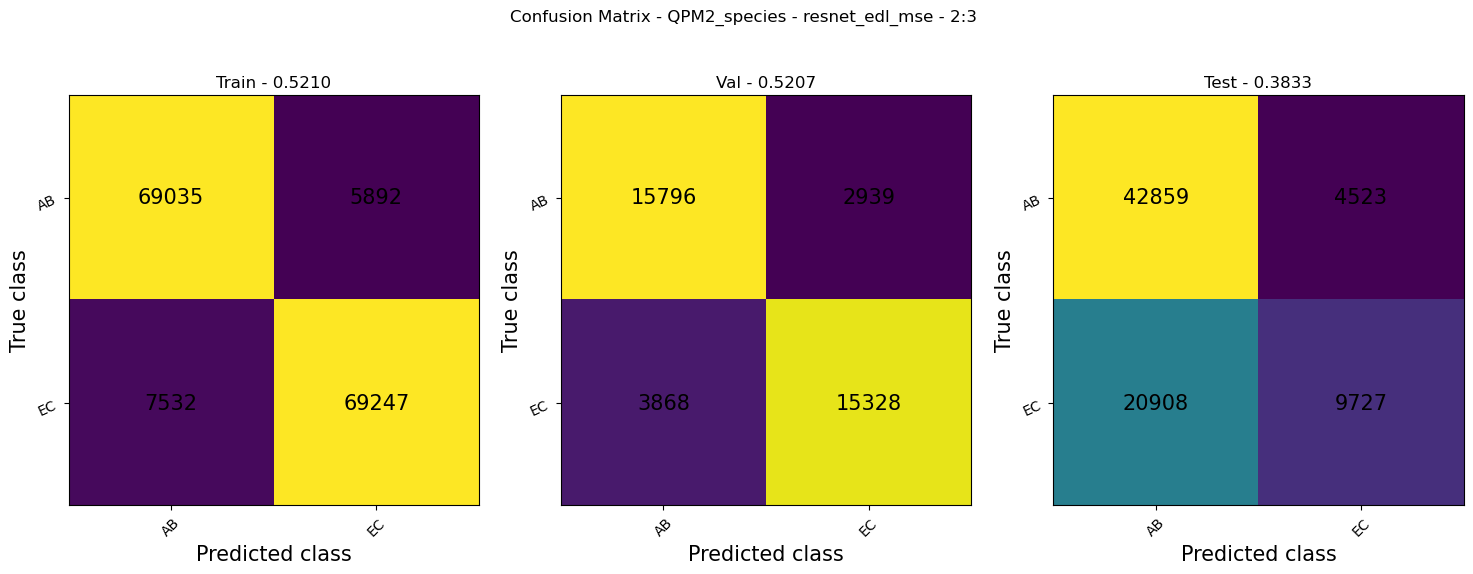

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(78017, 2) (81589, 2)
(78017, 2) (81589, 2)


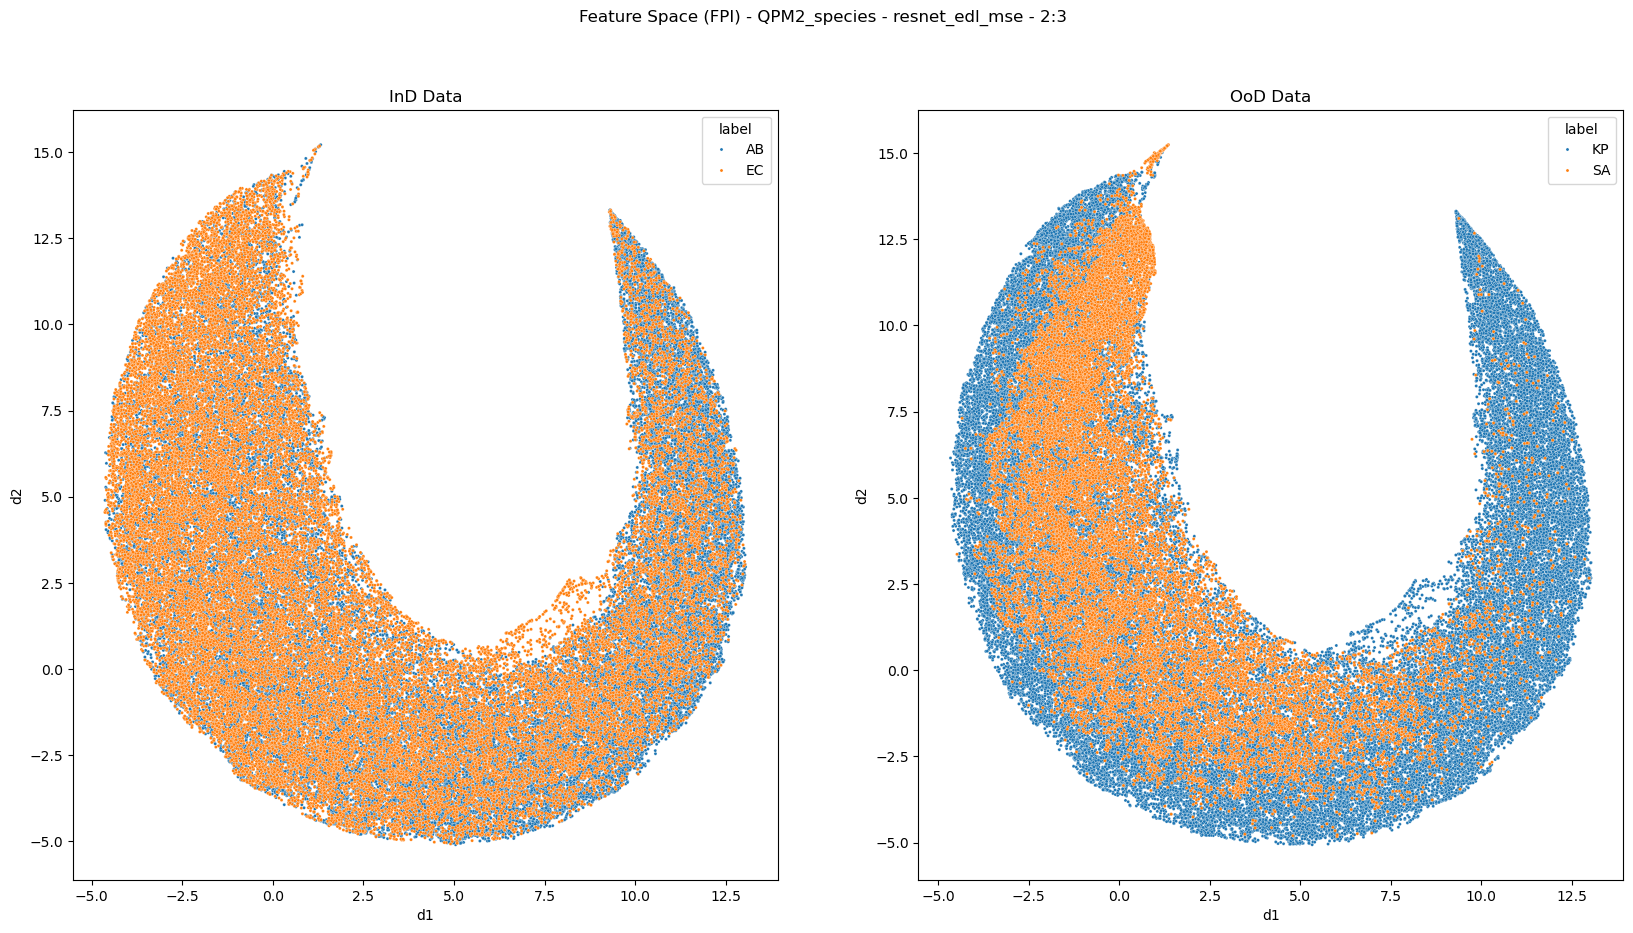

In [13]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

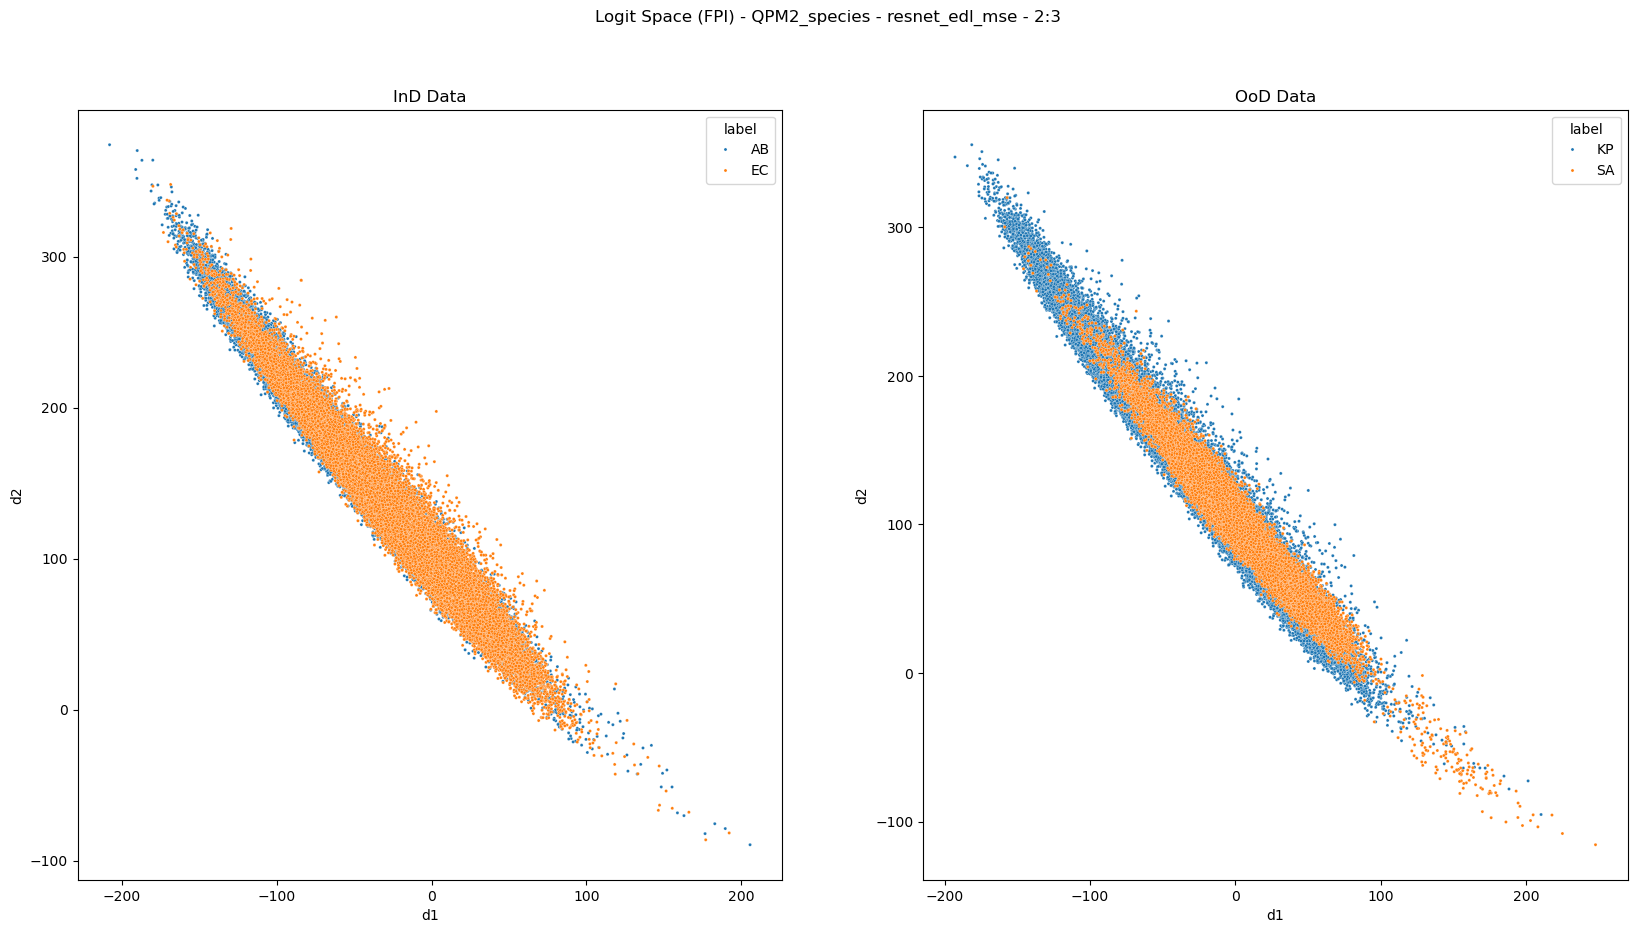

In [14]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

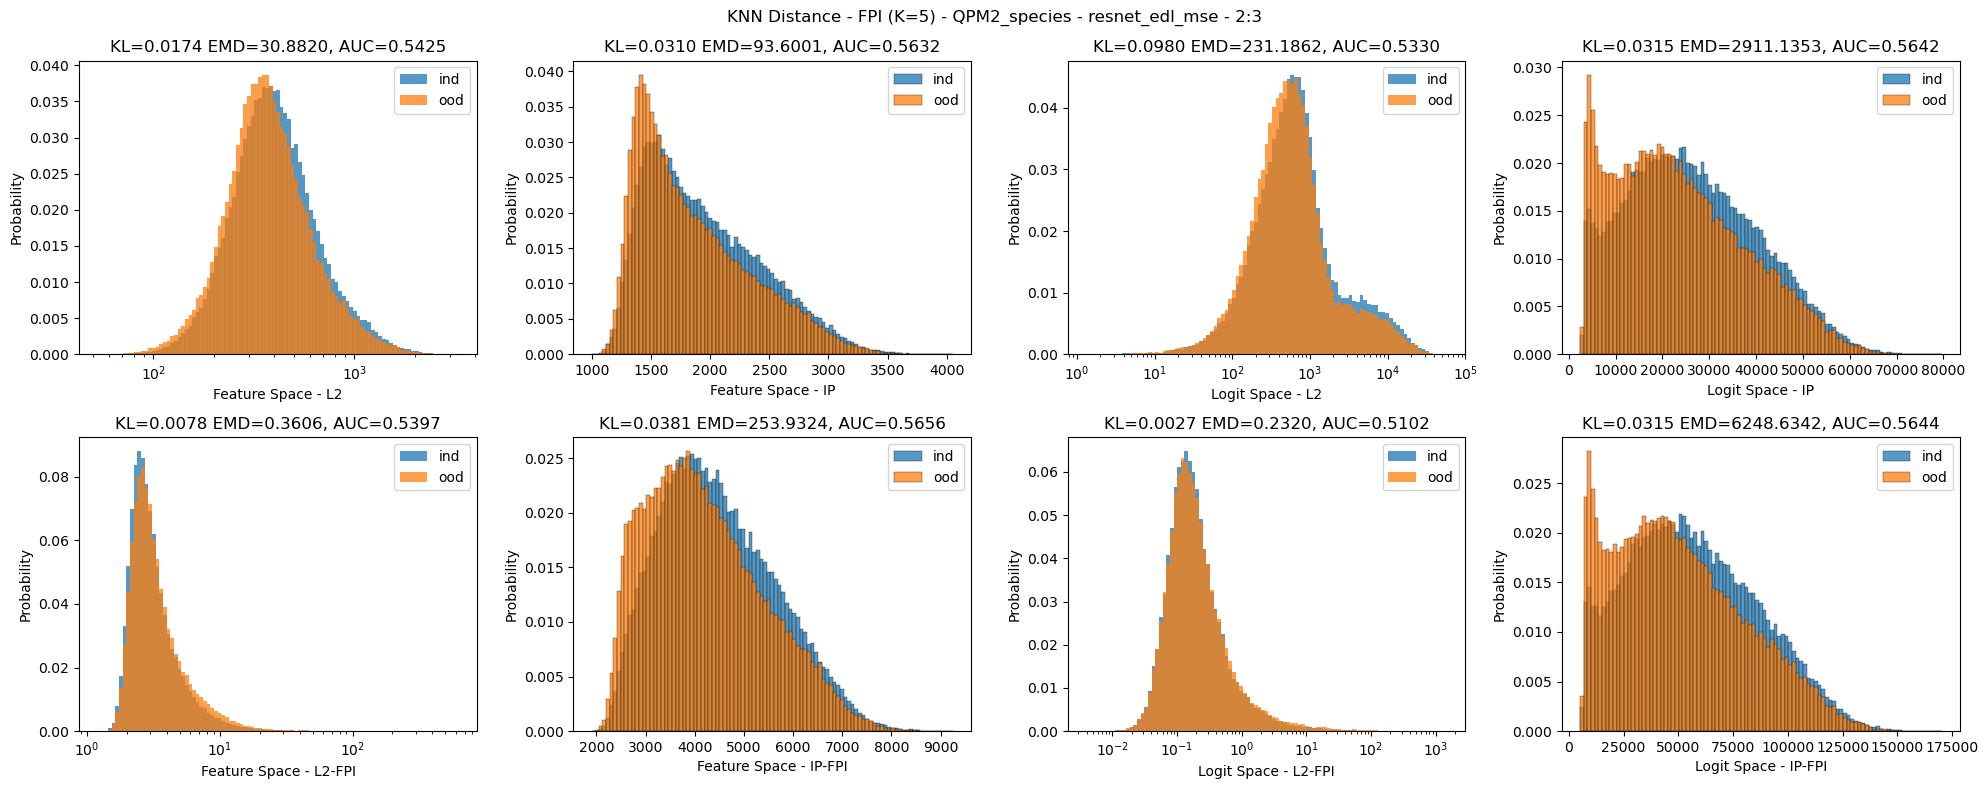

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig.suptitle(f"KNN Distance - FPI (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0][0], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[0][0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][1], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[0][1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[0][2], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[0][2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][3], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[0][3].set_xlabel("Logit Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[1][0], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[1][0].set_xlabel("Feature Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][1], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[1][1].set_xlabel("Feature Space - IP-FPI")
plot_knn_dists(faiss.IndexFlatL2, axs[1][2], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[1][2].set_xlabel("Logit Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][3], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[1][3].set_xlabel("Logit Space - IP-FPI")
plt.tight_layout()
plt.show()

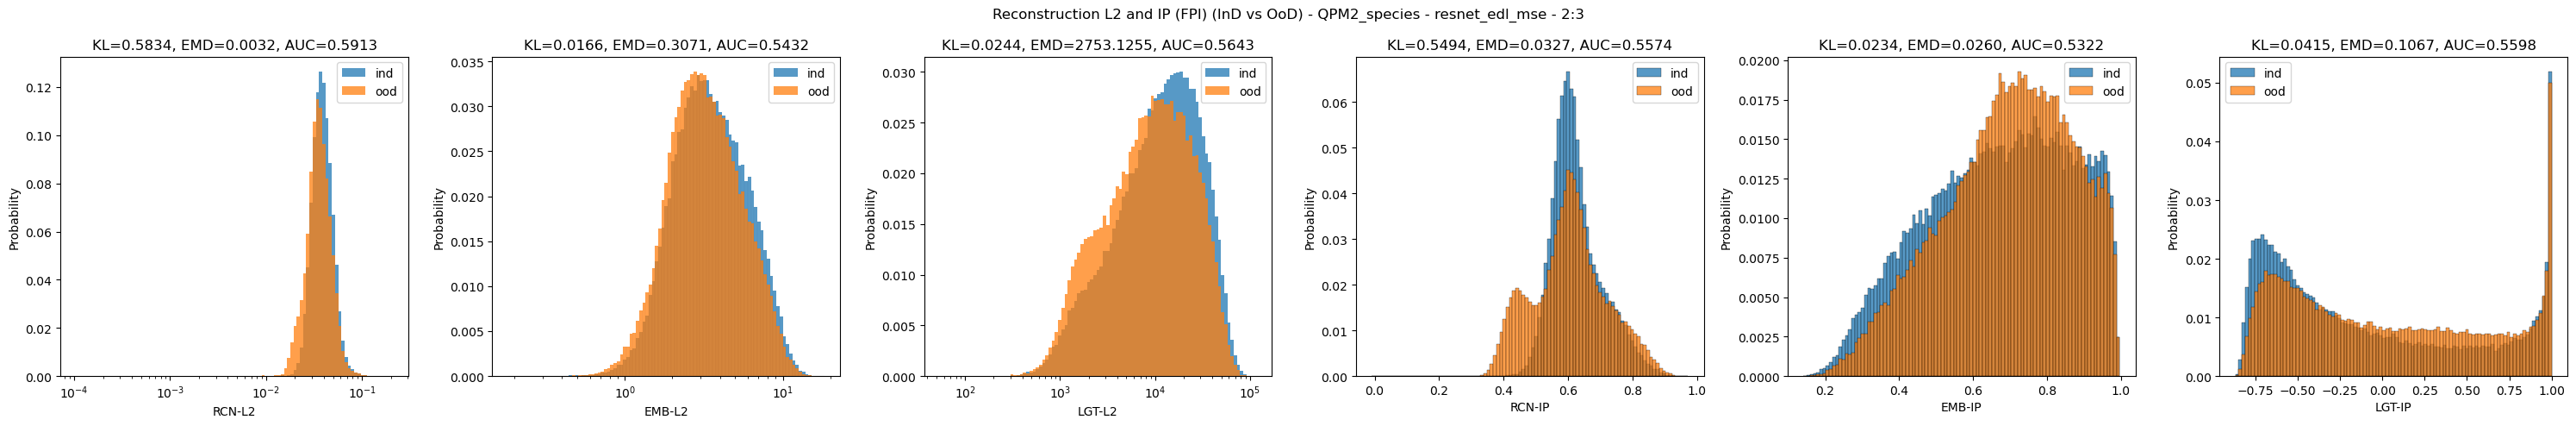

In [16]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
# unit vectors
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    # unit vectors
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
plot_rcn(ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
plot_rcn(ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
plot_rcn(ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
plot_rcn(ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
plot_rcn(ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

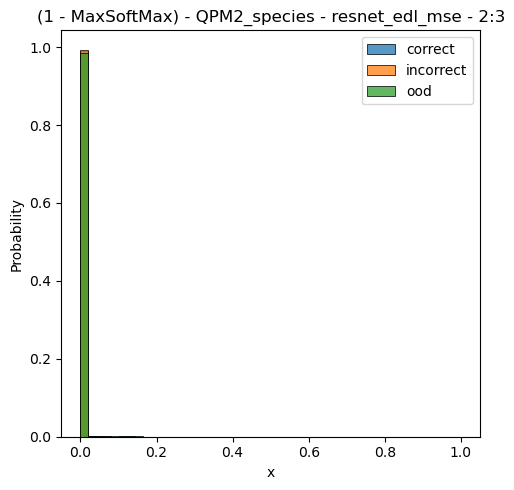

In [17]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

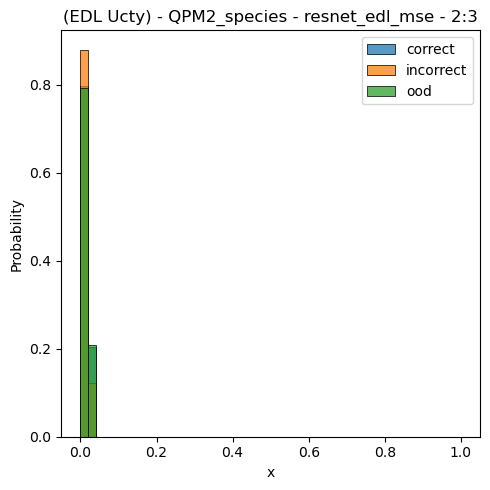

In [18]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data
K = ind_lgt_fpi.shape[-1]
ind_belief_fpi = np.clip(ind_lgt_fpi, 0, None)
ind_pred_fpi = ind_lgt_fpi.argmax(-1)
ind_prob_fpi = ind_belief_fpi / (ind_belief_fpi.sum(-1, keepdims=True) + K)
ind_ucty_fpi = K / (ind_belief_fpi.sum(-1) + K)

if ood_str:
    ood_belief_fpi = np.clip(ood_lgt_fpi, 0, None)
    ood_pred_fpi = ood_lgt_fpi.argmax(-1)
    ood_prob_fpi = ood_belief_fpi / (ood_belief_fpi.sum(-1, keepdims=True) + K)
    ood_ucty_fpi = K / (ood_belief_fpi.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()